In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
import math
from tqdm import tqdm, trange
import random
import time

In [3]:
from experiencereplay import ExperienceReplay, PrioritizedExperienceReplay, ModelBasedPrioritizedExperienceReplay
from experiment import Experiment
from dmlac import DMLAC
import nn
from exploration import EpsilonGreedyStrategy, OUStrategy

In [4]:
settings = dict(
    environment = 'Reacher-v1',
    timesteps = 8000,
    batch_size = 64,
    learning_start = 256,
    forward_steps = 1,
    discount_factor = 0.9,
    trace_decay = 0.5,
    
    max_replay_buffer_size = 100000,
    
    actor_learning_rate=0.0001,
    model_learning_rate=0.001,
    reward_learning_rate=0.001,
    value_learning_rate=0.001,
    
    actor_l2=None,
    model_l2=None,
    reward_l2=None,
    value_l2=None,
    
    actor_target_approach_rate=0.99,
    value_target_approach_rate=0.99,
    
    train_updates_per_step = 10,
    priority_updates_per_step = 100,
    
    actor_net_layers = [256, 128],
    actor_net_activation_fn = tf.nn.tanh,
    actor_bounded_output = True,
    value_net_layers =  [256, 128],
    value_net_activation_fn = tf.nn.elu,
    model_net_embedding = 128,
    model_net_layers = [128],
    model_net_activation_fn = tf.nn.elu,
    reward_net_embedding = 128,
    reward_net_layers =  [128],
    reward_net_activation_fn = tf.nn.elu,
    
    environment_seed = 0,
    noise_seed= 0,
    
    gpu_memory_fraction = 0.1,
    
    render_start=5500,
    render_environment = True,
    render_frequency = 10,
)

settings["experiment_path"] = "experiments/experiment_dmlac_{}_{}".format(settings["environment"], int(time.time()))
settings["actor_tf_optimizer"] = tf.train.AdamOptimizer(settings["actor_learning_rate"])
settings["model_tf_optimizer"] = tf.train.AdamOptimizer(settings["model_learning_rate"])
settings["reward_tf_optimizer"] = tf.train.AdamOptimizer(settings["reward_learning_rate"])
settings["value_tf_optimizer"] = tf.train.AdamOptimizer(settings["value_learning_rate"])

print(settings["experiment_path"])

experiments/experiment_dmlac_Reacher-v1_1495418098


In [5]:
def preprocess_state(observation):
    state = np.array(observation)
    if settings["environment"] == "MountainCarContinuous-v0":
        state[1] = state[1] * 10
        return state
    else:
        return state
    
def preprocess_reward(reward):
    return reward

In [6]:
env = gym.make(settings["environment"])
env.seed(settings["environment_seed"])

observation = preprocess_state(env.reset())
state = observation

[2017-05-22 03:54:58,198] Making new env: Reacher-v1


In [7]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print(state_dim)
print(action_dim)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.high)
print(env.action_space.low)
print(str(state))

11
2
[ inf  inf  inf  inf  inf  inf  inf  inf  inf  inf  inf]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
[ 1.  1.]
[-1. -1.]
[ 0.99603073  0.99567135 -0.08901003  0.09294385 -0.1590063   0.06923054
 -0.00107423  0.00169846  0.36860851 -0.07769702  0.        ]


In [8]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=settings["gpu_memory_fraction"])
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
summary_writer = tf.summary.FileWriter(settings["experiment_path"] + "/logdir")

In [9]:
actor_network = nn.fully_connected("Actor", session, [state_dim], settings["actor_net_layers"],
                                   action_dim, settings["actor_net_activation_fn"],
                                   env.action_space if settings["actor_bounded_output"] else None, True)
model_network = nn.fully_connected_with_input_embedding(
    "Model", session, [state_dim, action_dim], settings["model_net_embedding"], settings["model_net_layers"], state_dim,
    settings["model_net_activation_fn"], None, False)
reward_network = nn.fully_connected_with_input_embedding(
    "Reward", session, [state_dim, action_dim], settings["reward_net_embedding"], settings["reward_net_layers"], 1, 
    settings["reward_net_activation_fn"], None, False)
value_network = nn.fully_connected("Value", session, [state_dim], settings["value_net_layers"], 1,
                               settings["value_net_activation_fn"], None, False)
print(str(actor_network))

[] --> Actor_input_0
['Actor_input_0'] --> bn_hidden_0
['bn_hidden_0'] --> hidden_0_256
['hidden_0_256'] --> bn_hidden_1
['bn_hidden_1'] --> hidden_1_128
['hidden_1_128'] --> bn_output
['bn_output'] --> output
['output'] --> bounding



In [10]:
agent = DMLAC(actor_network, model_network, reward_network, value_network,
                 forward_steps=settings["forward_steps"],
                 discount_factor=settings["discount_factor"],
                 trace_decay=settings["trace_decay"],
                 actor_tf_optimizer=settings["actor_tf_optimizer"],
                 model_tf_optimizer=settings["model_tf_optimizer"],
                 reward_tf_optimizer=settings["reward_tf_optimizer"],
                 value_tf_optimizer=settings["value_tf_optimizer"],
                 actor_l2=settings["actor_l2"],
                 model_l2=settings["model_l2"],
                 reward_l2=settings["reward_l2"],
                 value_l2=settings["value_l2"],
                 actor_target_approach_rate=settings["actor_target_approach_rate"],
                 value_target_approach_rate=settings["value_target_approach_rate"],
                 summary_writer=summary_writer
                )

In [11]:
saver = tf.train.Saver()
summary_writer.add_graph(session.graph)

In [12]:
experience_replay = ModelBasedPrioritizedExperienceReplay(agent, env, settings["max_replay_buffer_size"], False)

In [13]:
exploration_strategy = EpsilonGreedyStrategy(agent, env, settings["noise_seed"])

In [14]:
exp = Experiment(settings["experiment_path"], session, env, settings, settings["render_environment"], settings["render_frequency"], settings["render_start"])

progress_bar = tqdm(total=settings["timesteps"])

e_t = 0


for t in xrange(settings["timesteps"]):
    e_t += 1
    exploration = ((settings["timesteps"] - t) / float(settings["timesteps"])) ** 4
    if t < settings["learning_start"]:
        exploration = 1
    
    action = exploration_strategy.action(state, exploration)
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(preprocess_state(observation), (state_dim,))
    
    experience_replay.add_experience(state, action, preprocess_reward(reward), next_state, done, float("inf"))
    td_error = math.fabs(experience_replay.get_last_td_error())
    model_error = experience_replay.get_last_model_error()
    reward_error = experience_replay.get_last_reward_error()

    exp.record(t, state, action, reward, next_state, done, td_error, model_error, reward_error)
    
    state = next_state
    
    if done:
        observation = env.reset()
        state = preprocess_state(observation)
        e_t = 0
        
    if t >= settings["learning_start"]:
        experience_replay.train_agent(settings["batch_size"], settings["train_updates_per_step"])
        experience_replay.update_oldest_priorities(settings["priority_updates_per_step"])
            
    progress_bar.set_description('[{}][{}] reward: {:.2f}, reward 100MA: {:.2f}, Exploration: {:.2f}, action: {}, td-error: {:.4f}, model error: {:.4f}, reward error: {:.4f}, ep_reward: {}, ep_dur: {}' 
        .format(t, e_t, reward, exp.reward_100ma.get_average(), exploration, str(action), td_error, model_error, reward_error, exp.last_episode_reward, exp.last_episode_duration))
    progress_bar.update()
    
        
progress_bar.close()

[5509][5510] reward: -0.01, reward 100MA: -0.02, Exploration: 0.01, action: [ 0.04076123 -0.01198206], td-error: 0.0057, model error: 0.0057, reward error: 0.0000, ep_reward: 0, ep_dur: 0:  69%|██████▉   | 5510/8000 [15:51<06:42,  6.19it/s]          0:00<1:05:39,  2.03it/s][2017-05-22 04:10:52,890] GLFW error: 65544, desc: X11: RandR gamma ramp support seems broken
[7999][8000] reward: -0.01, reward 100MA: -0.00, Exploration: 0.00, action: [ 0.02528054  0.01495615], td-error: 0.0345, model error: 0.0035, reward error: 0.0000, ep_reward: 0, ep_dur: 0: 100%|██████████| 8000/8000 [23:32<00:00,  5.21it/s]          


In [15]:
exp.save()
print("Experiment results saved in " + exp.path)

Experiment results saved in experiments/experiment_dmlac_Reacher-v1_1495418098


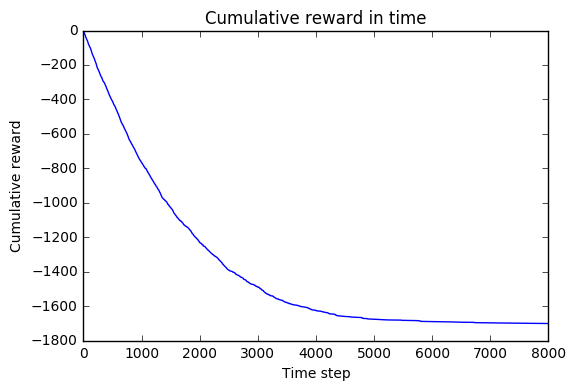

In [16]:
exp.plot_cumulative_reward()

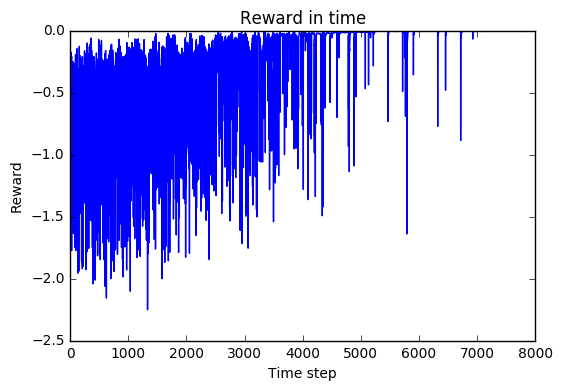

In [17]:
exp.plot_reward()

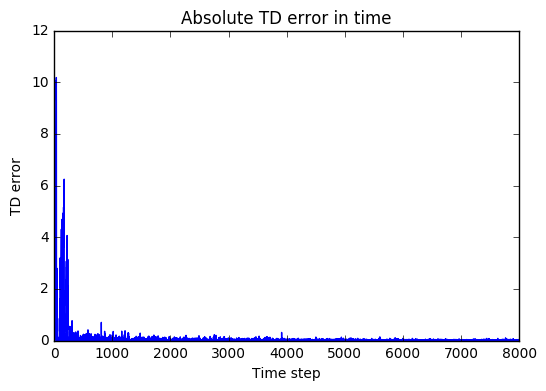

In [18]:
exp.plot_td_error()

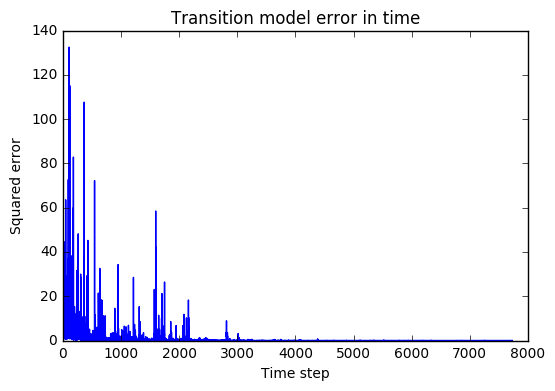

In [19]:
exp.plot_model_error(skip_steps=settings["learning_start"]+10)

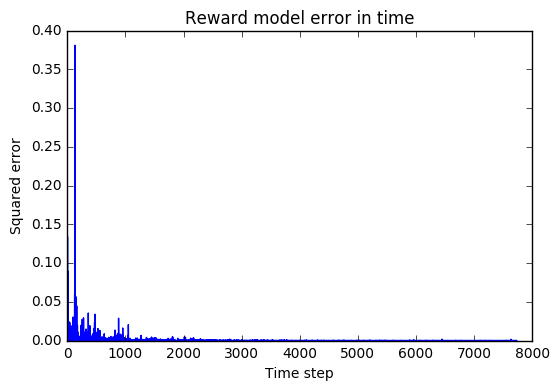

In [20]:
exp.plot_reward_error(skip_steps=settings["learning_start"]+10)

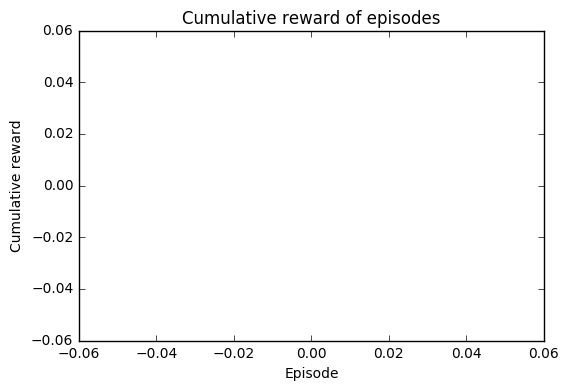

In [21]:
exp.plot_episode_reward()

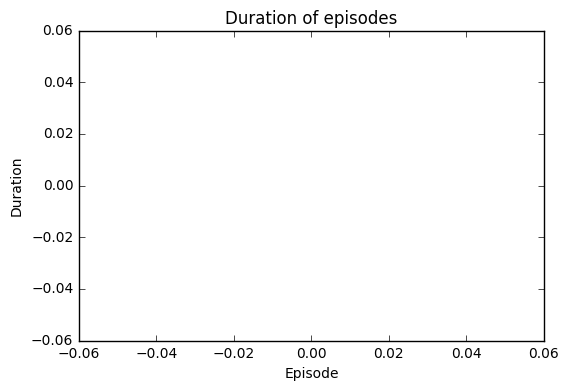

In [22]:
exp.plot_episode_duration()


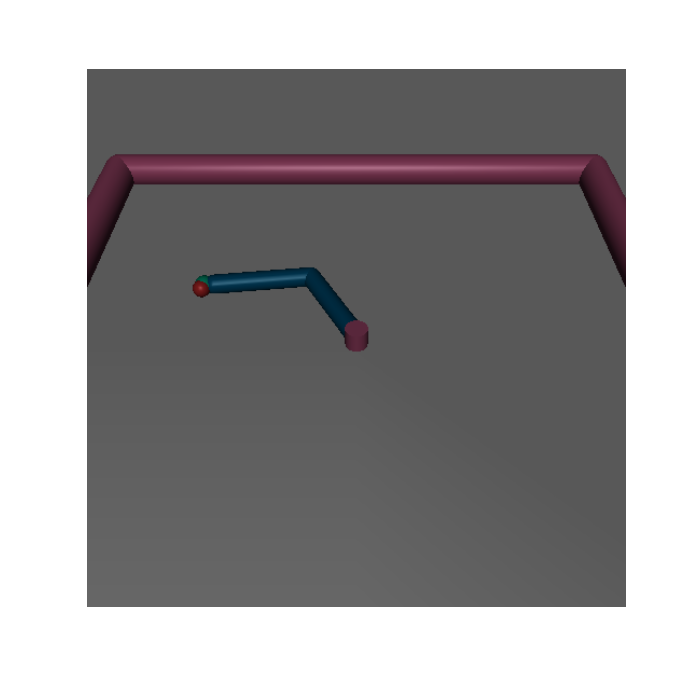
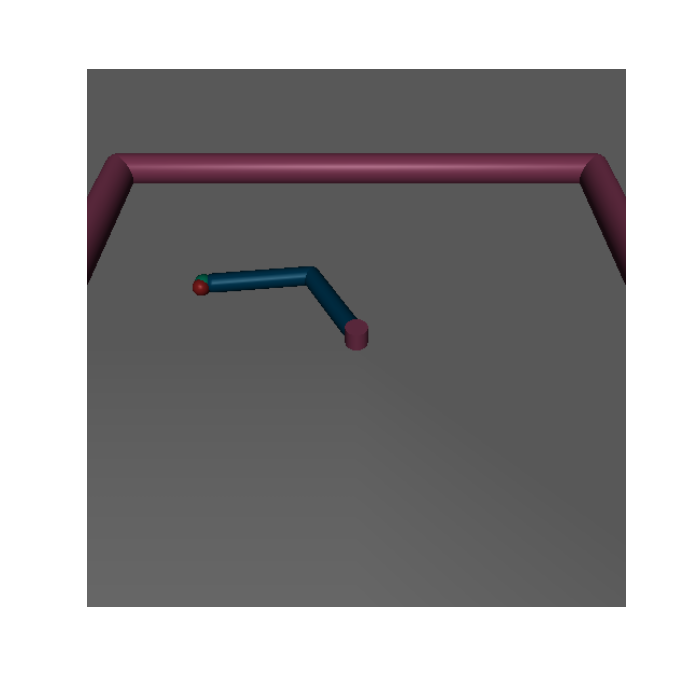
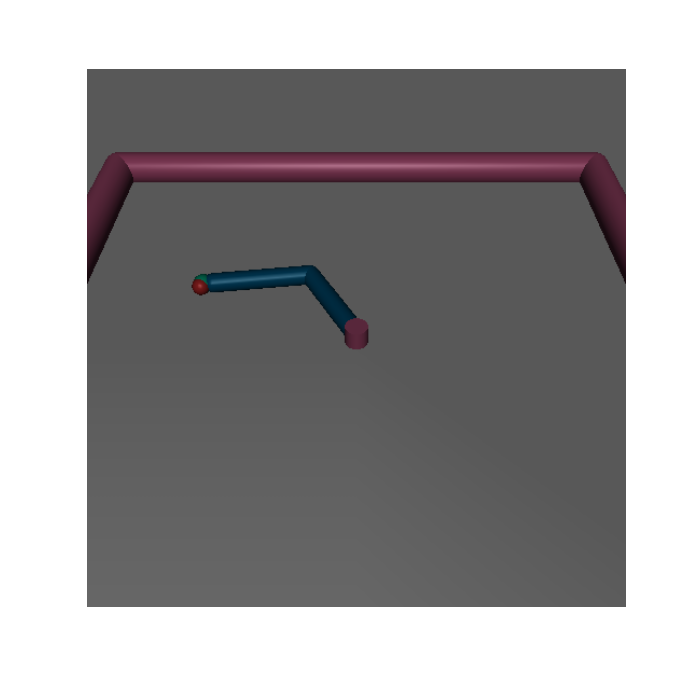
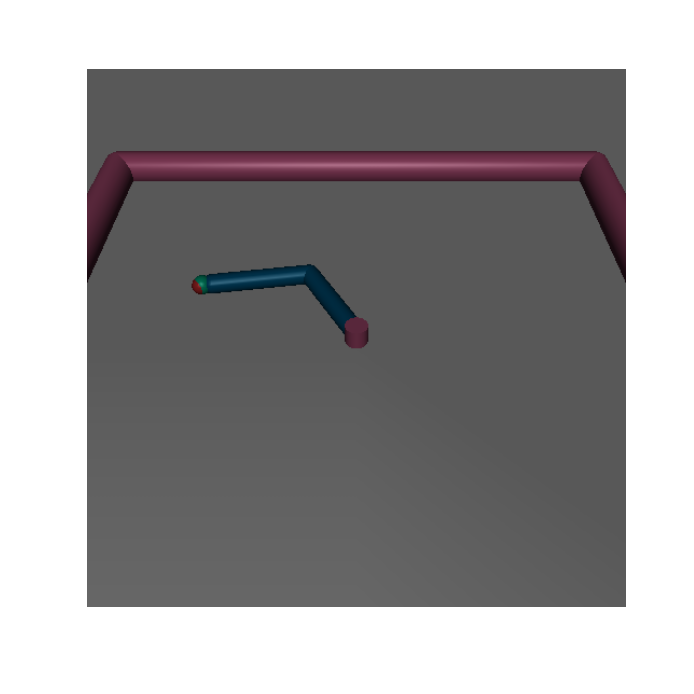
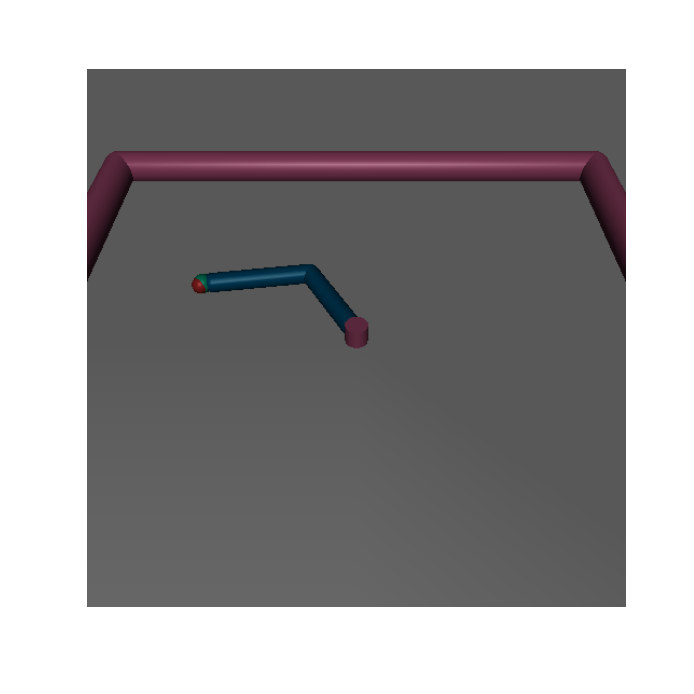
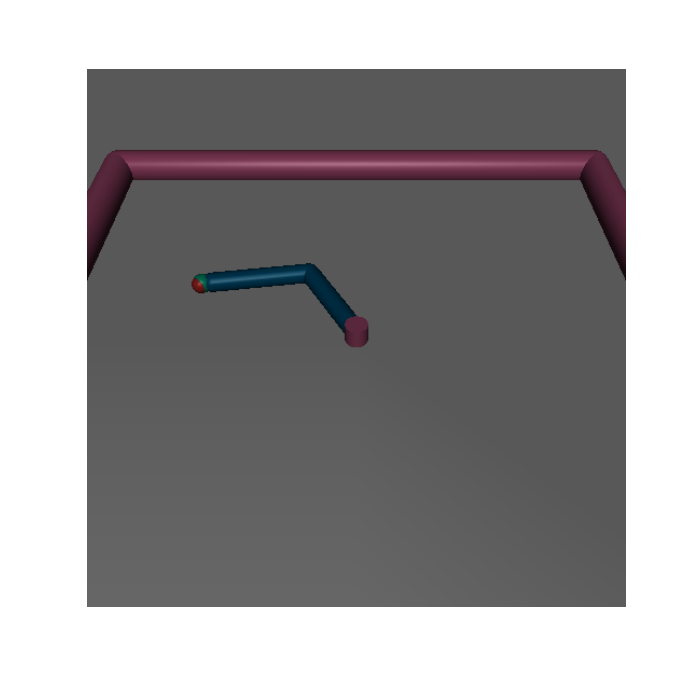
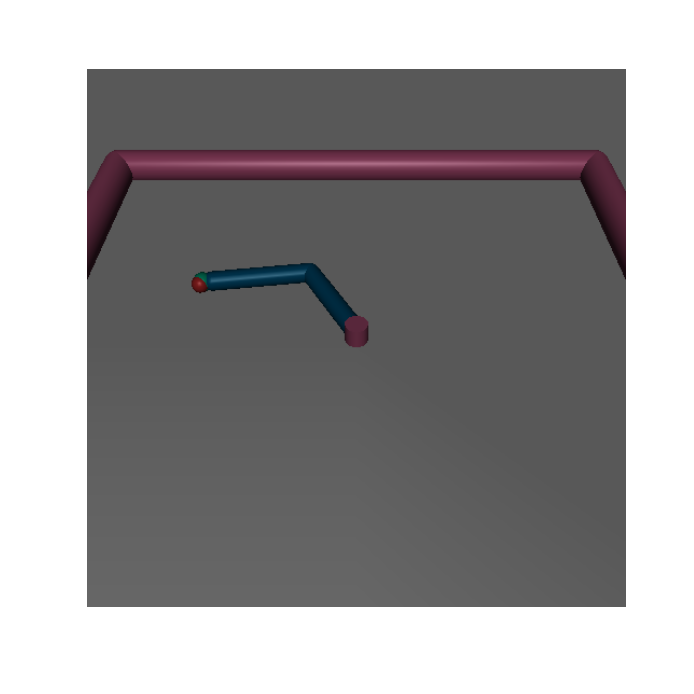
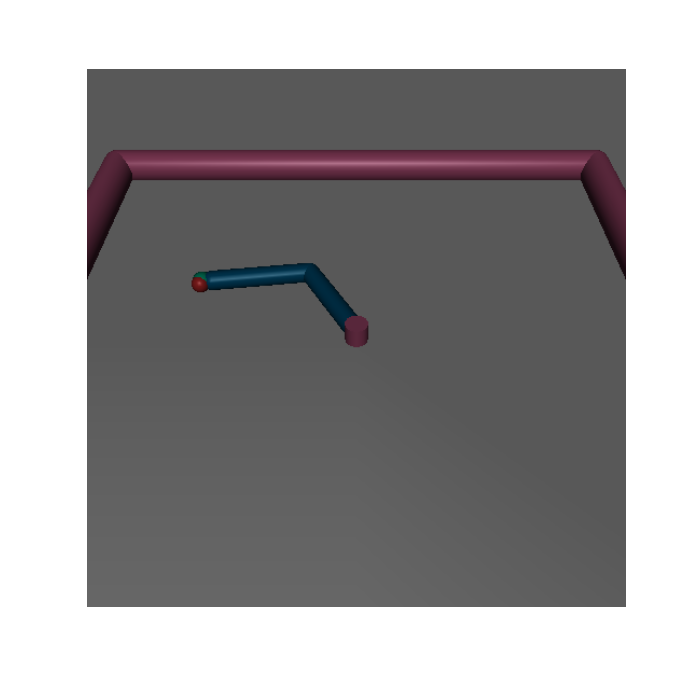
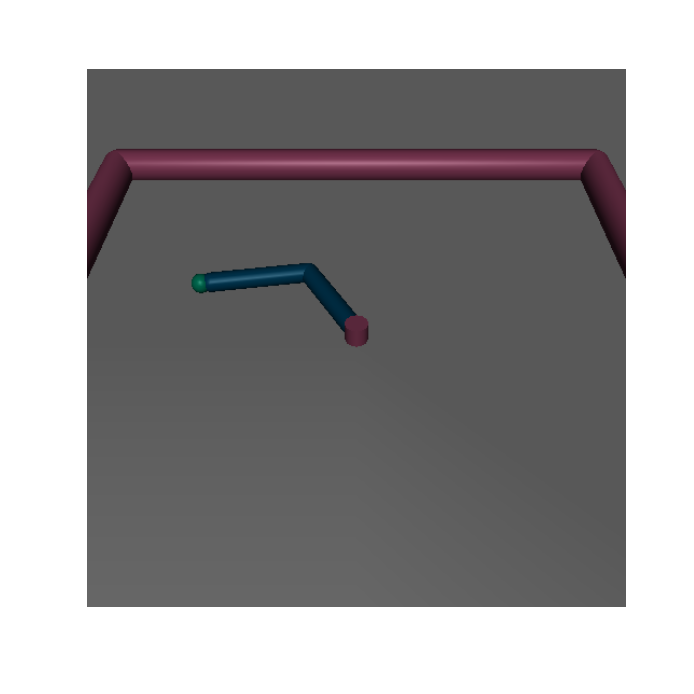
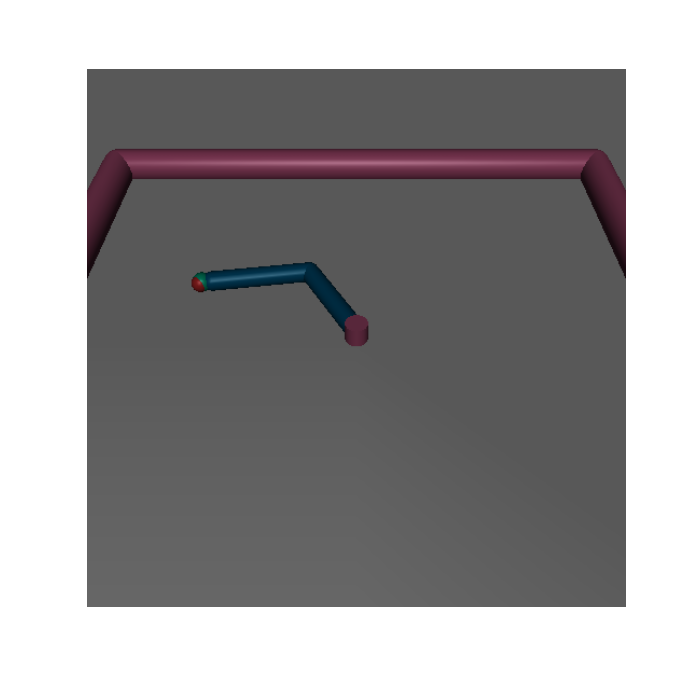
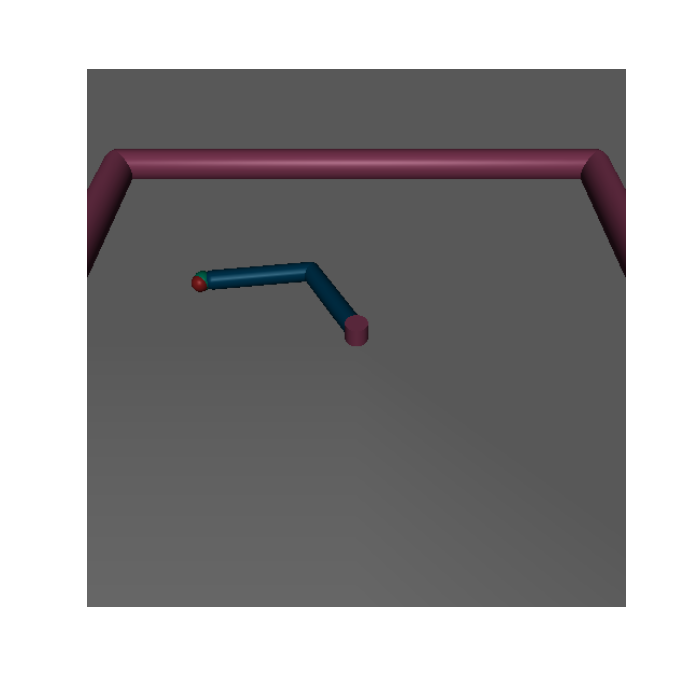
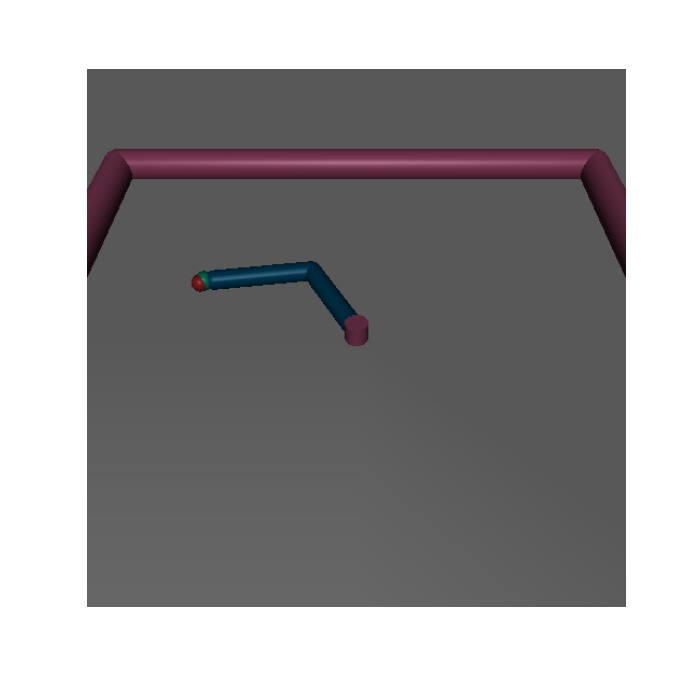
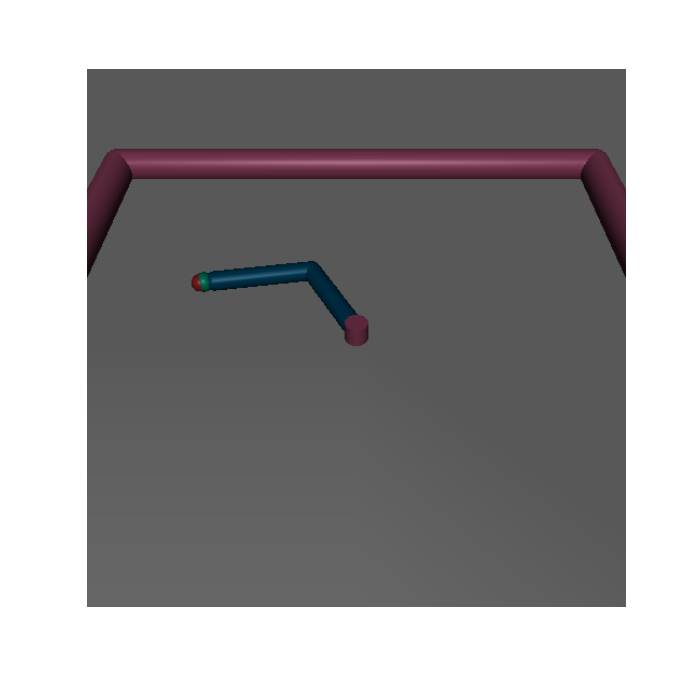
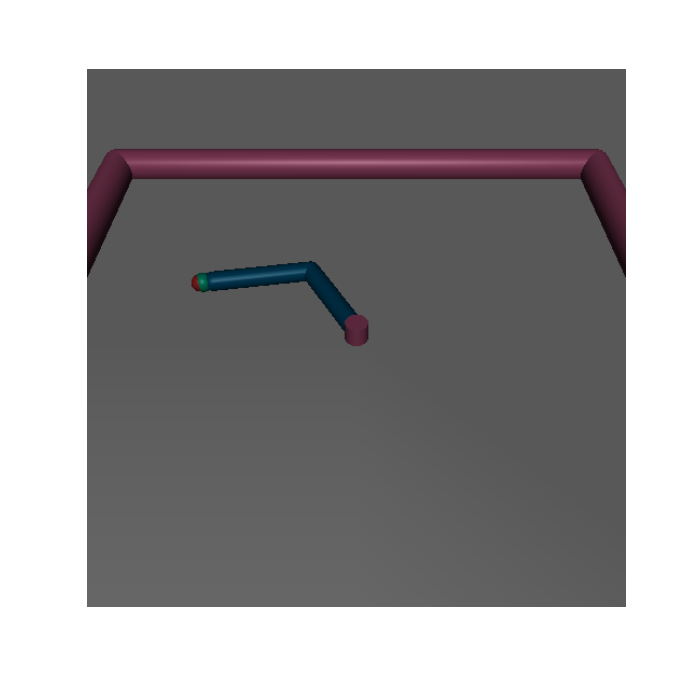
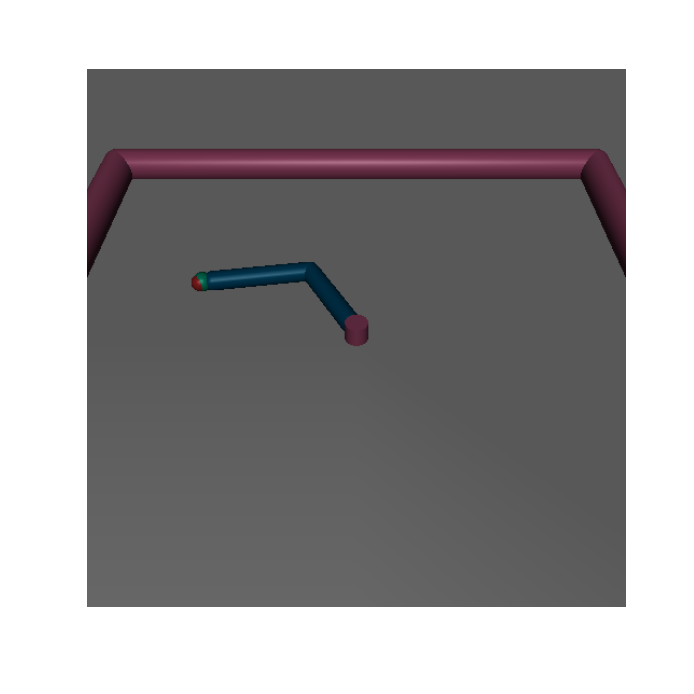
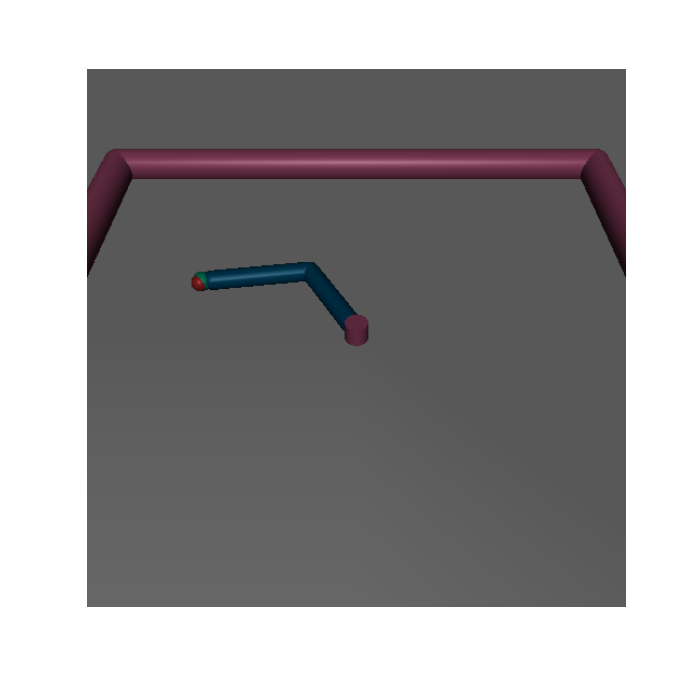
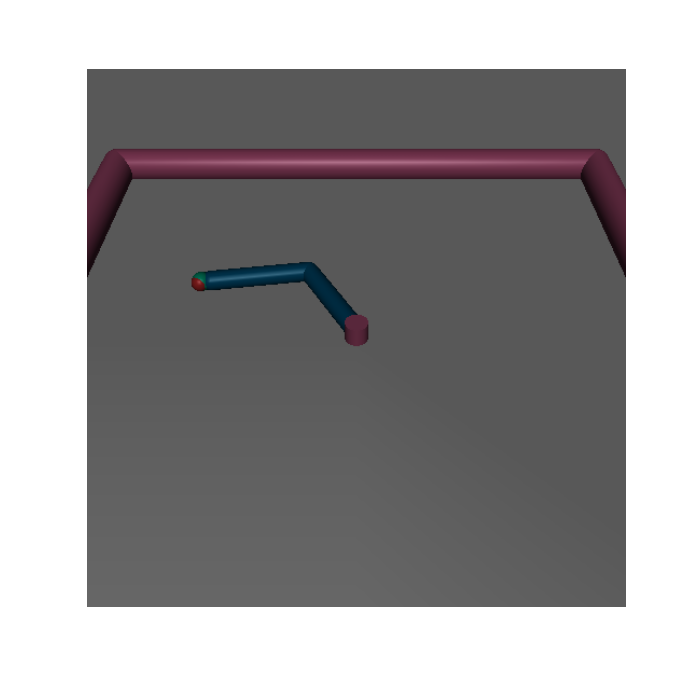
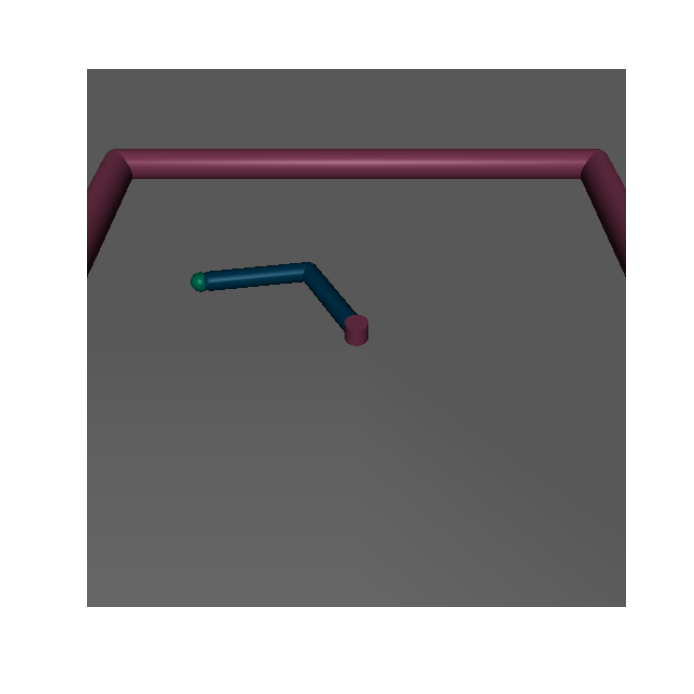
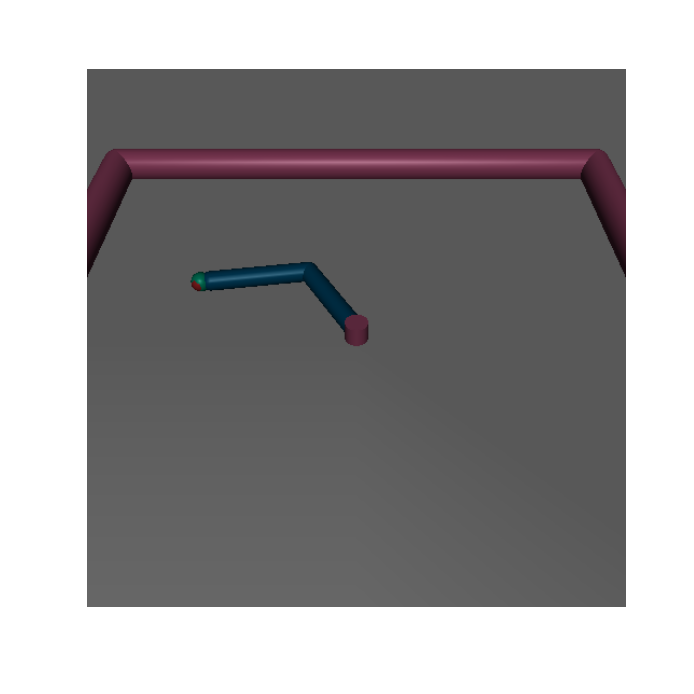
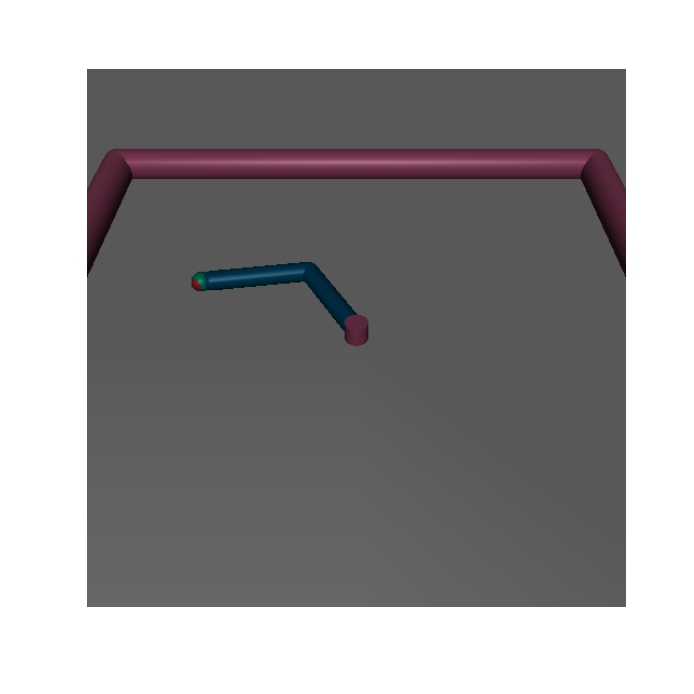
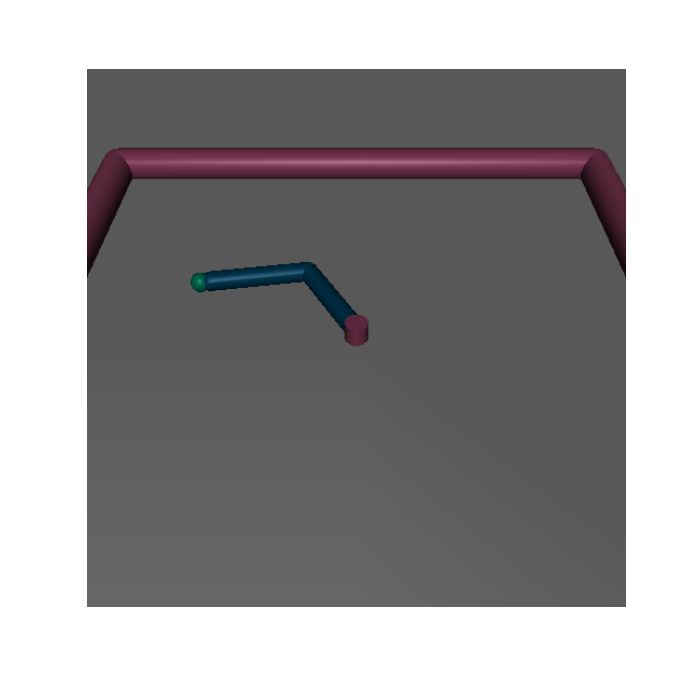
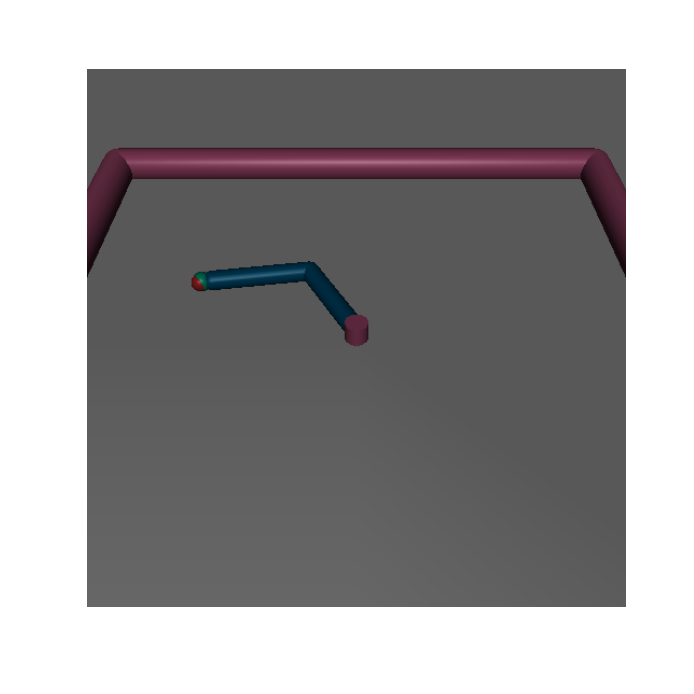
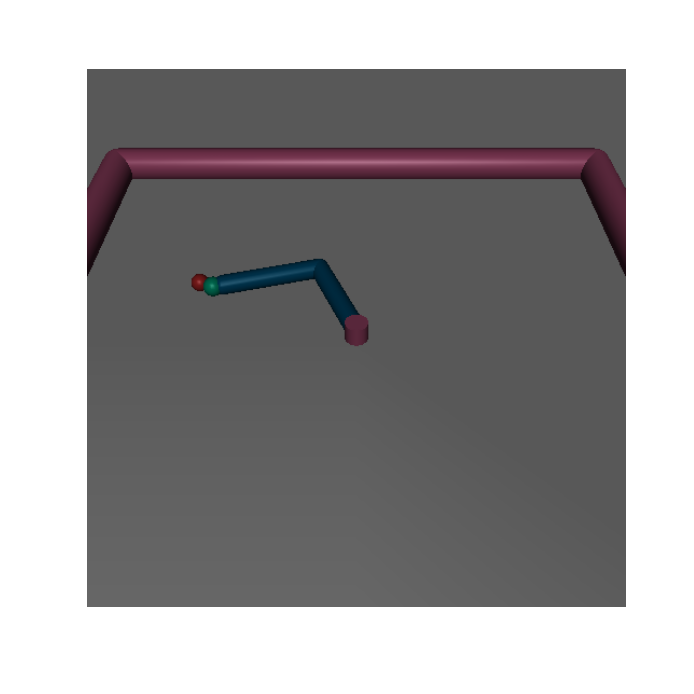
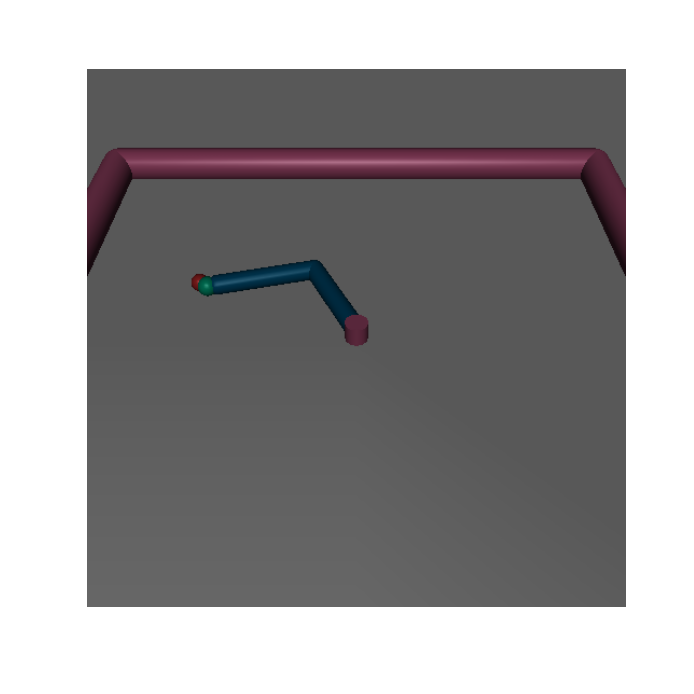
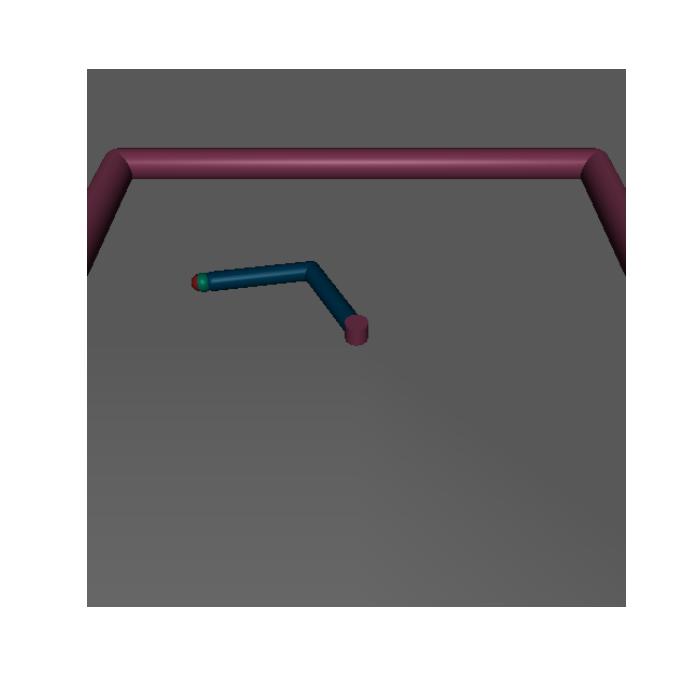
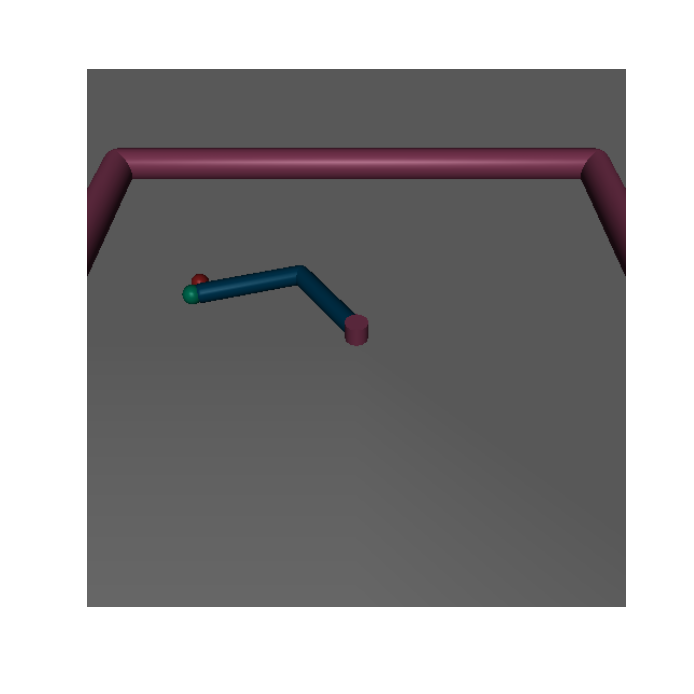
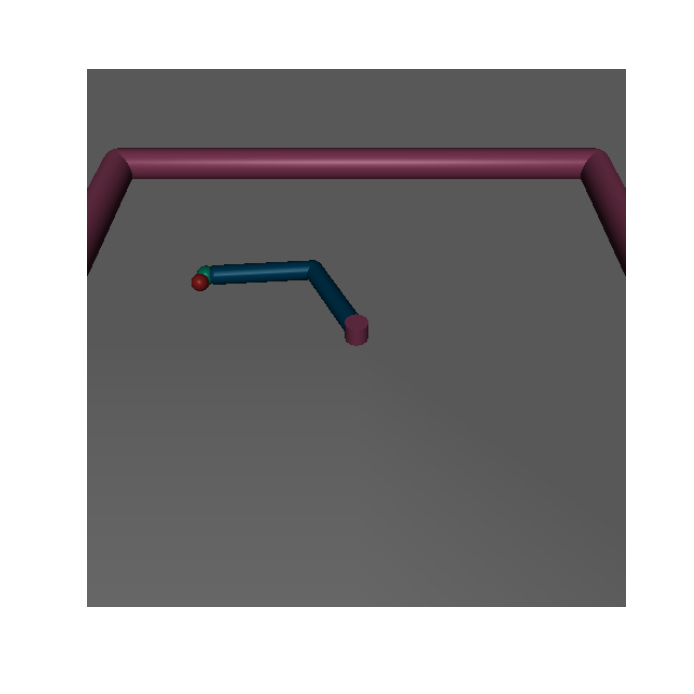
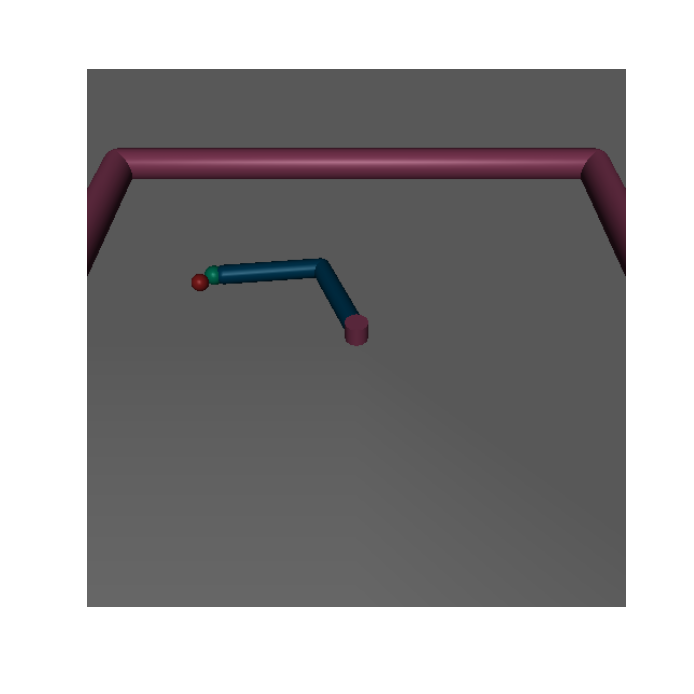
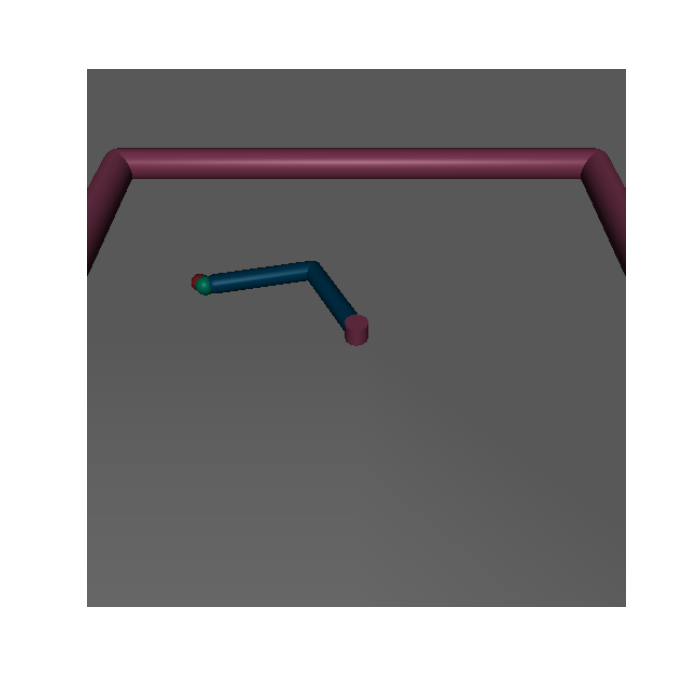
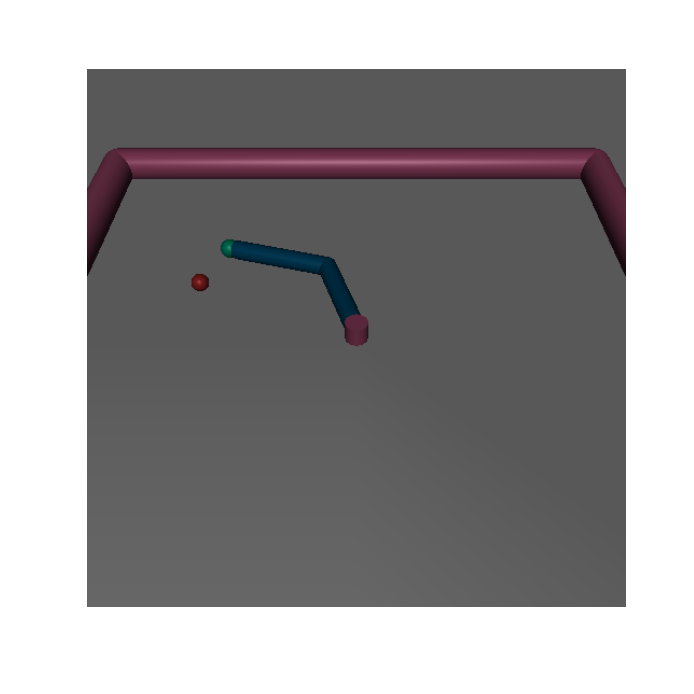
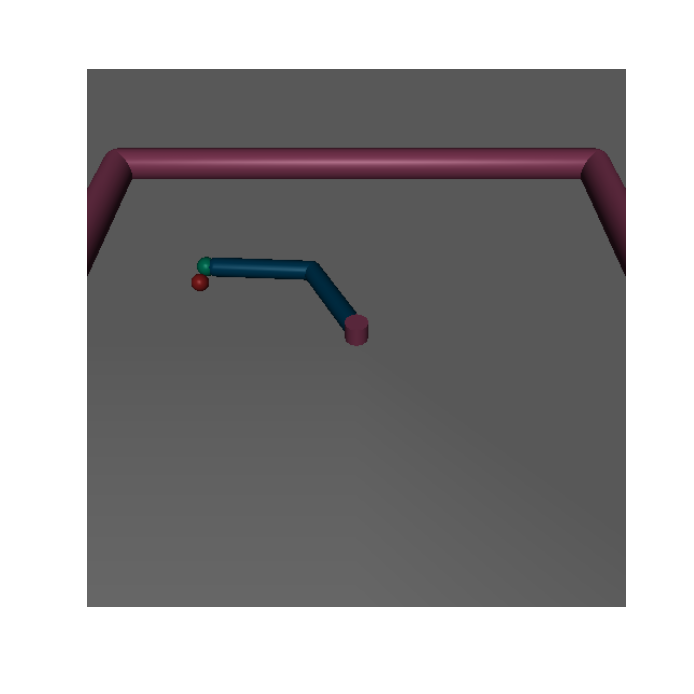
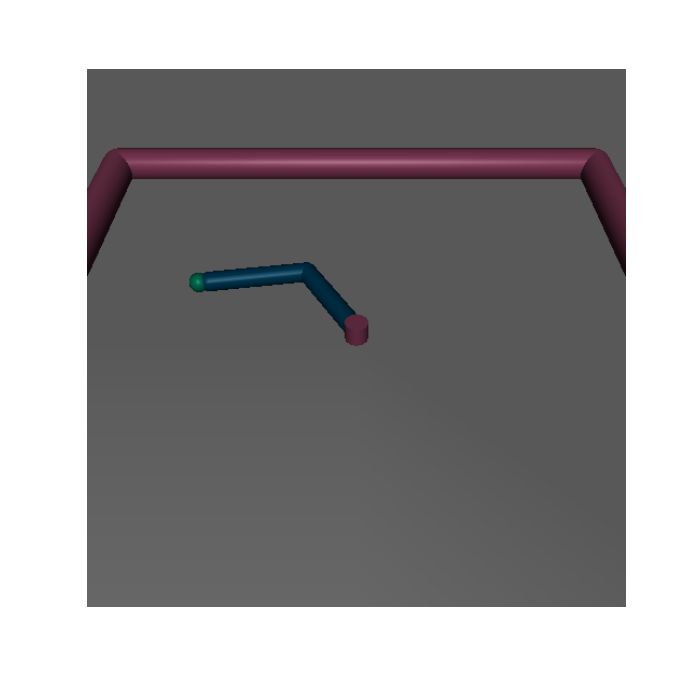
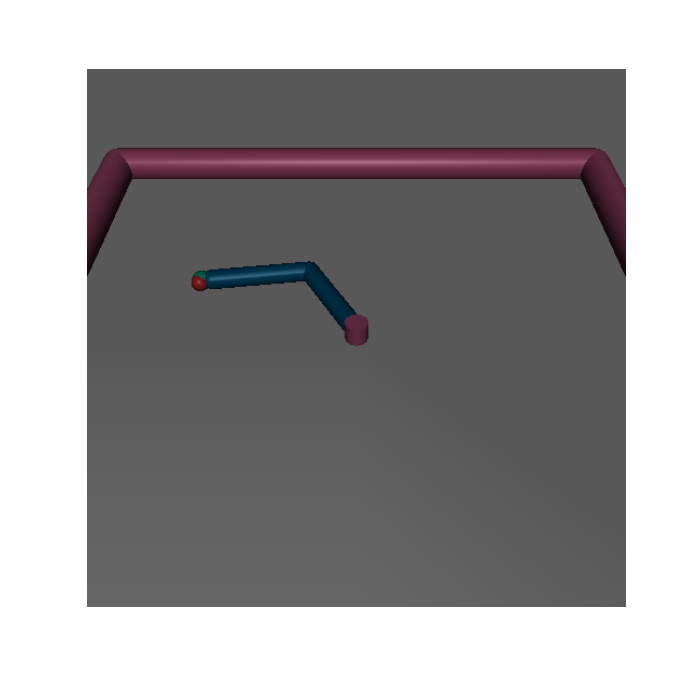
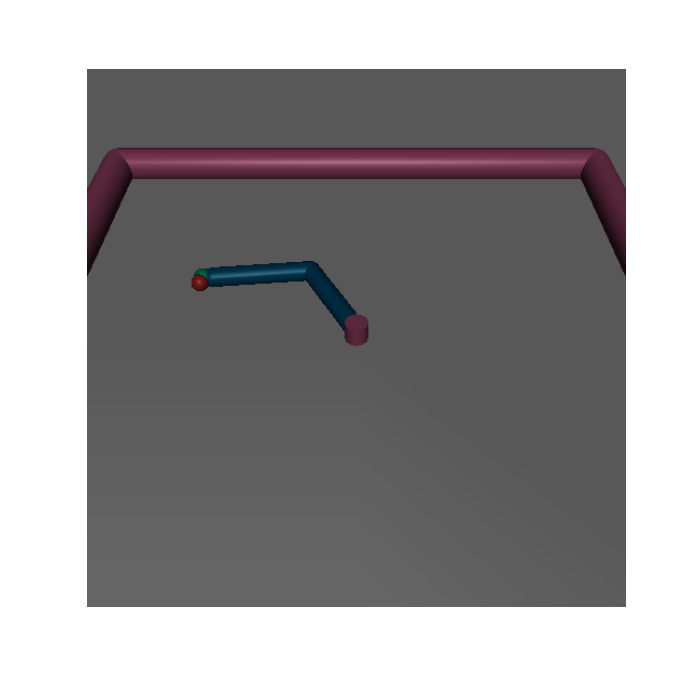
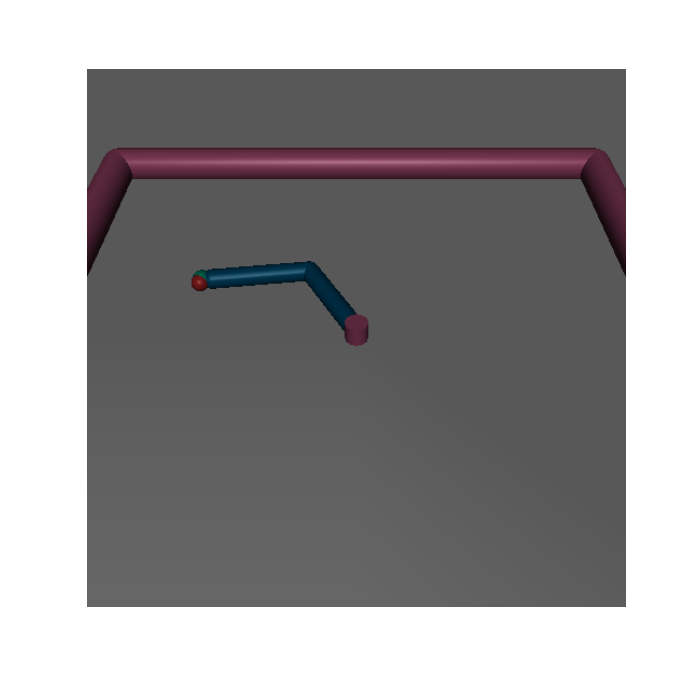
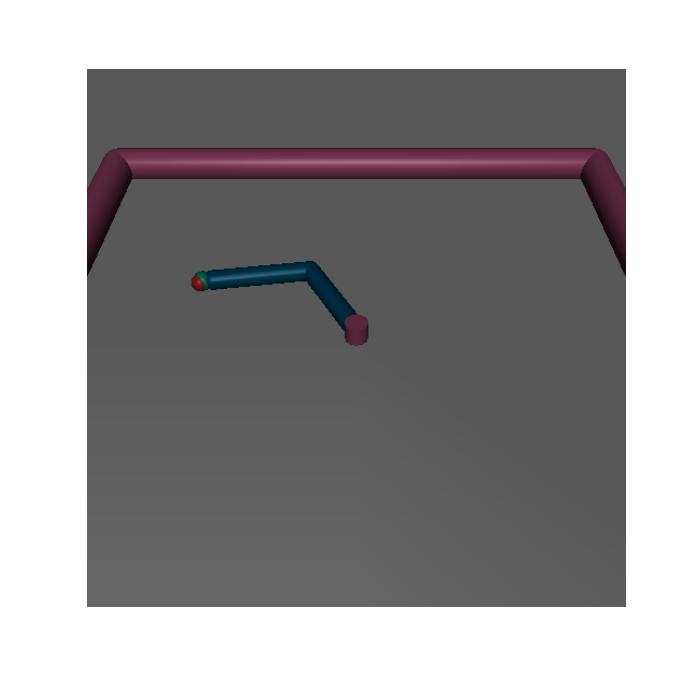
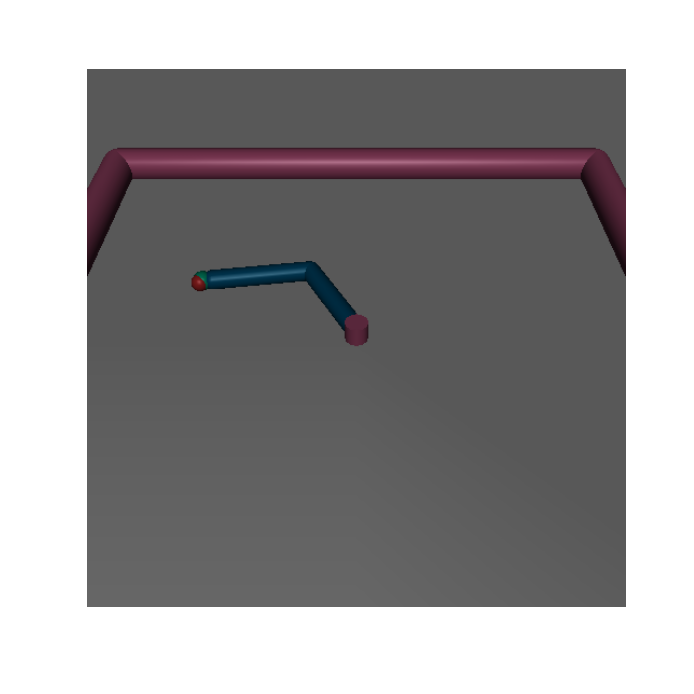
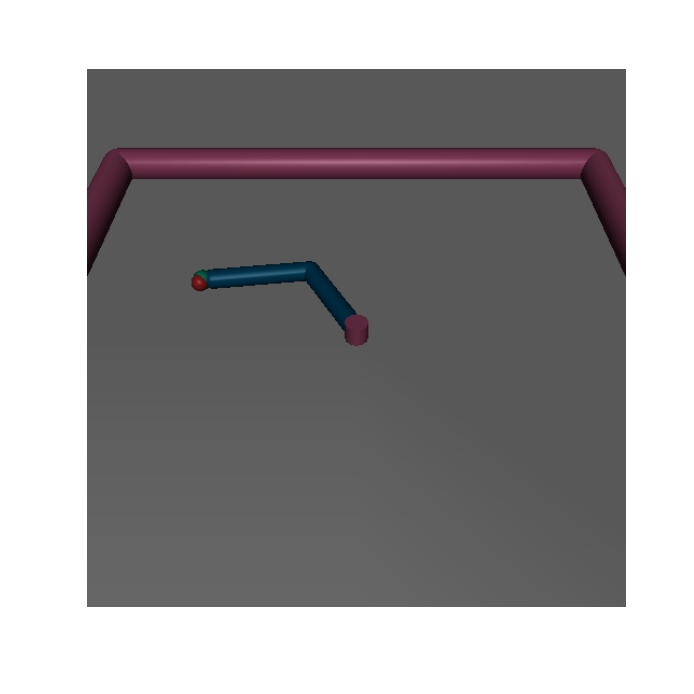
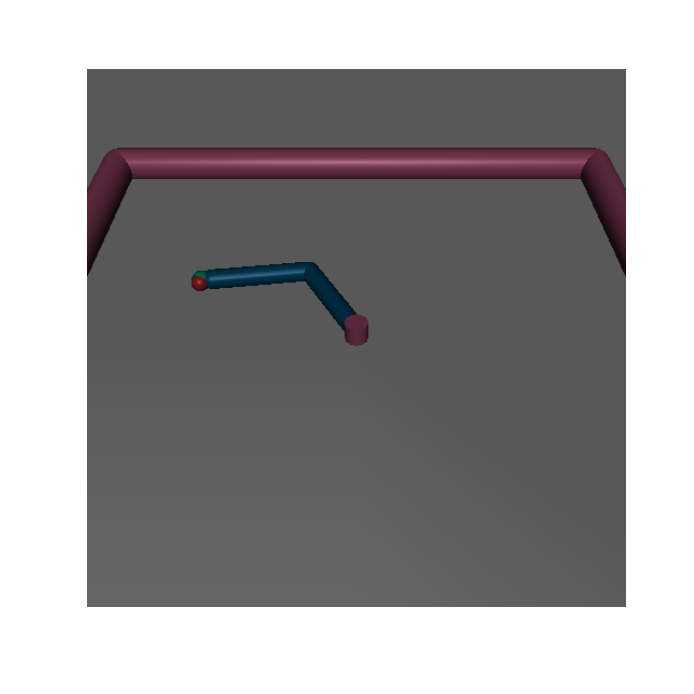
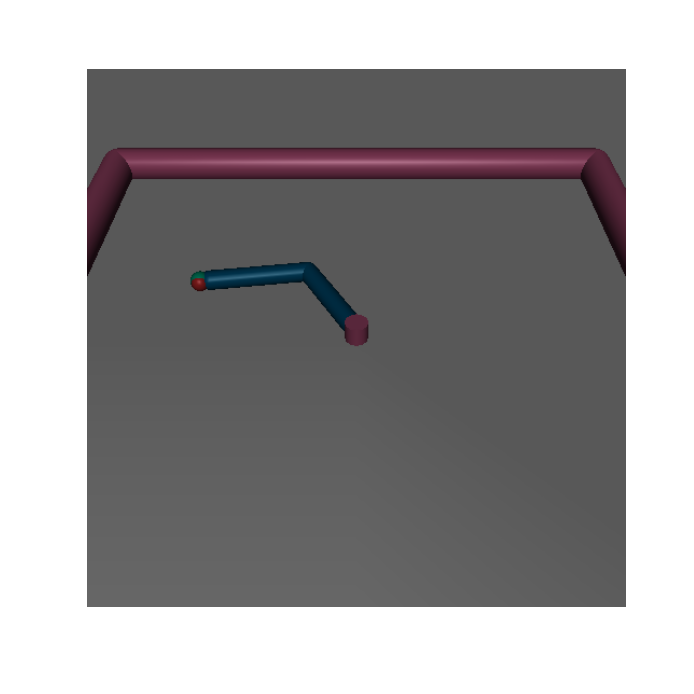
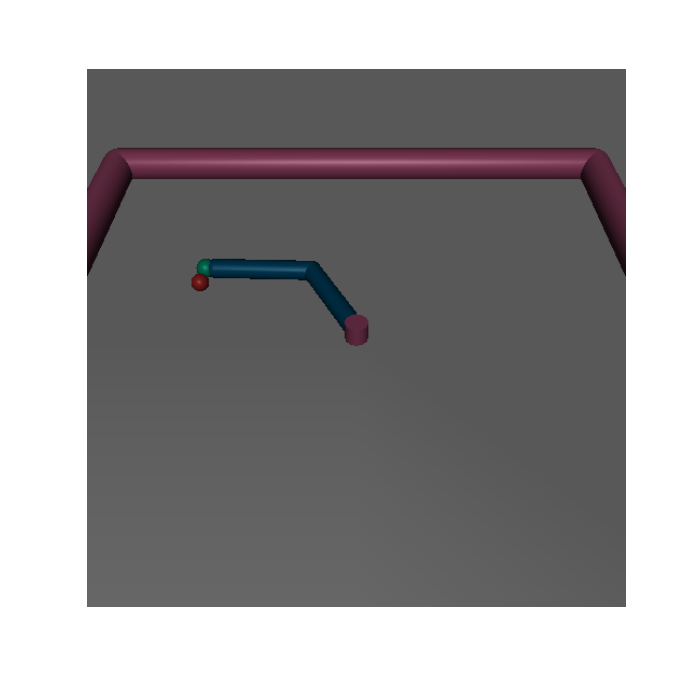
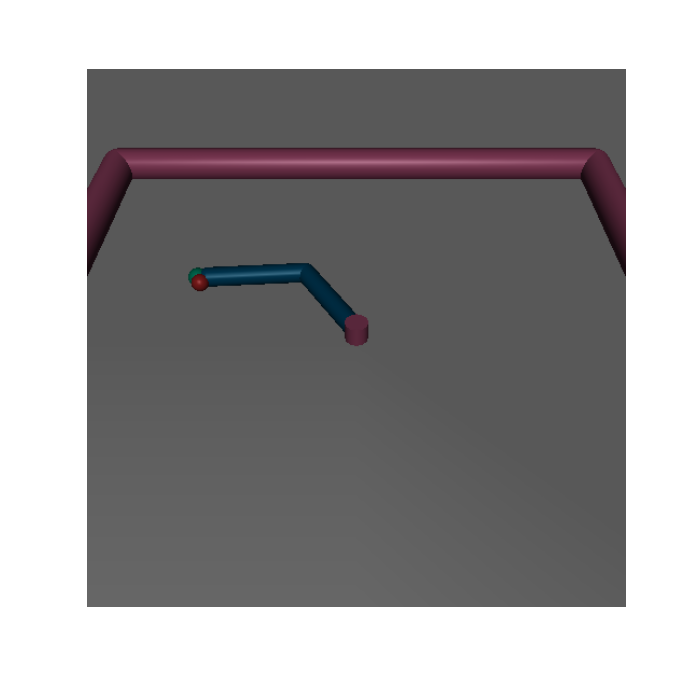
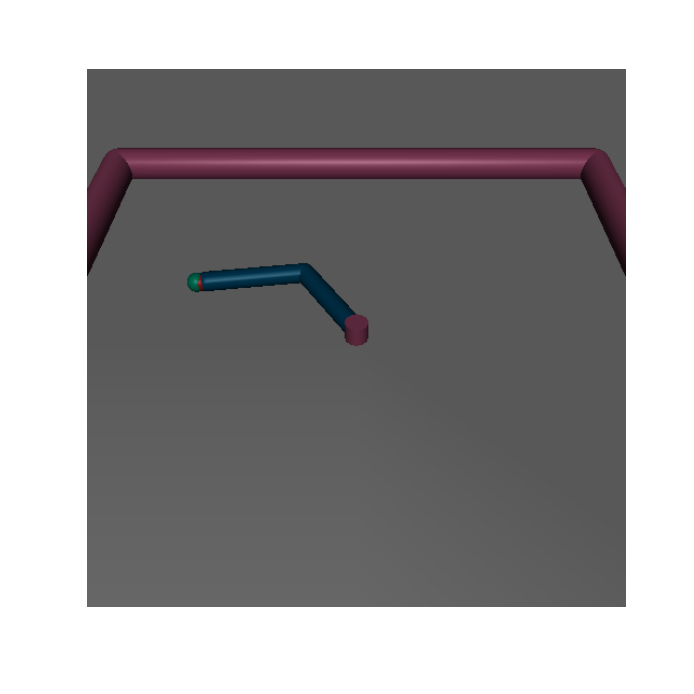
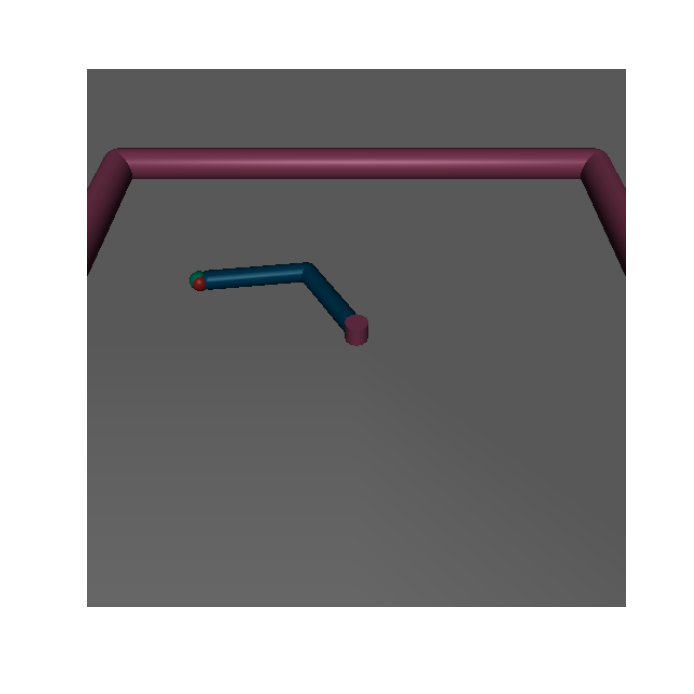
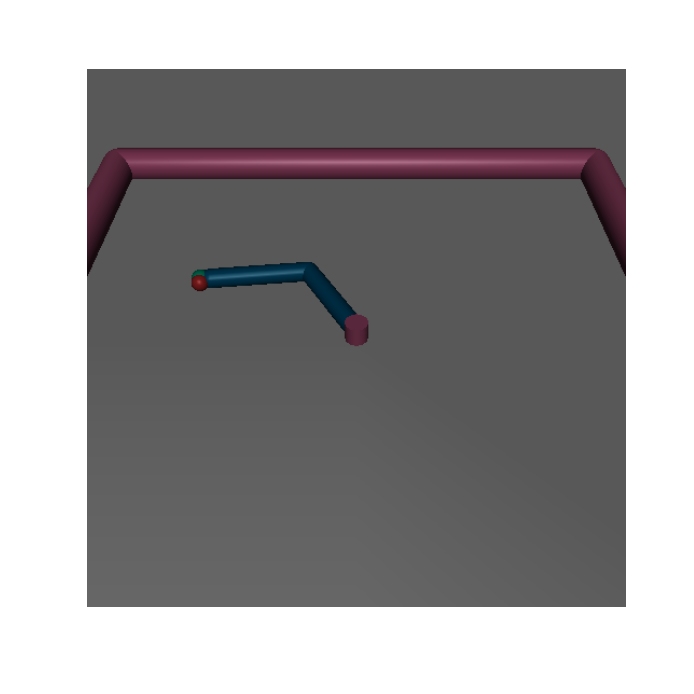
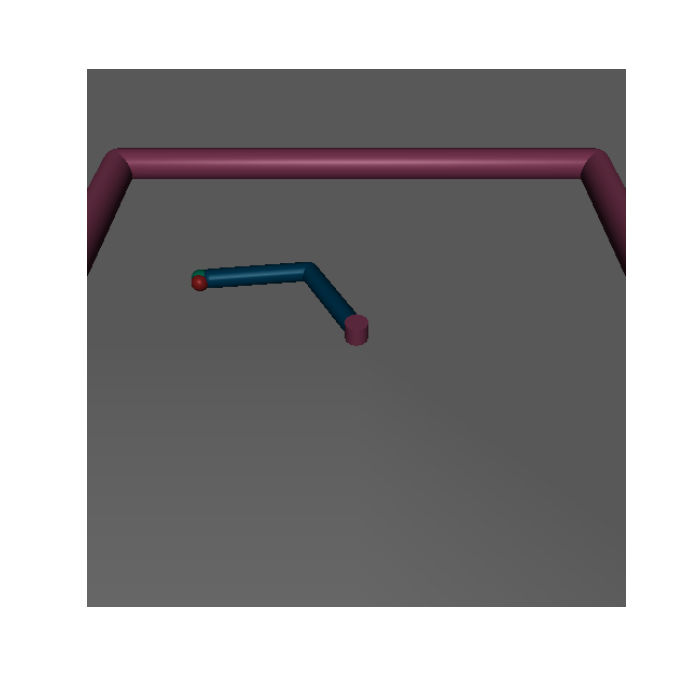
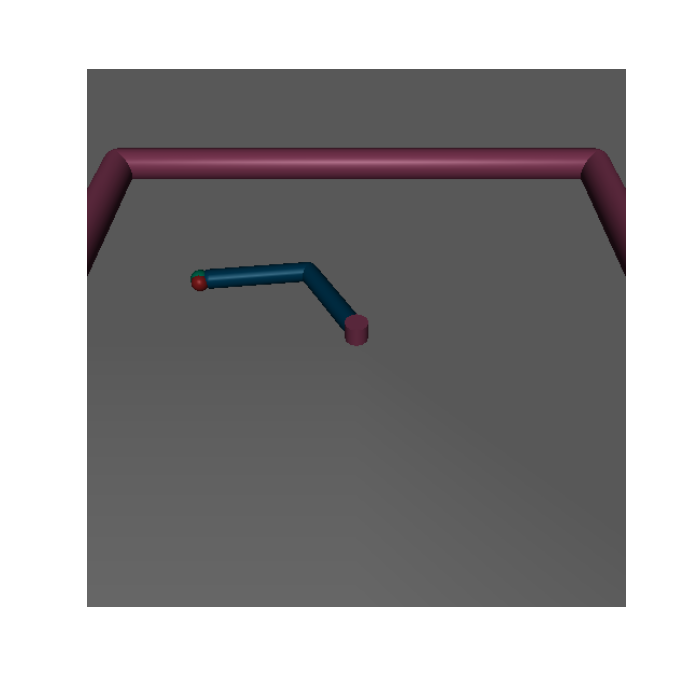
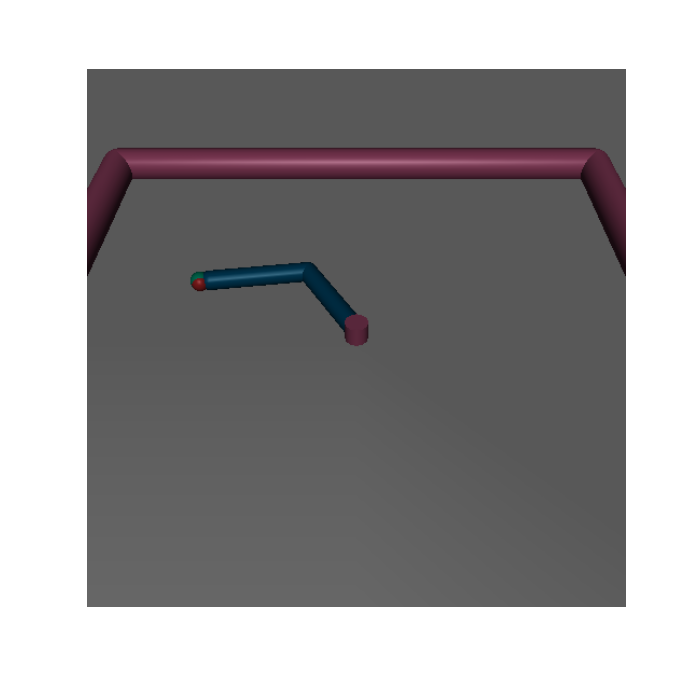
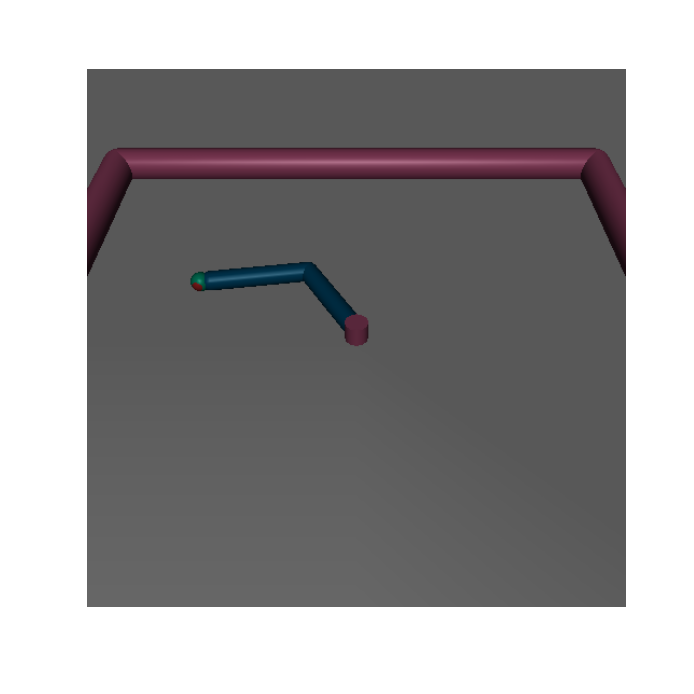
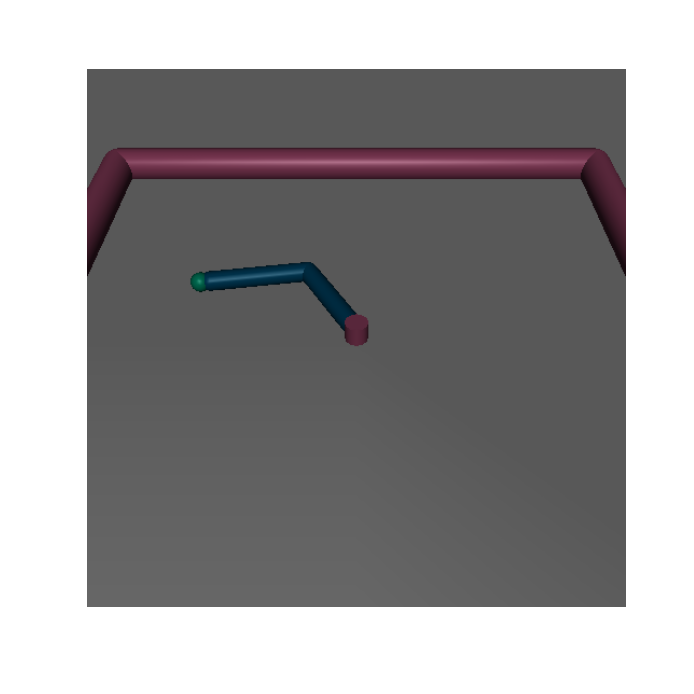
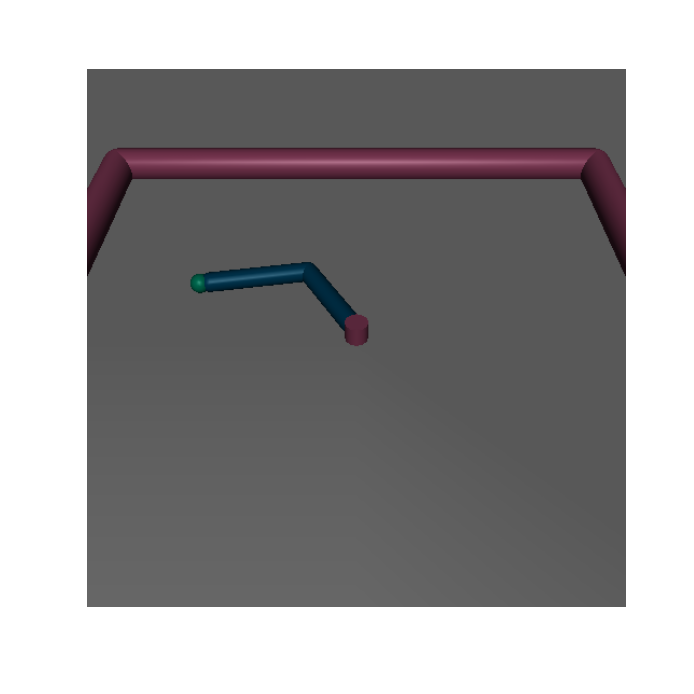
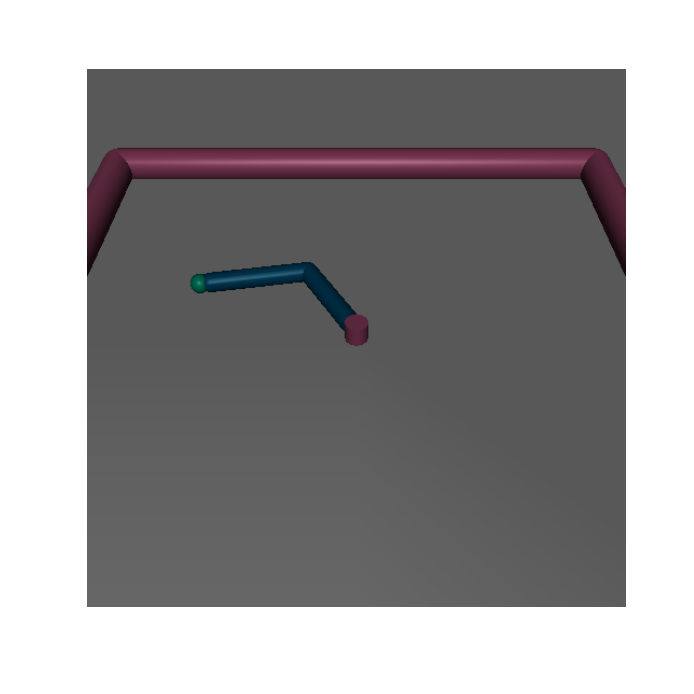
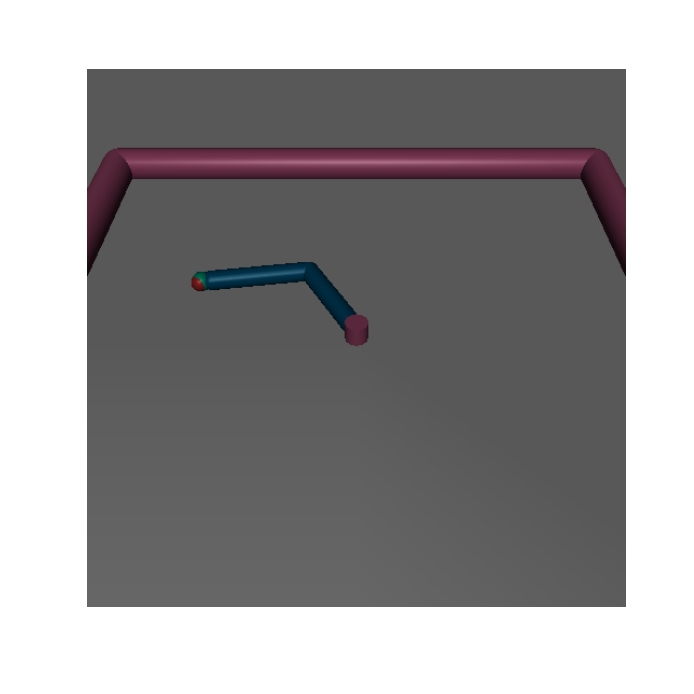
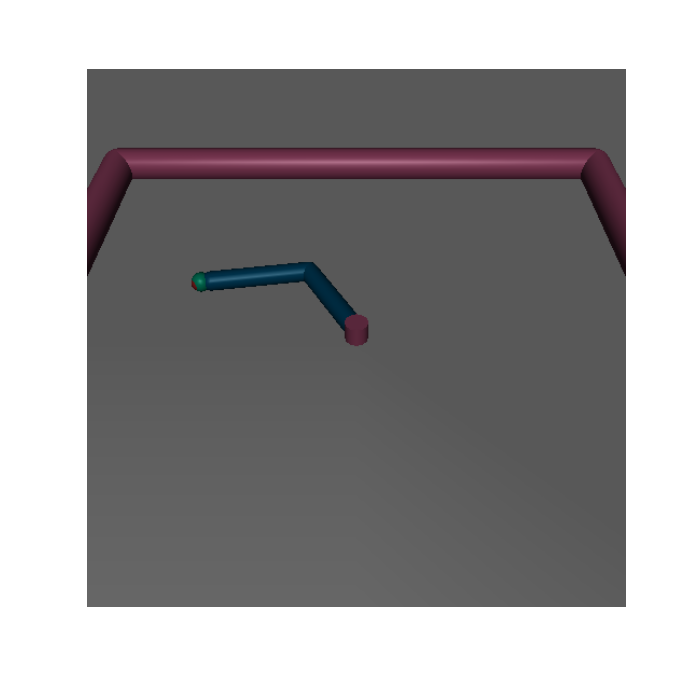
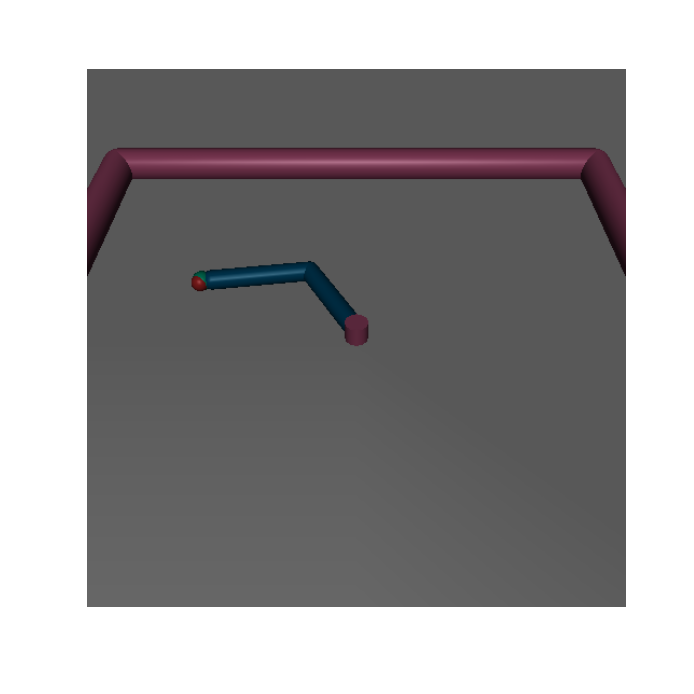
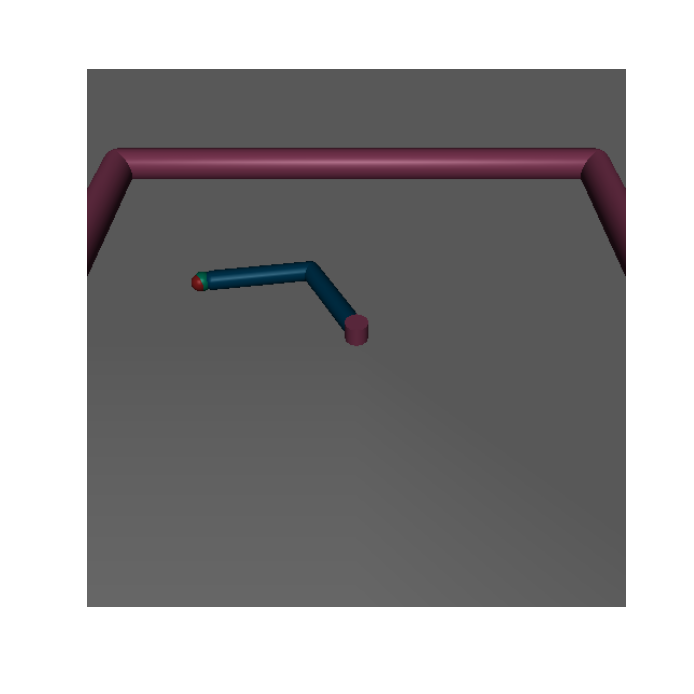
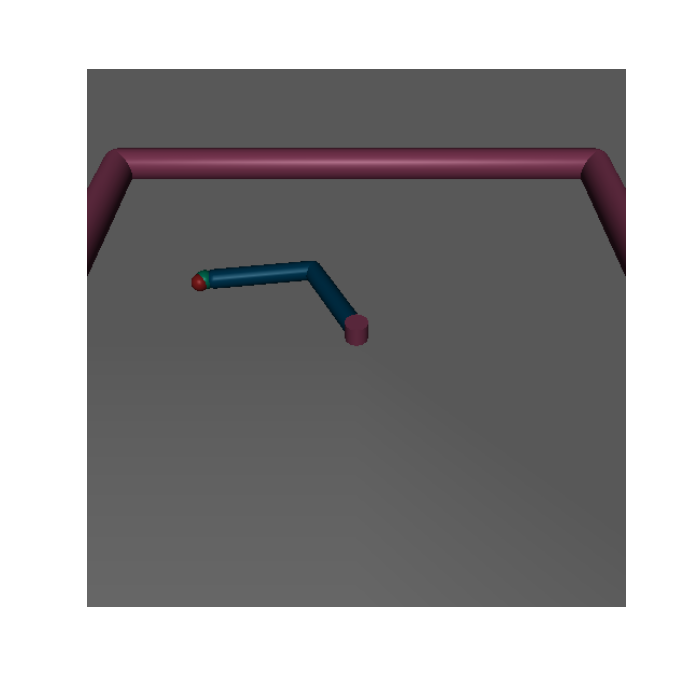
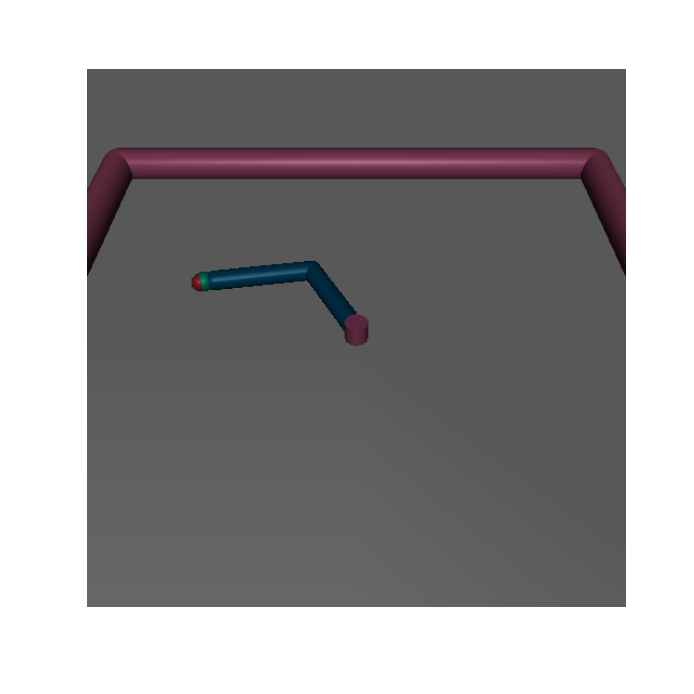
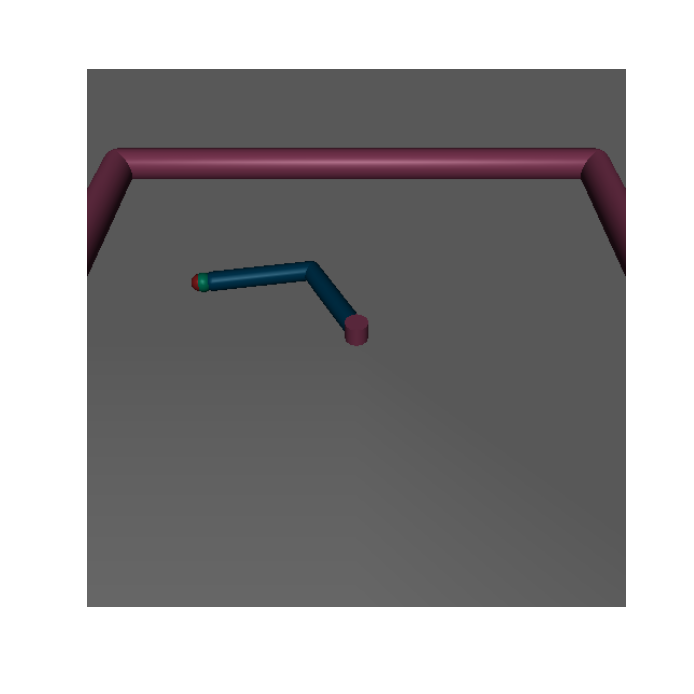
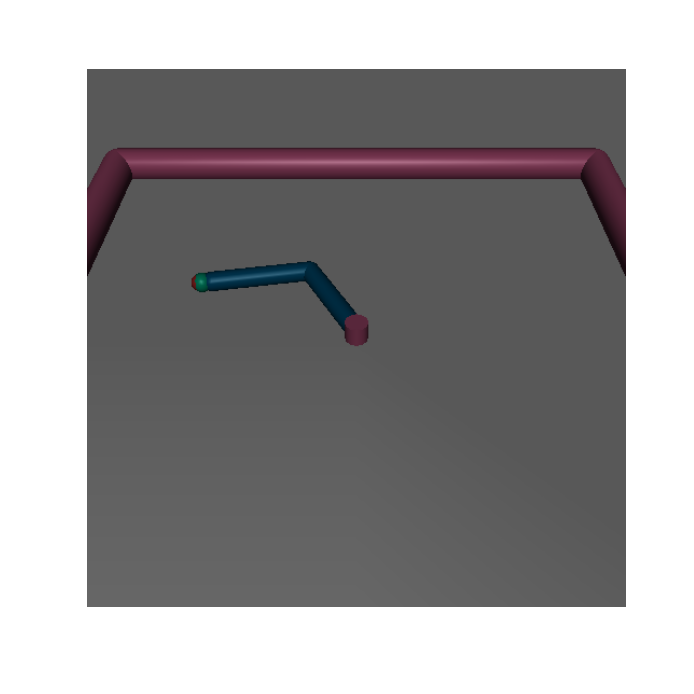
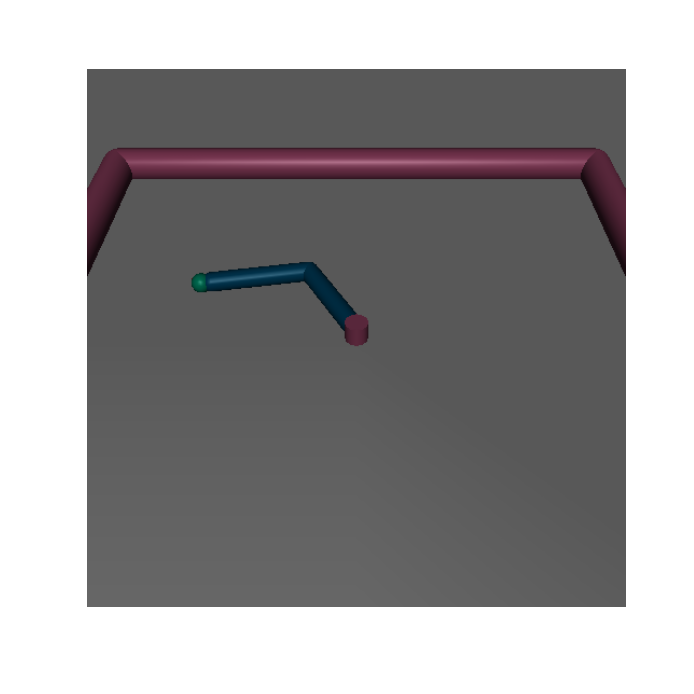
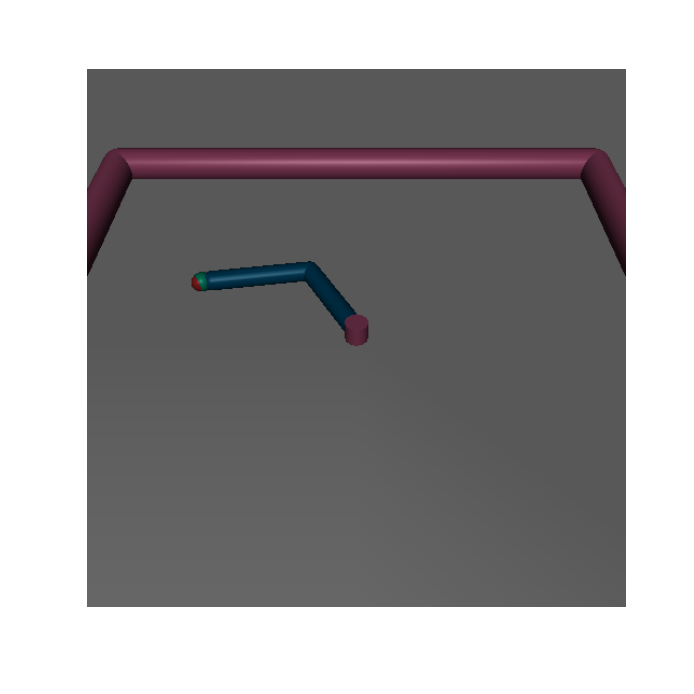
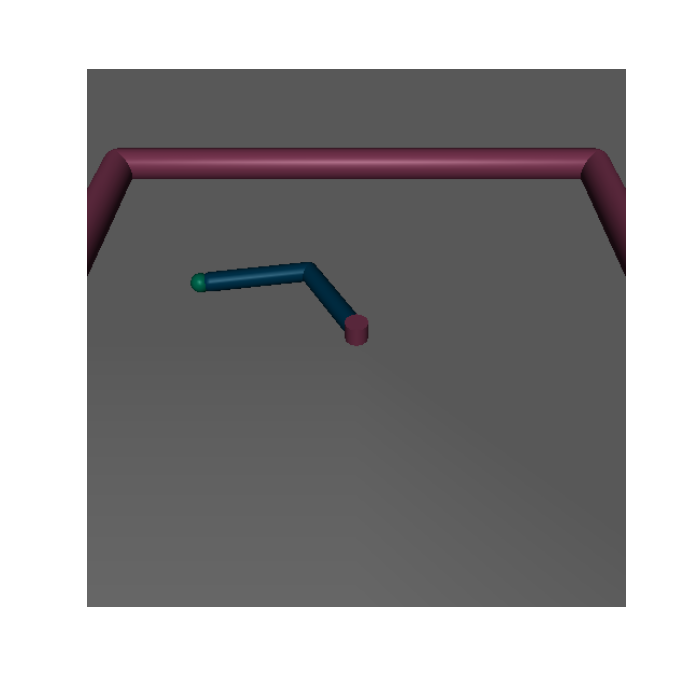
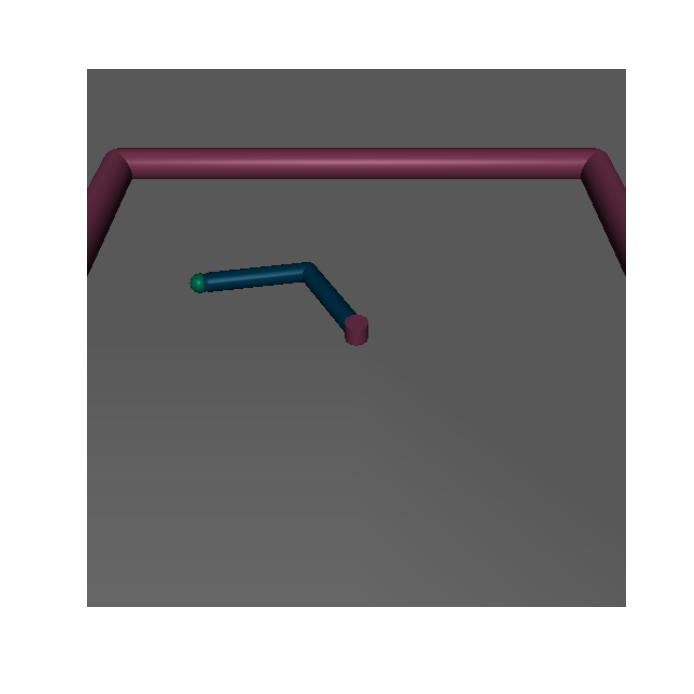
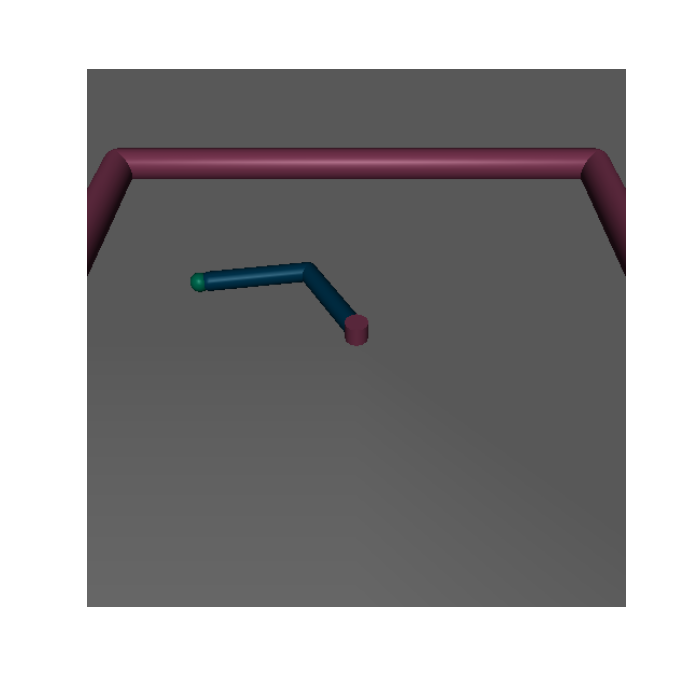
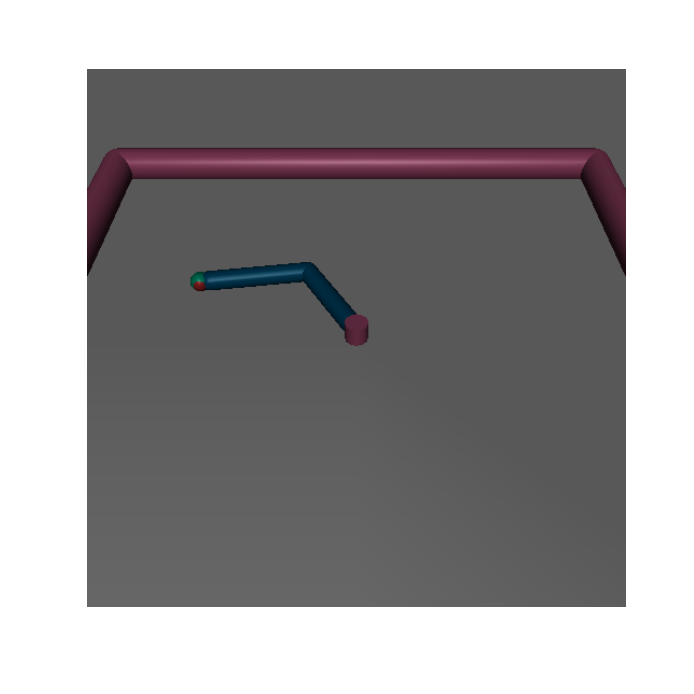
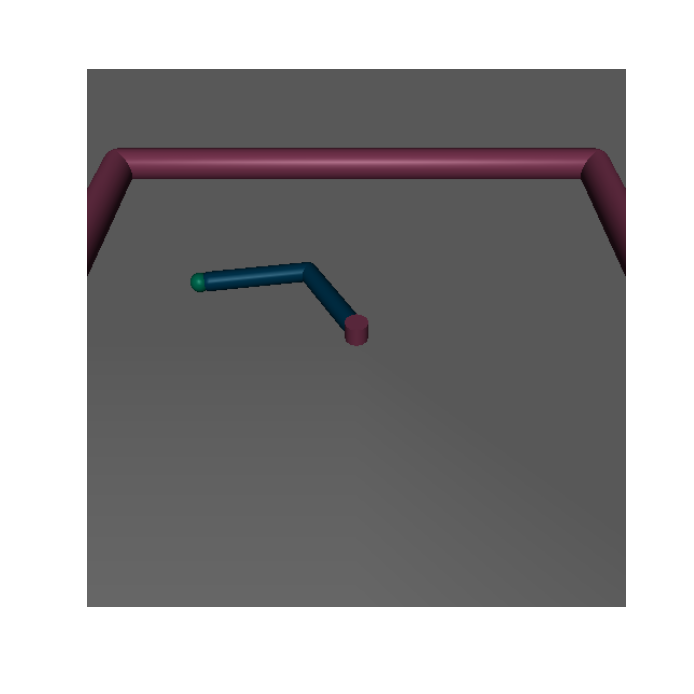
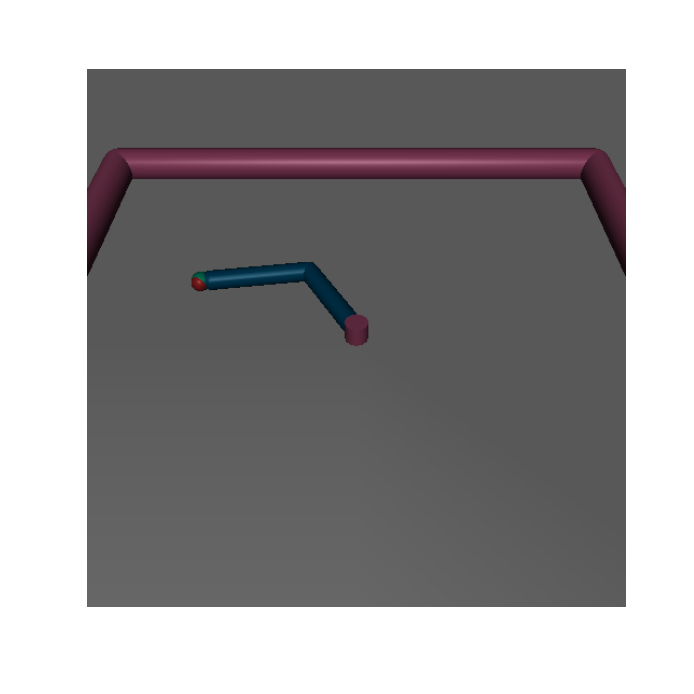
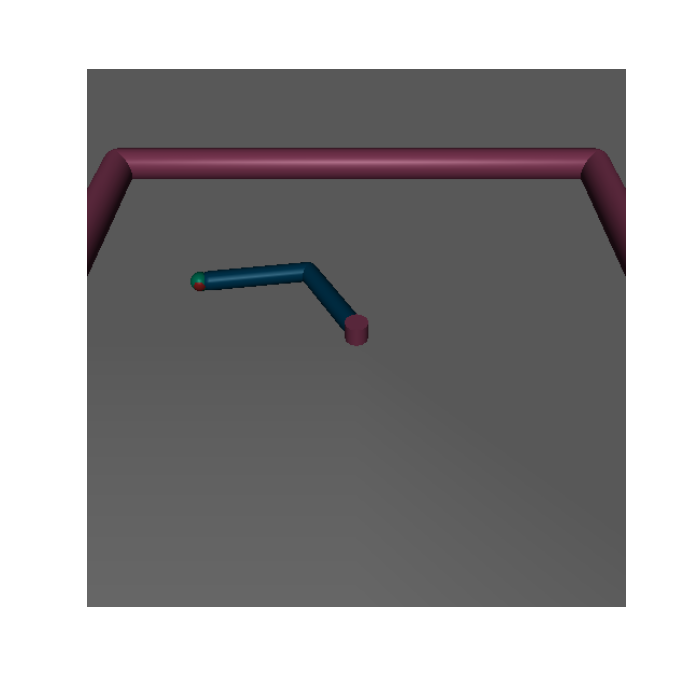
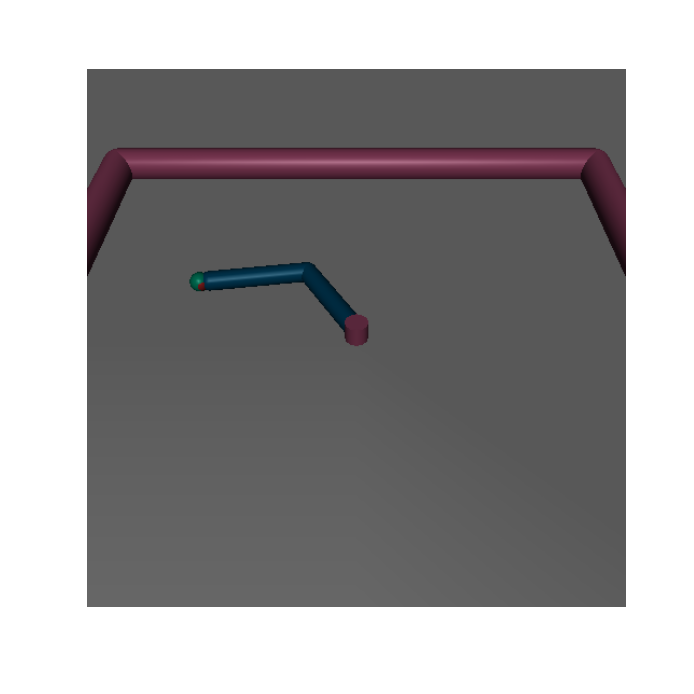
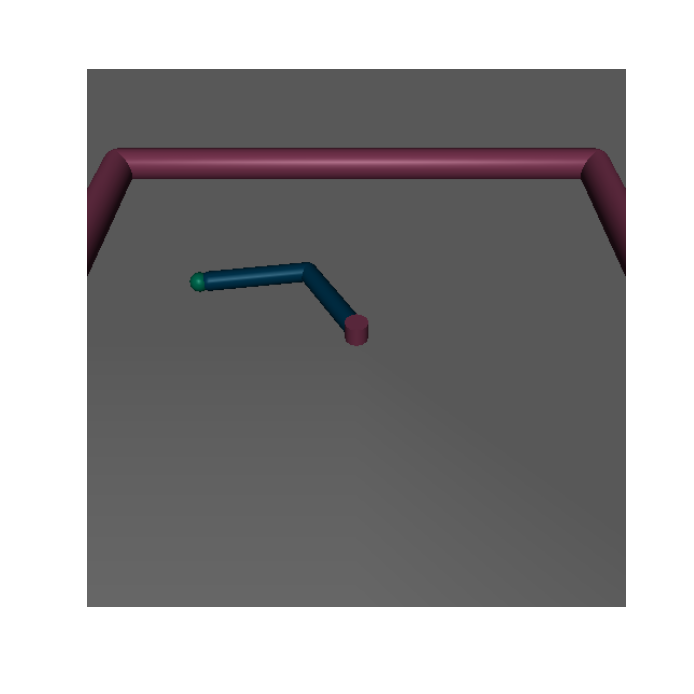
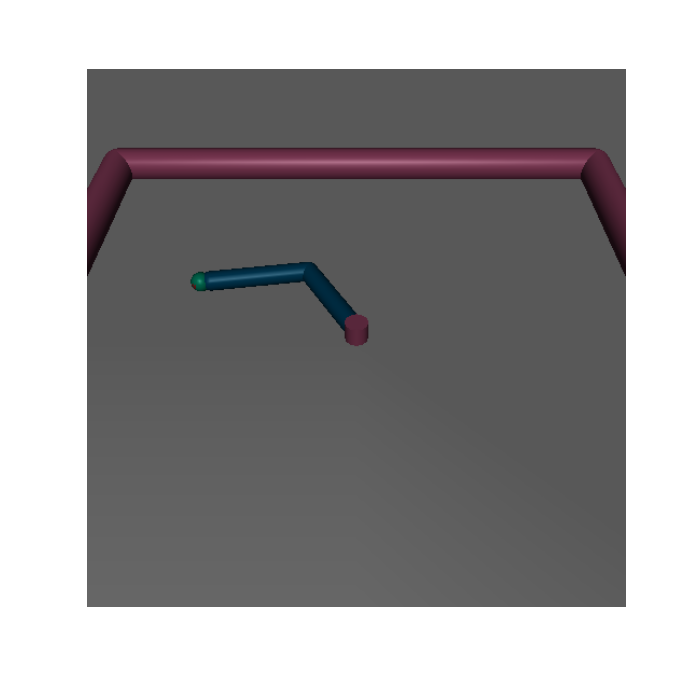
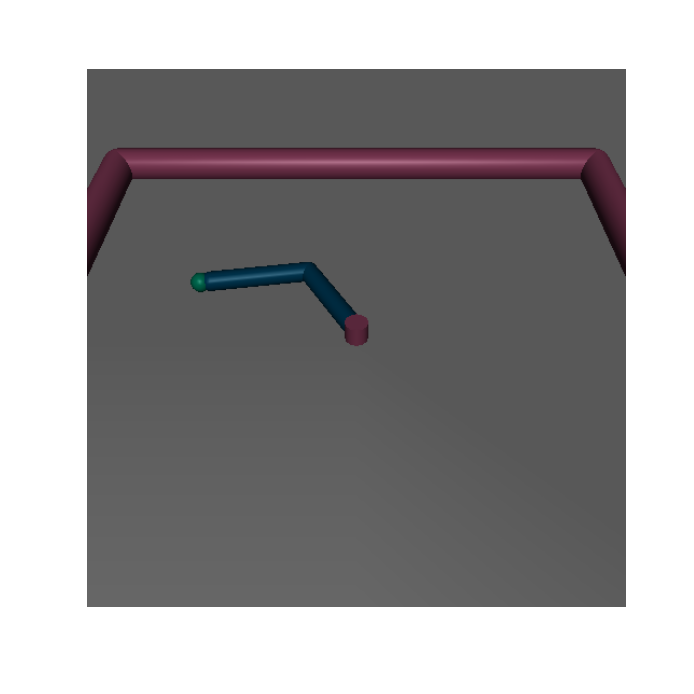
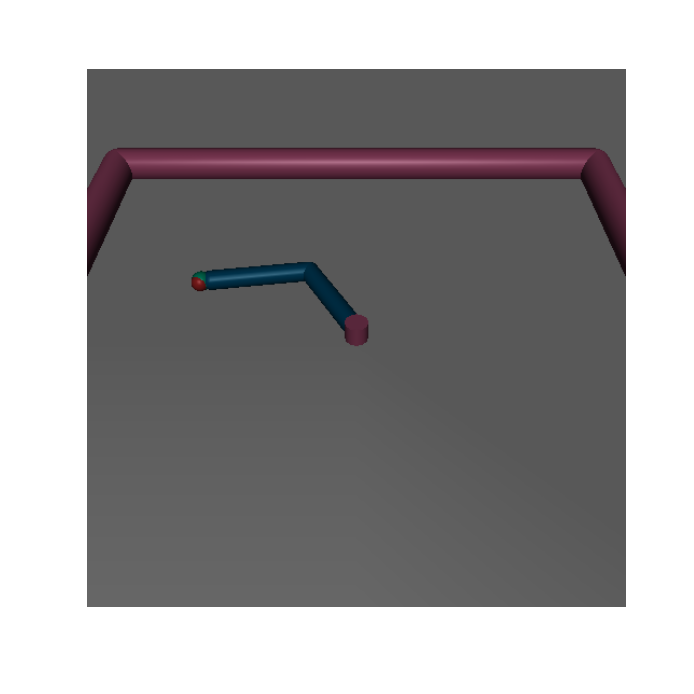
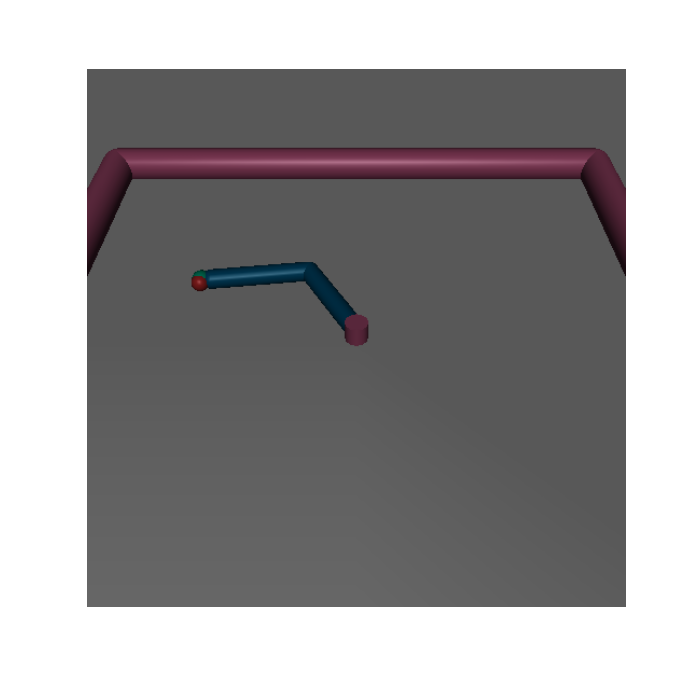
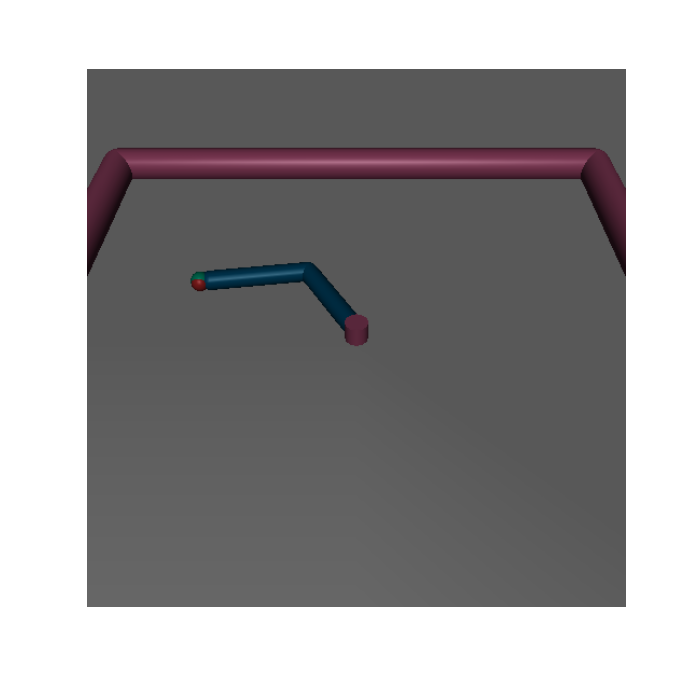
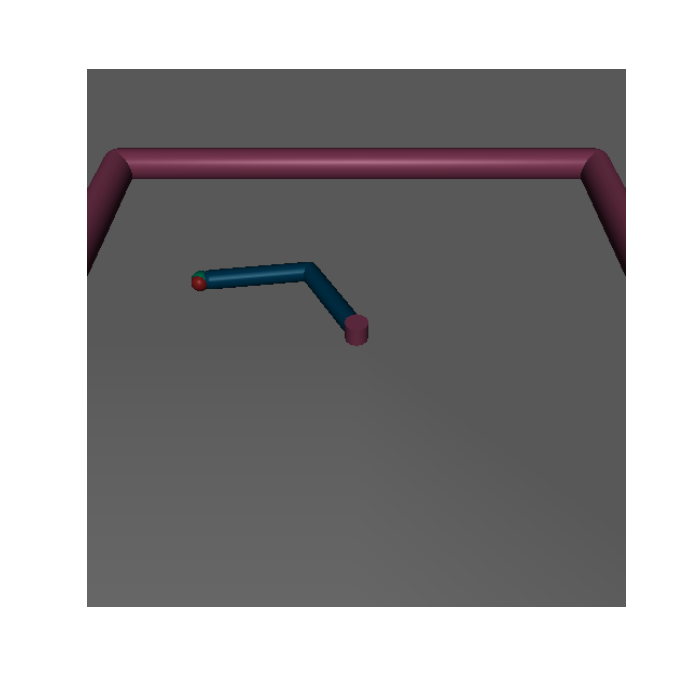
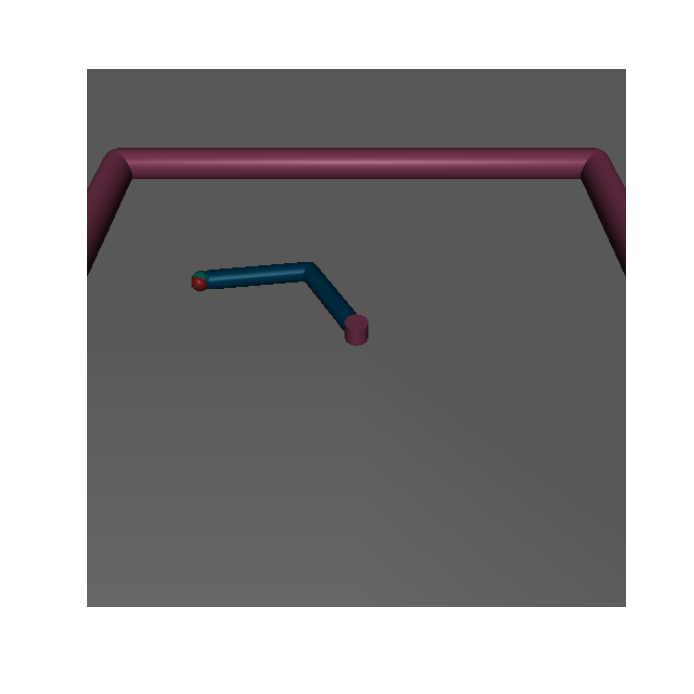
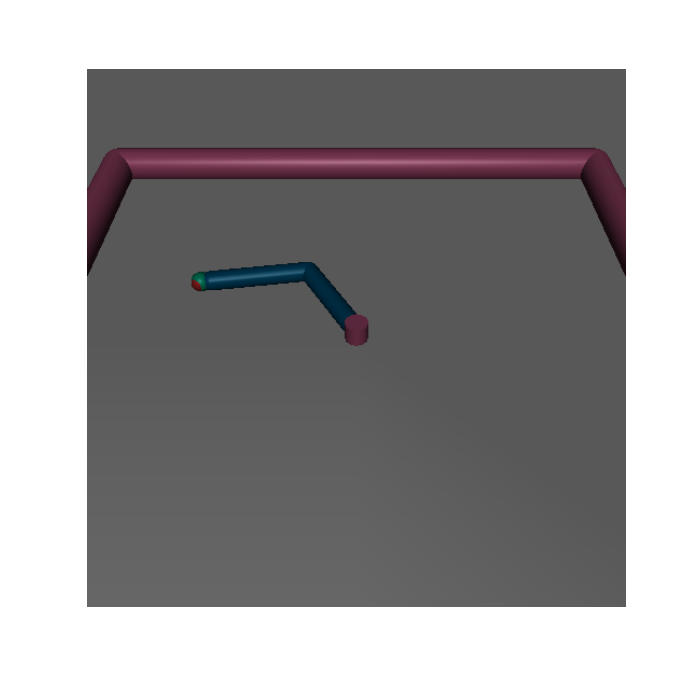
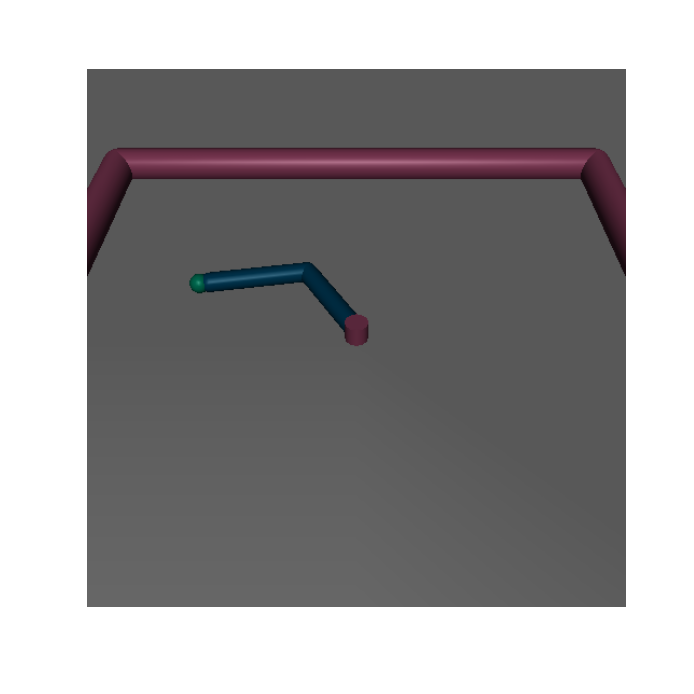
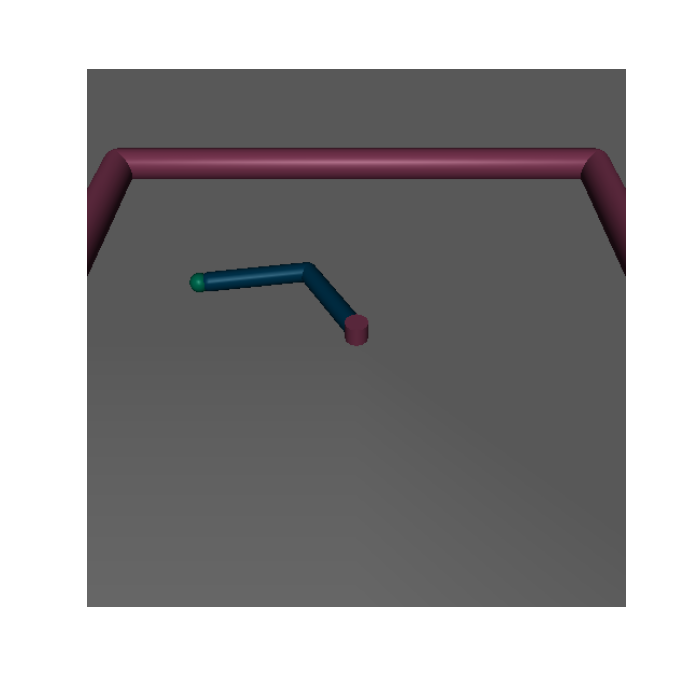
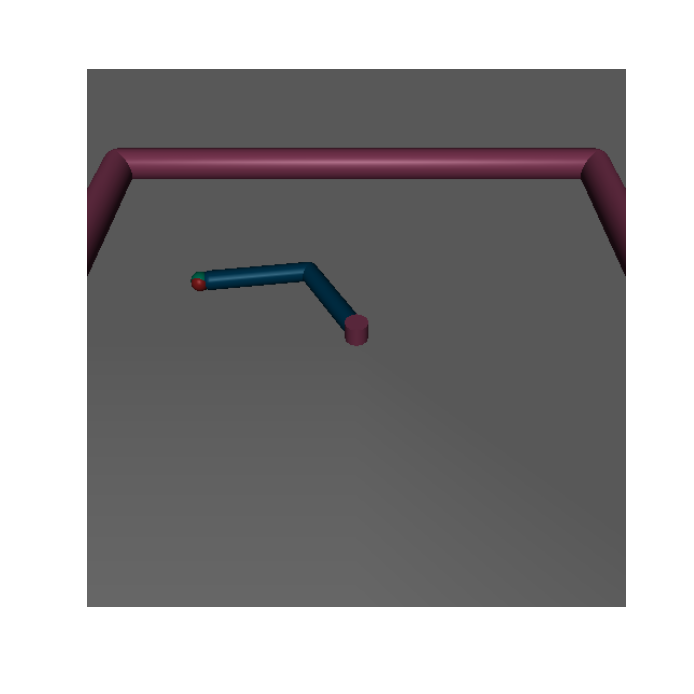
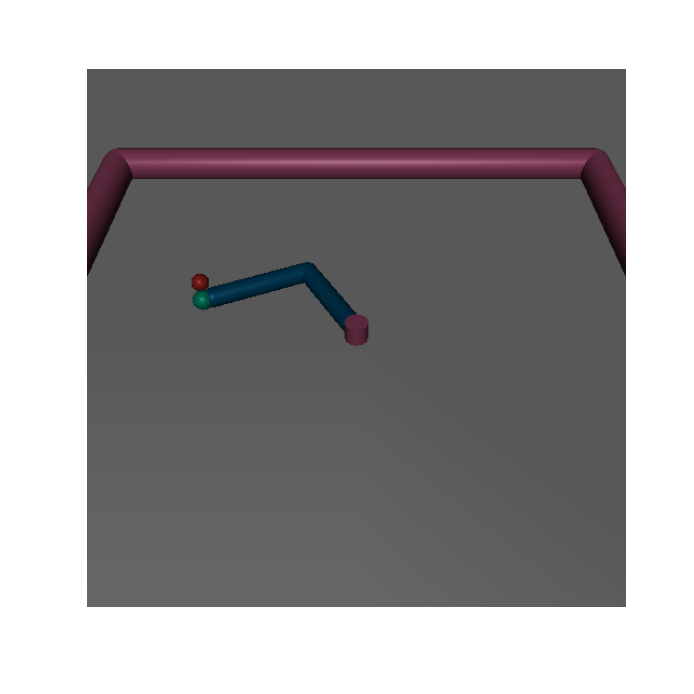
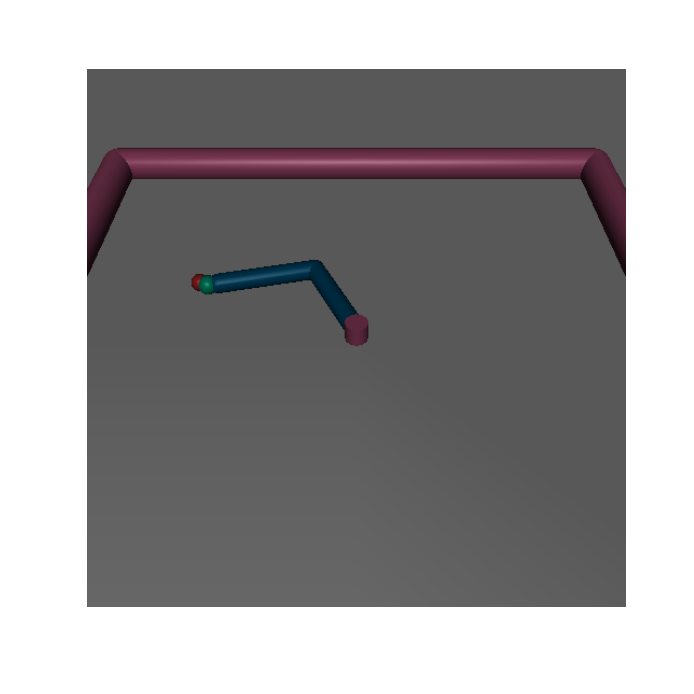
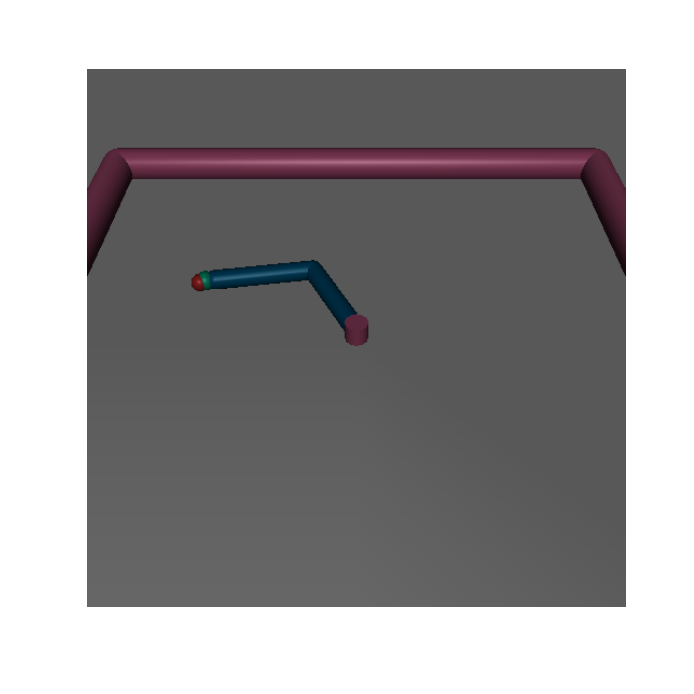
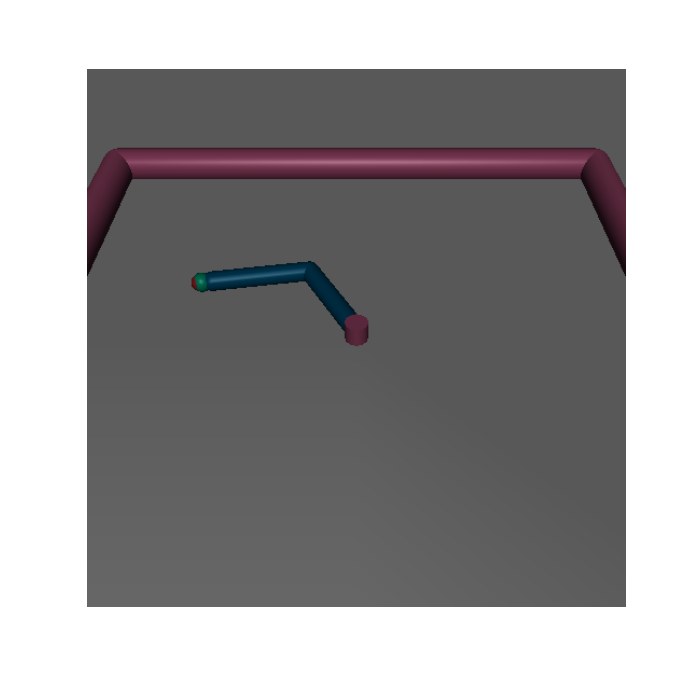
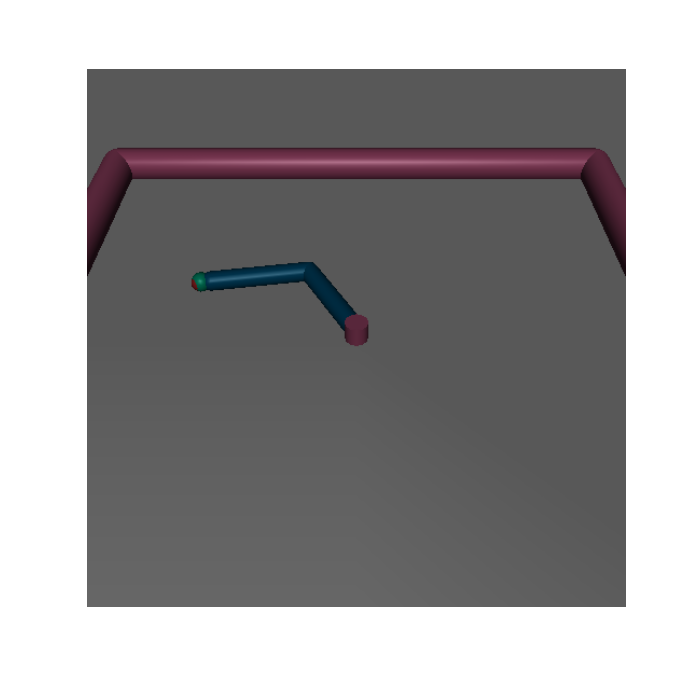
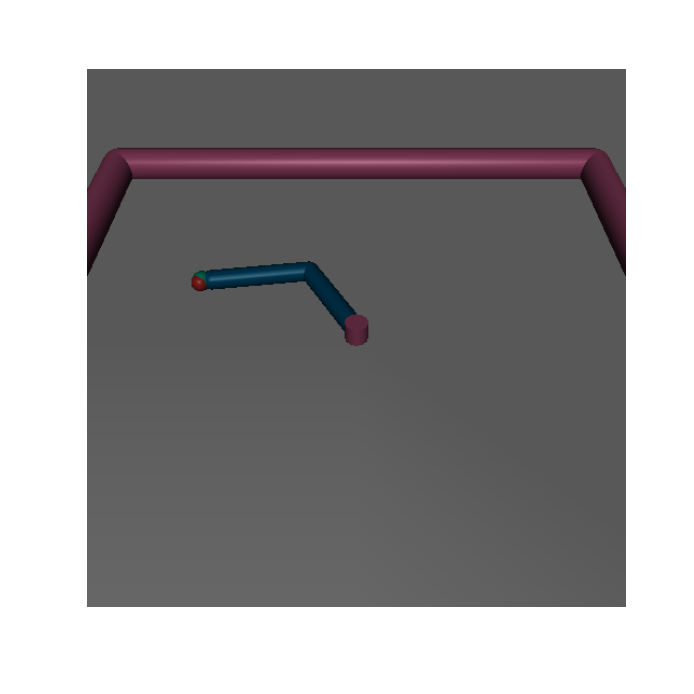
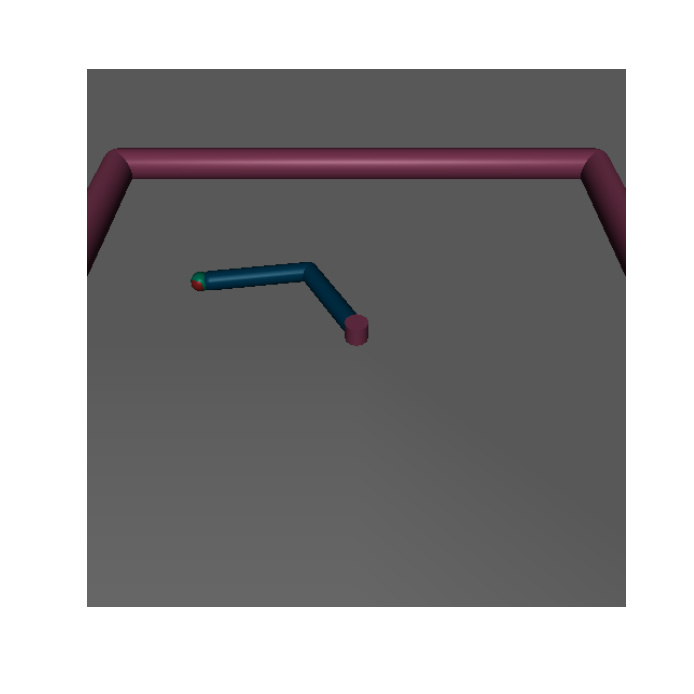
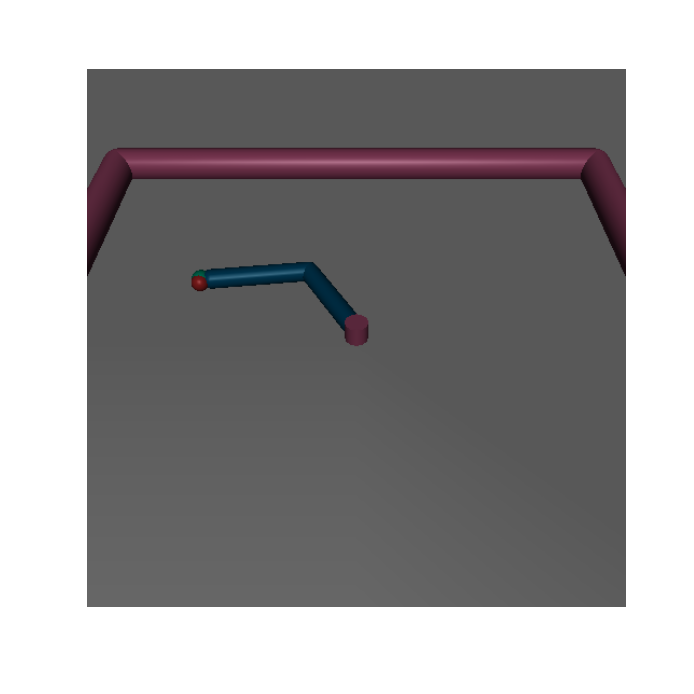
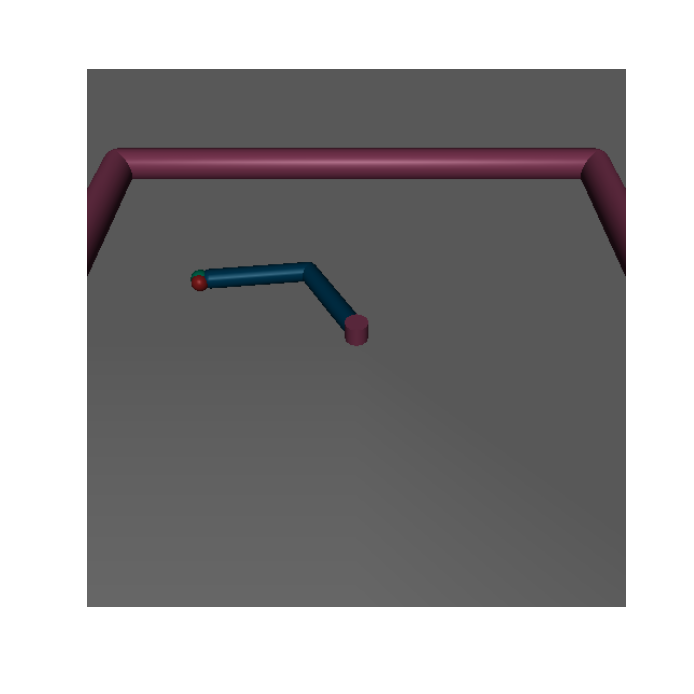
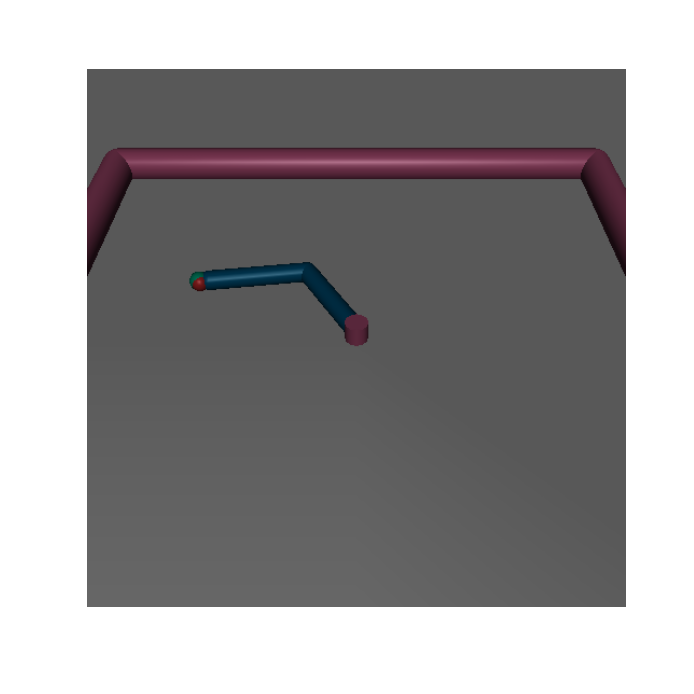
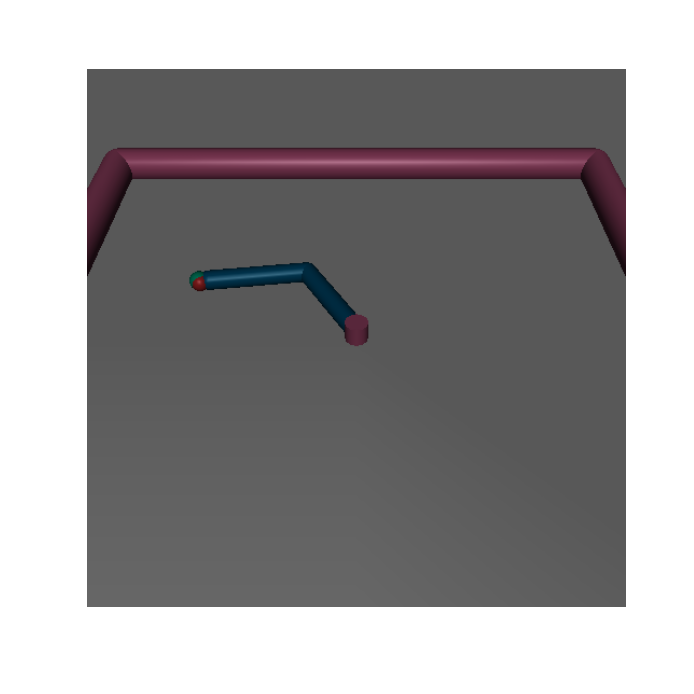
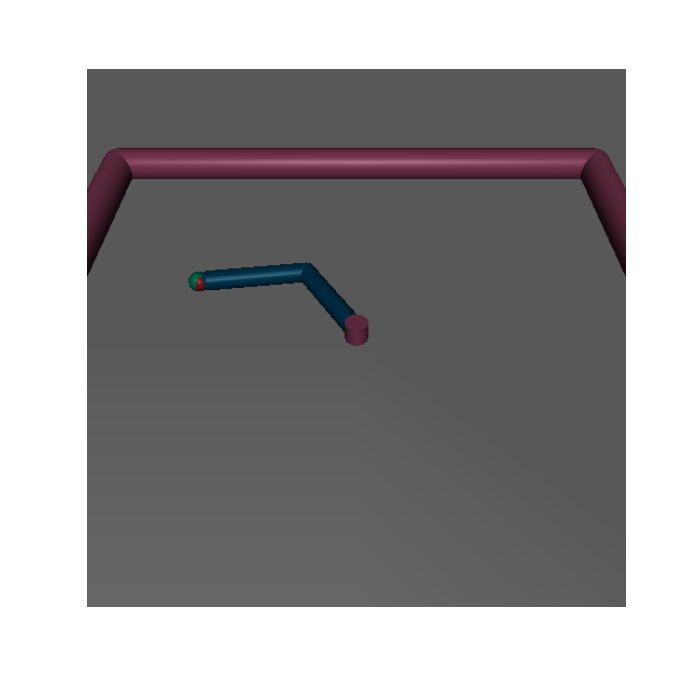
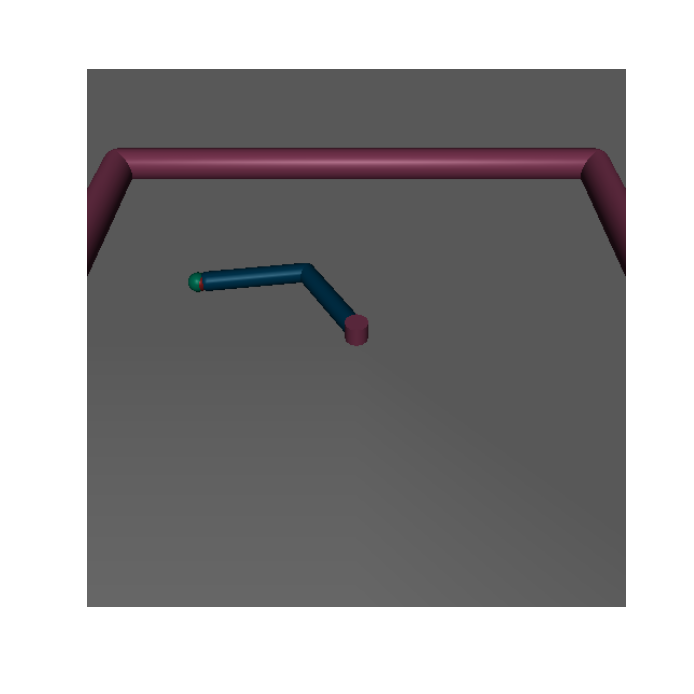
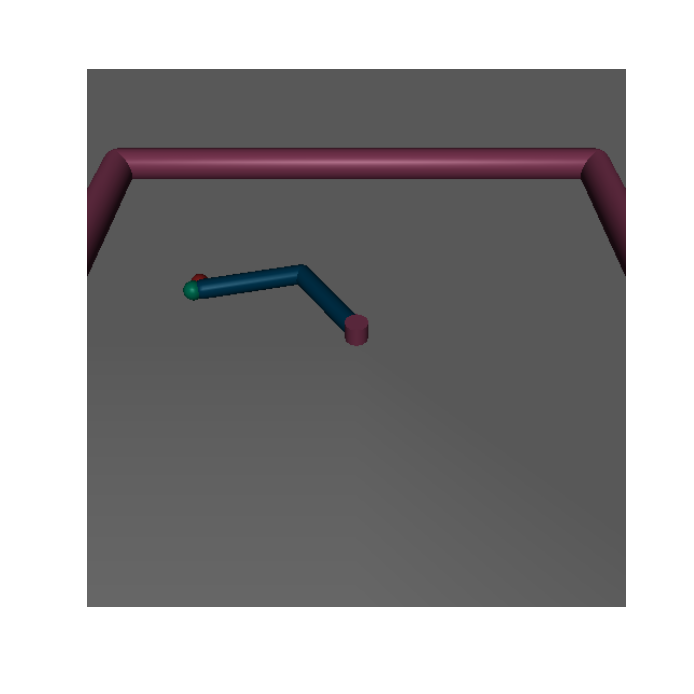
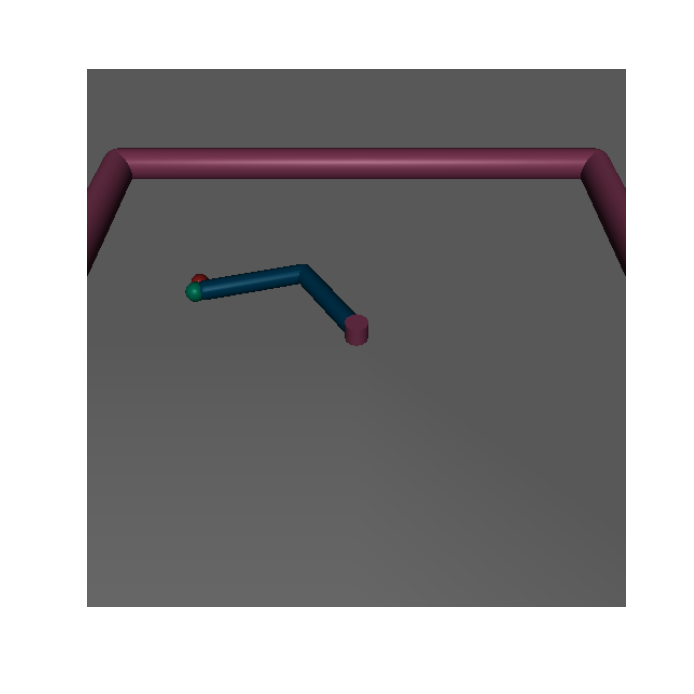
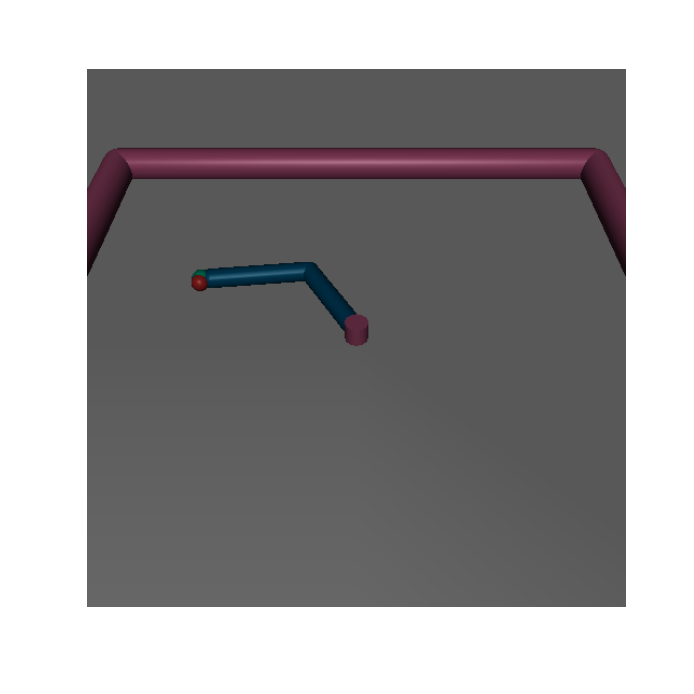
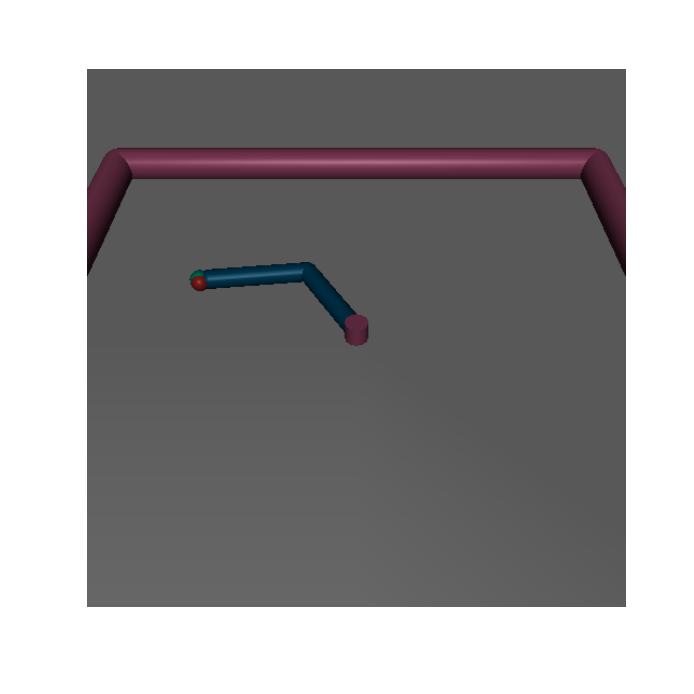
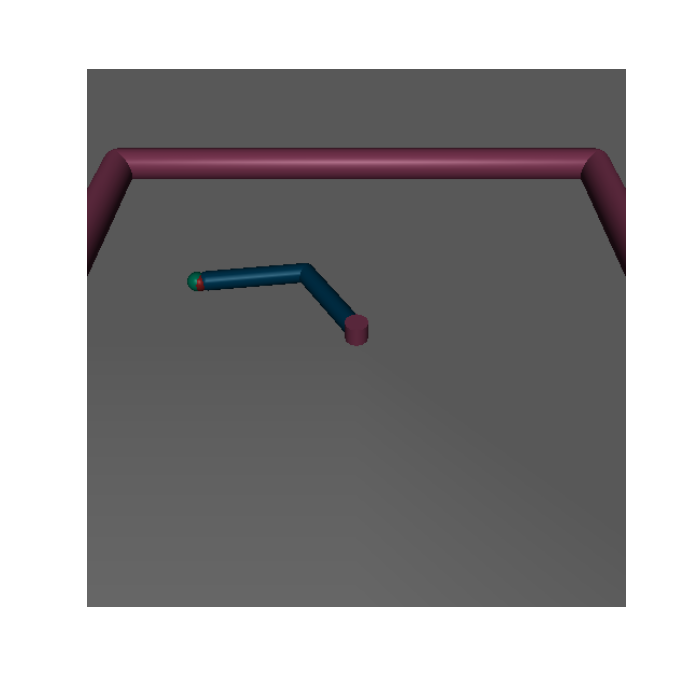
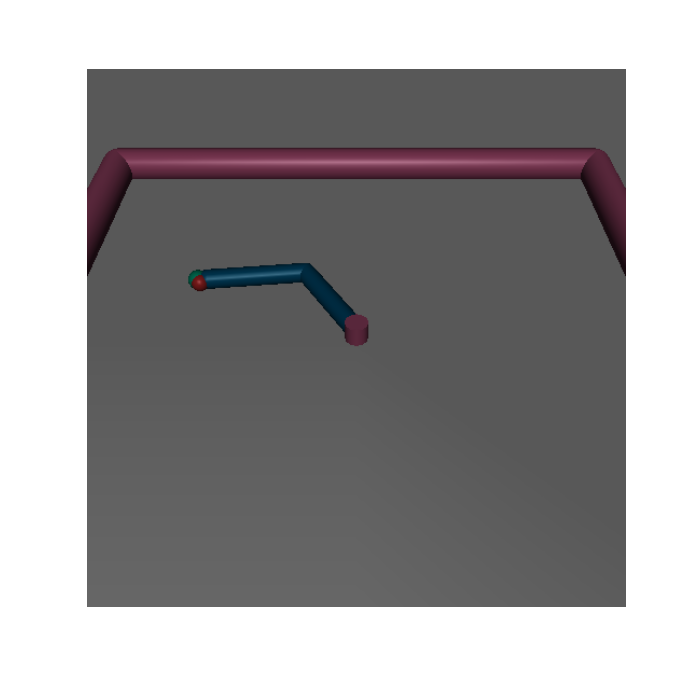
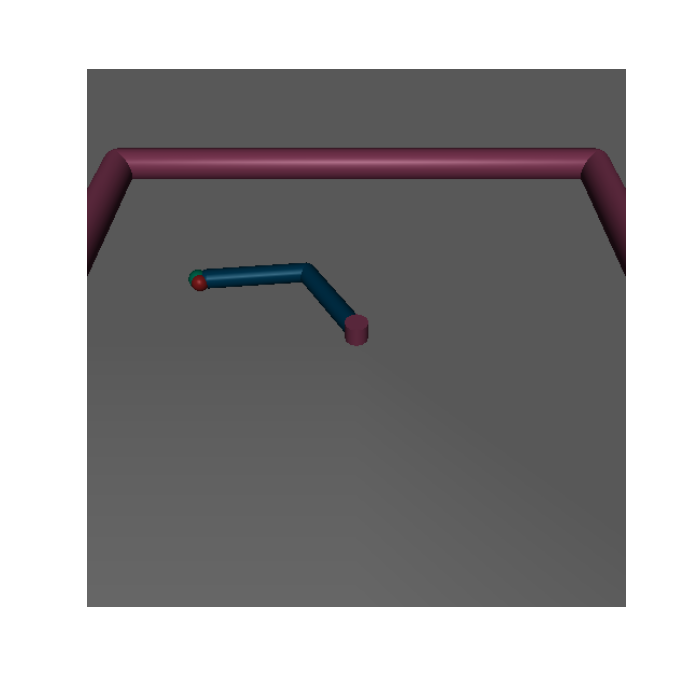
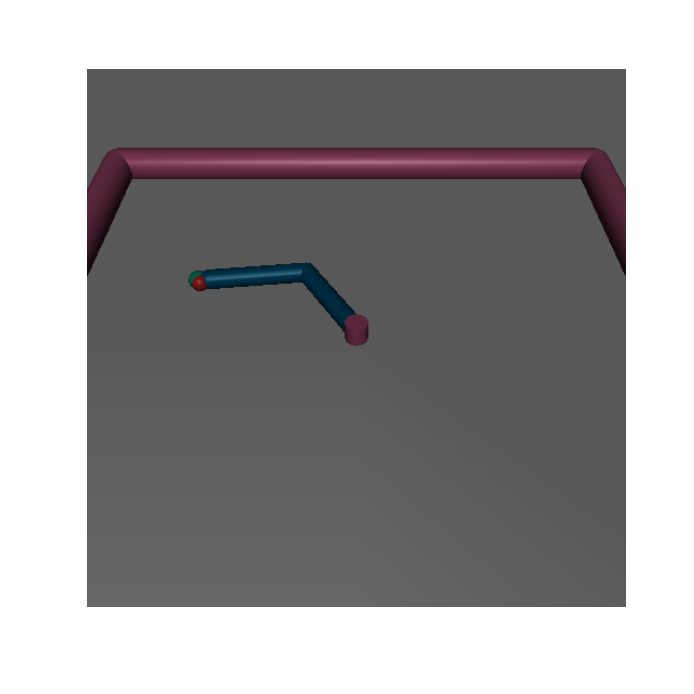
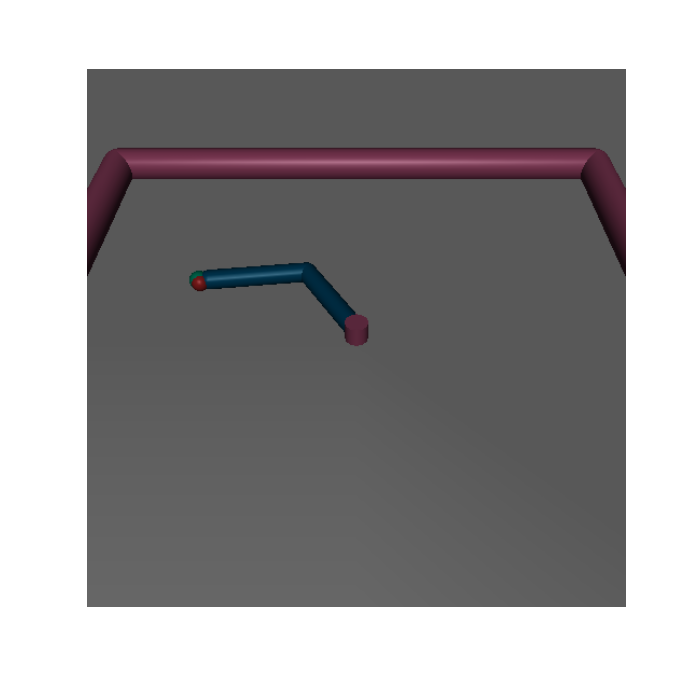
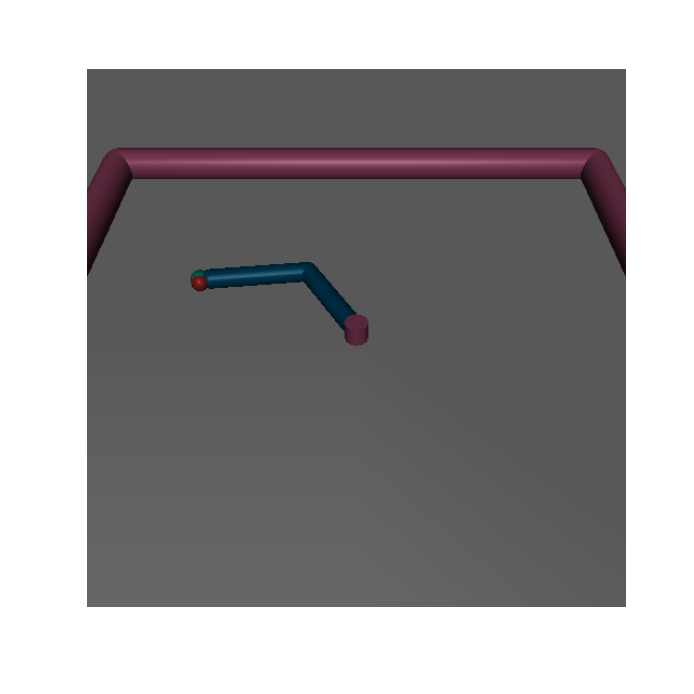
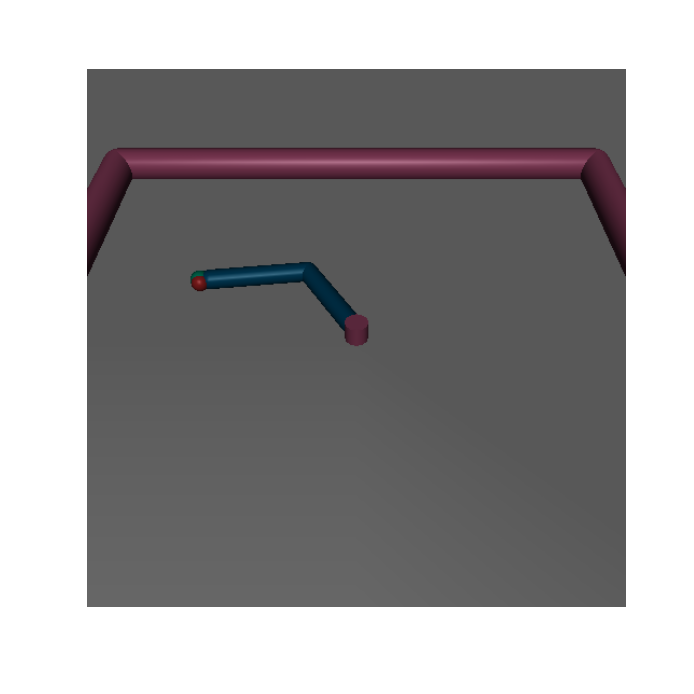
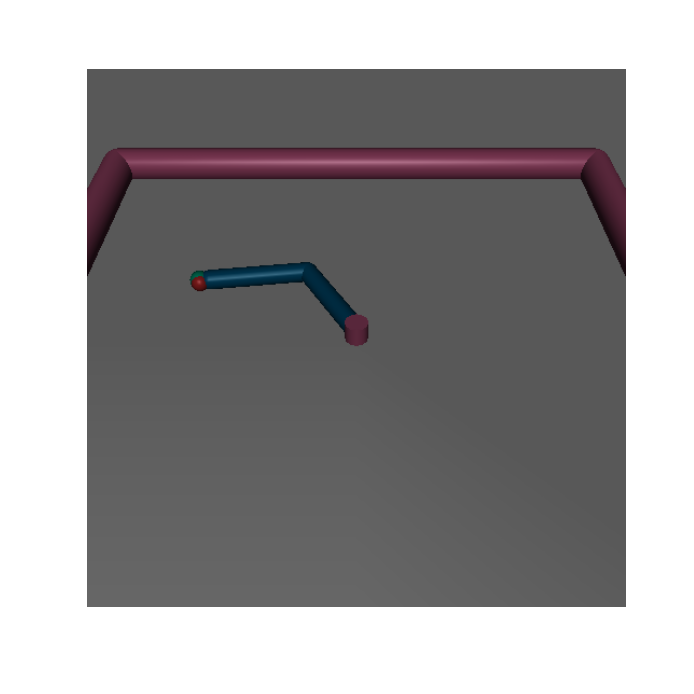
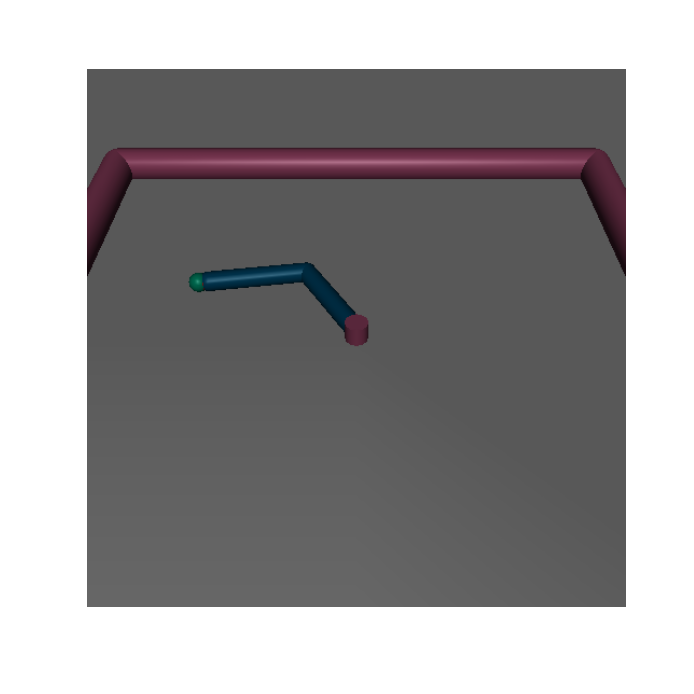
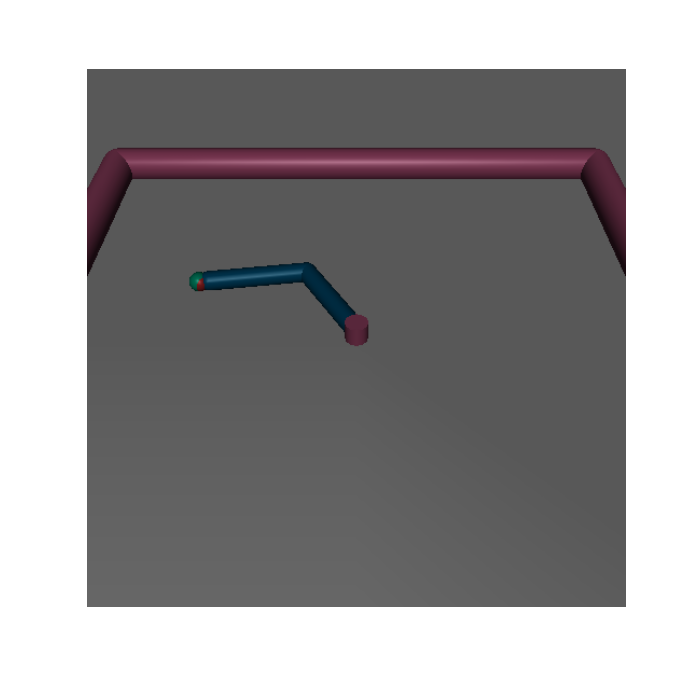
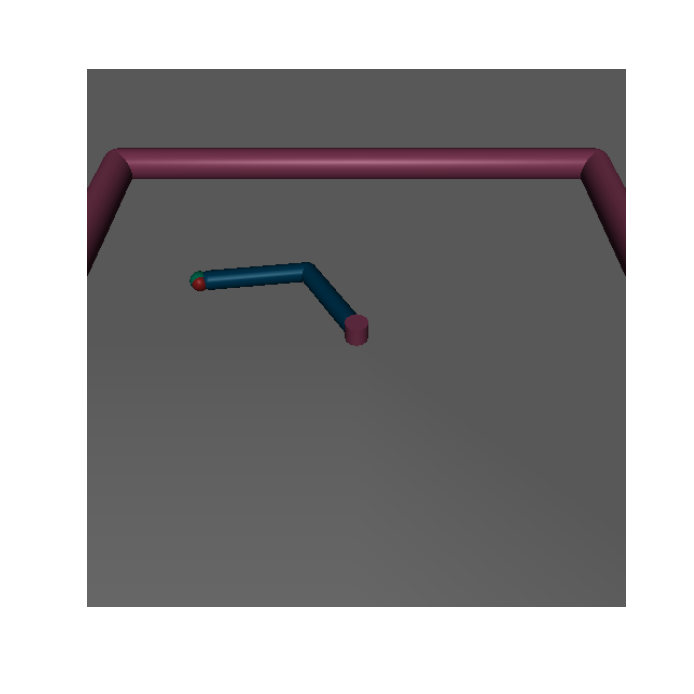
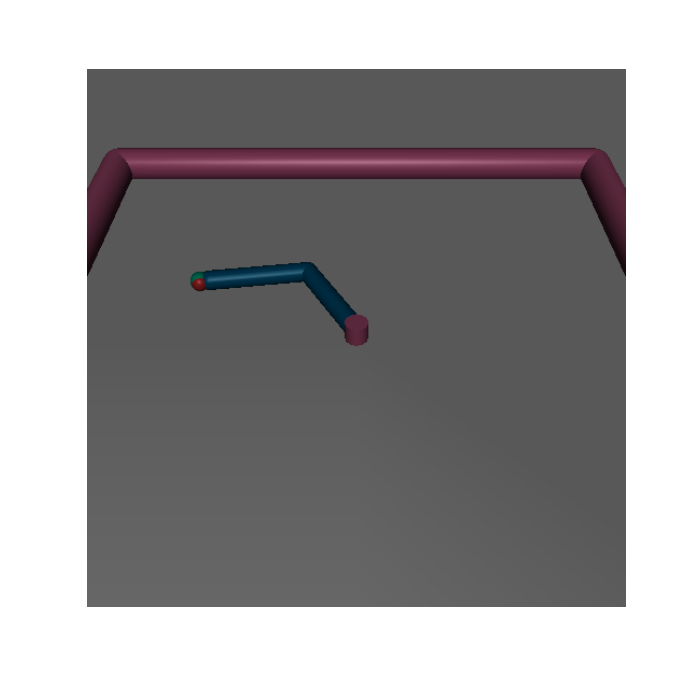
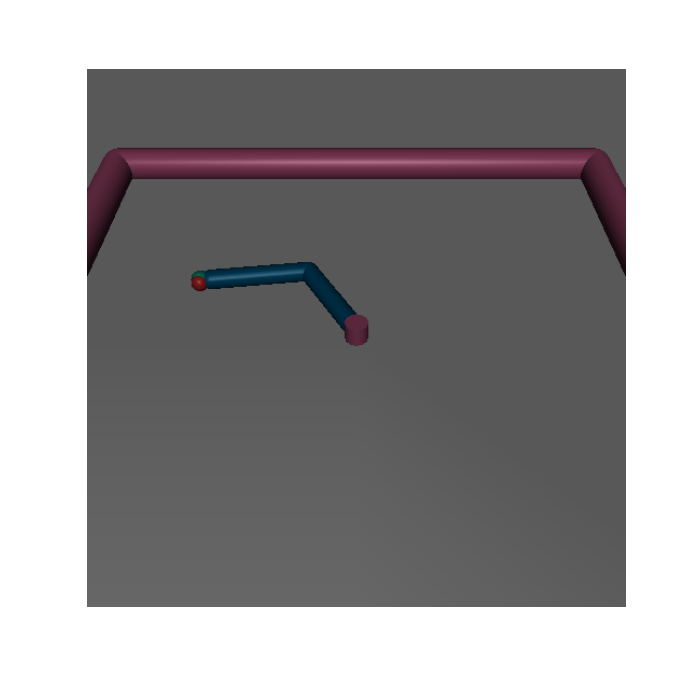
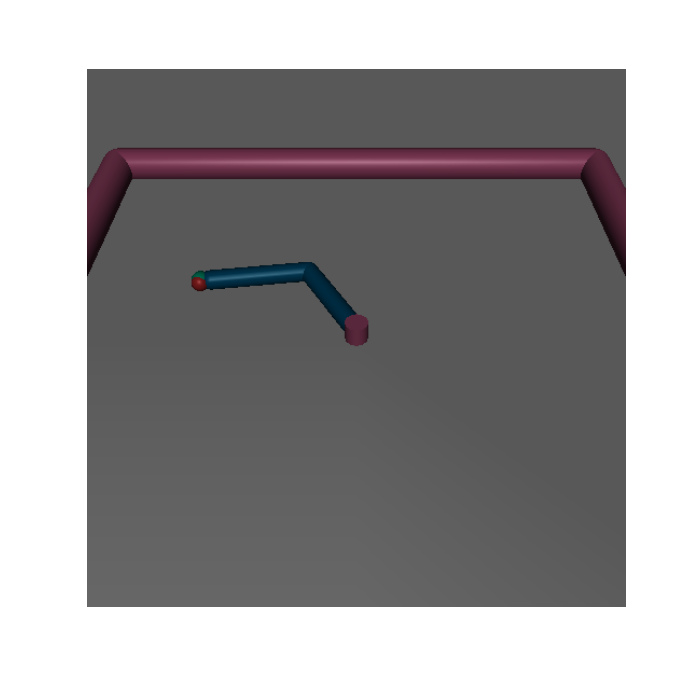
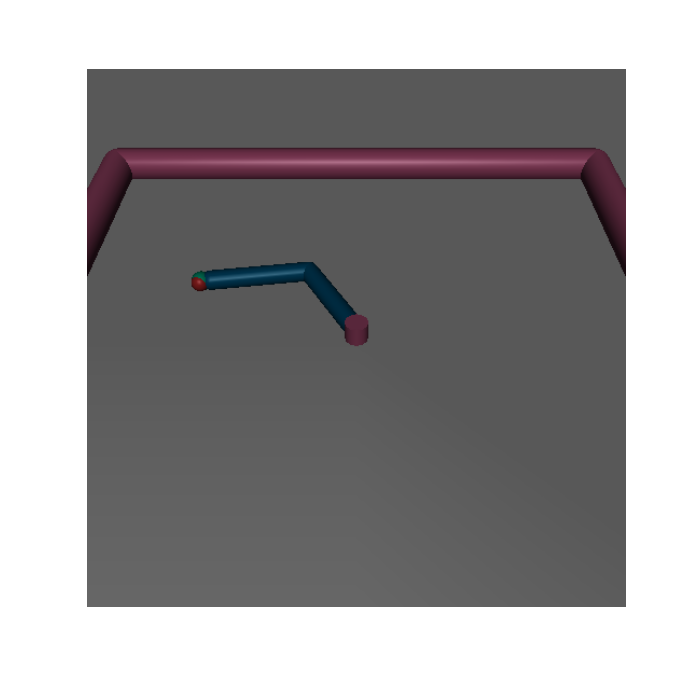
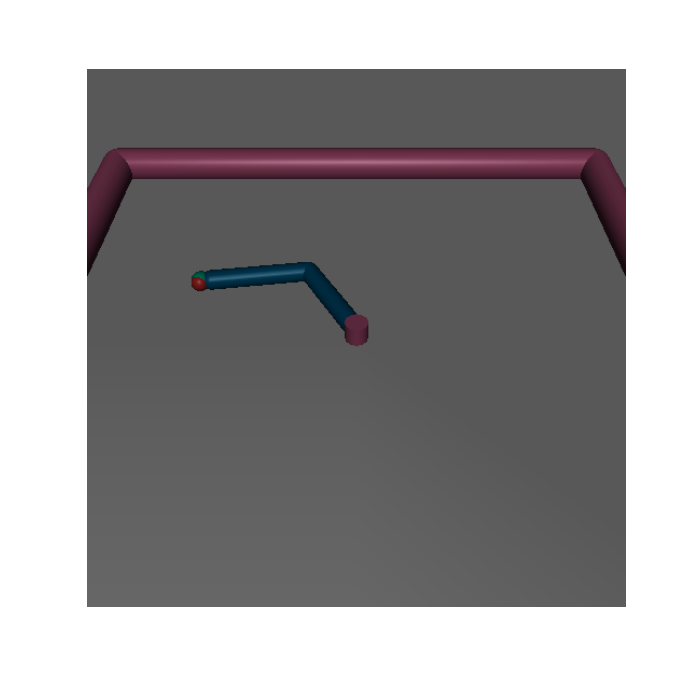
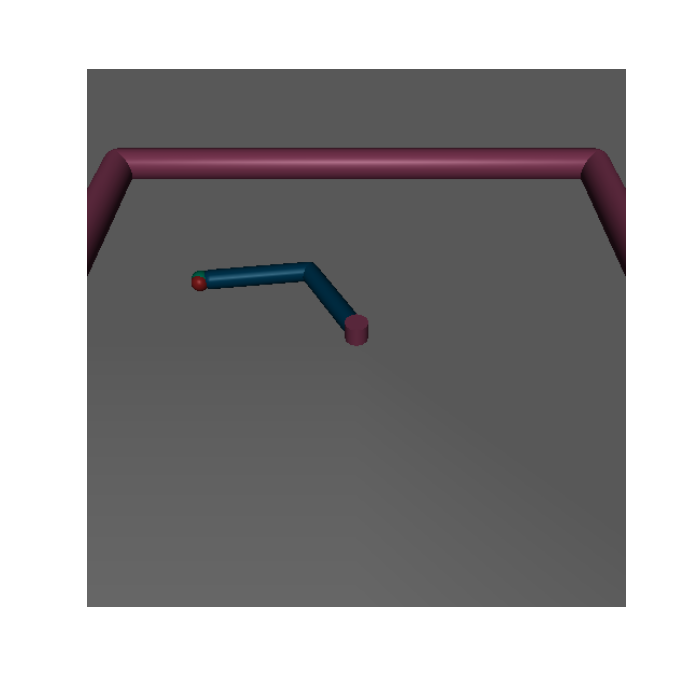
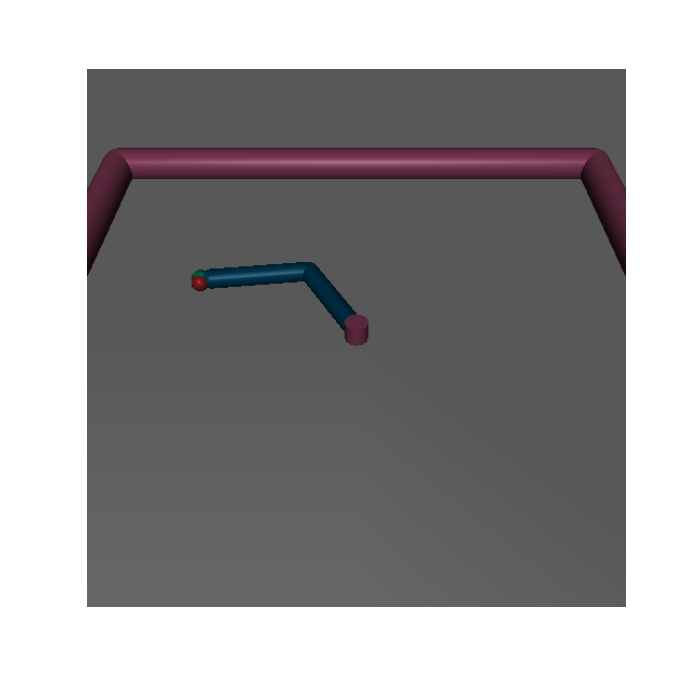
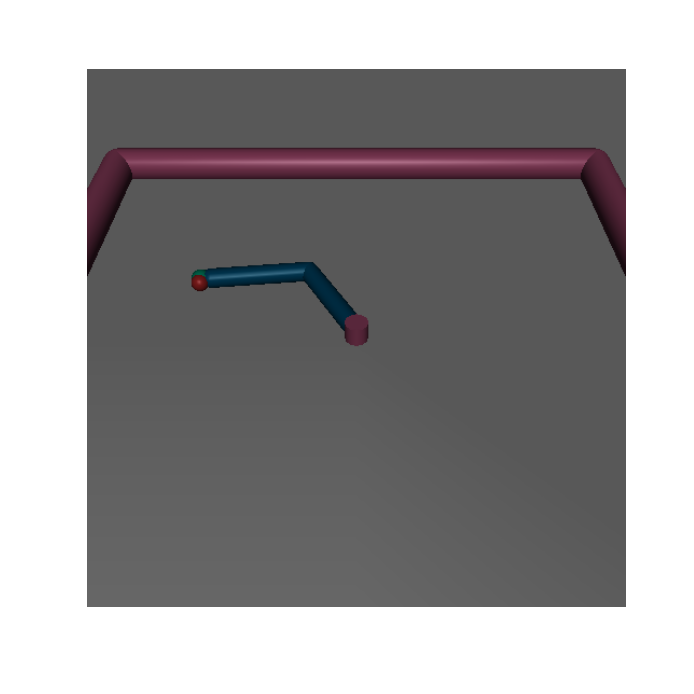
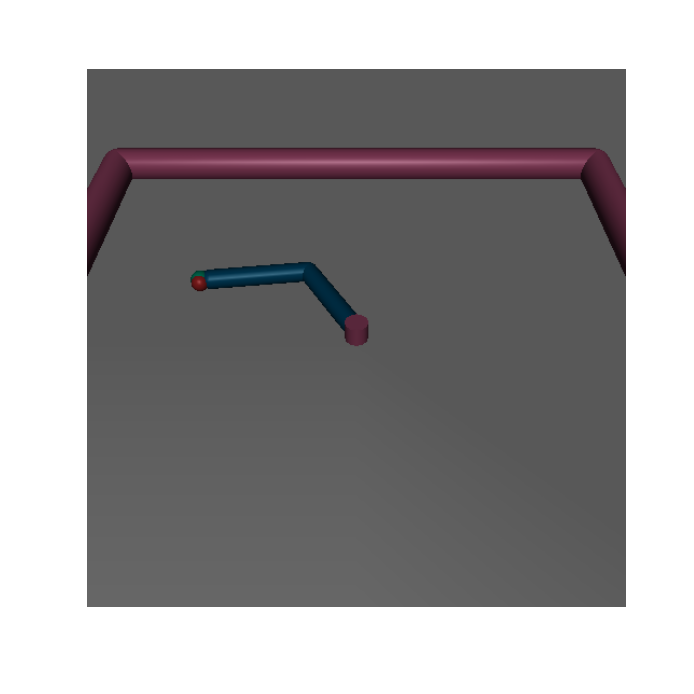
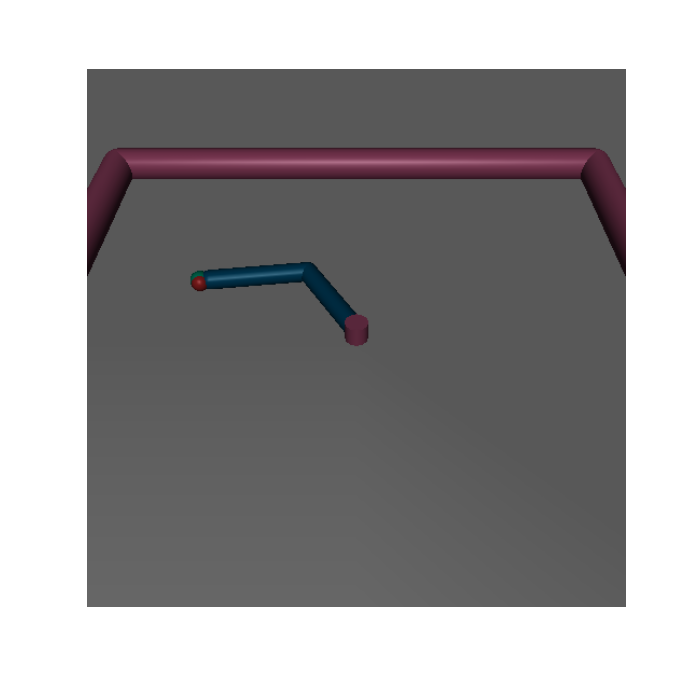
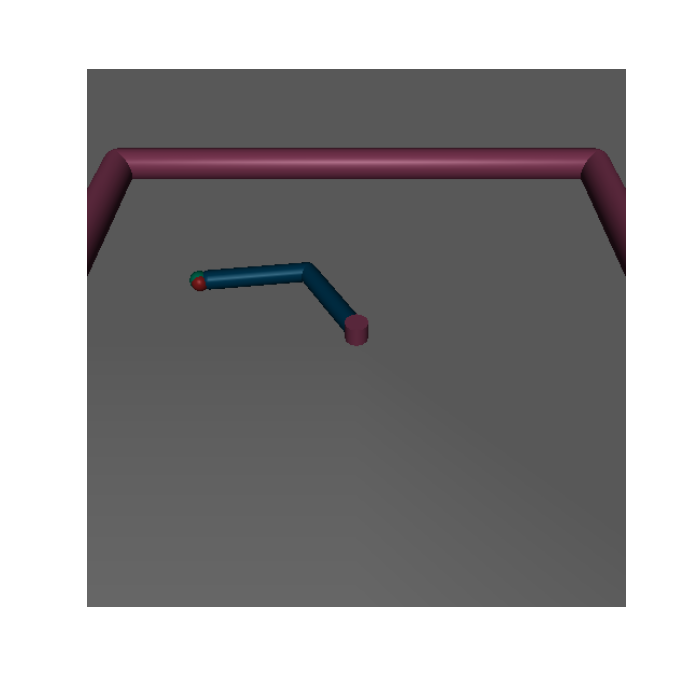
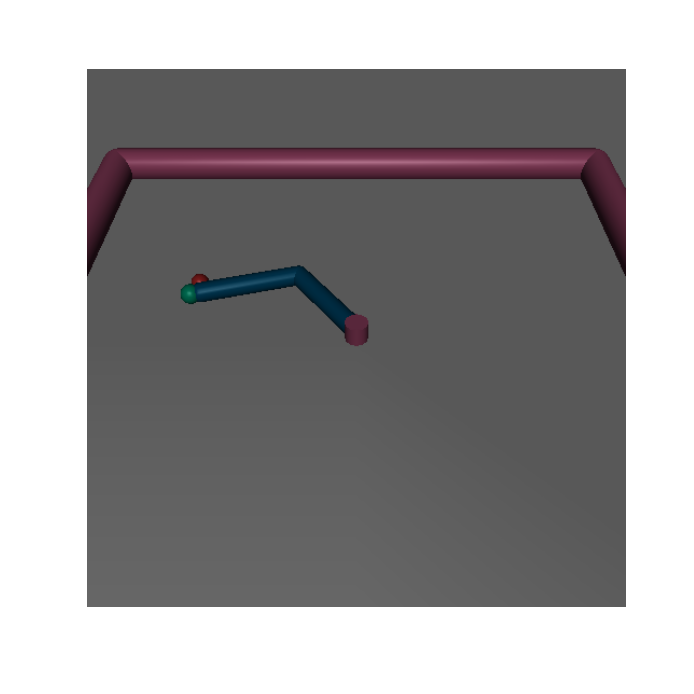
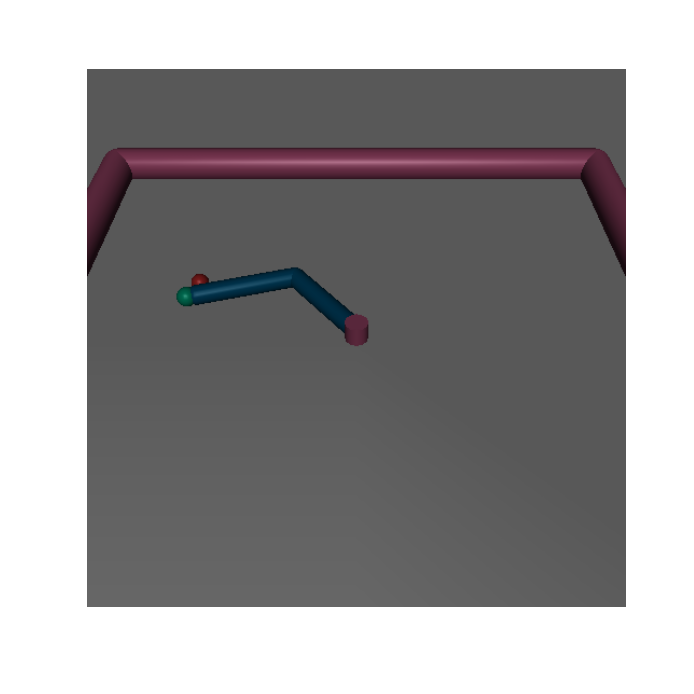
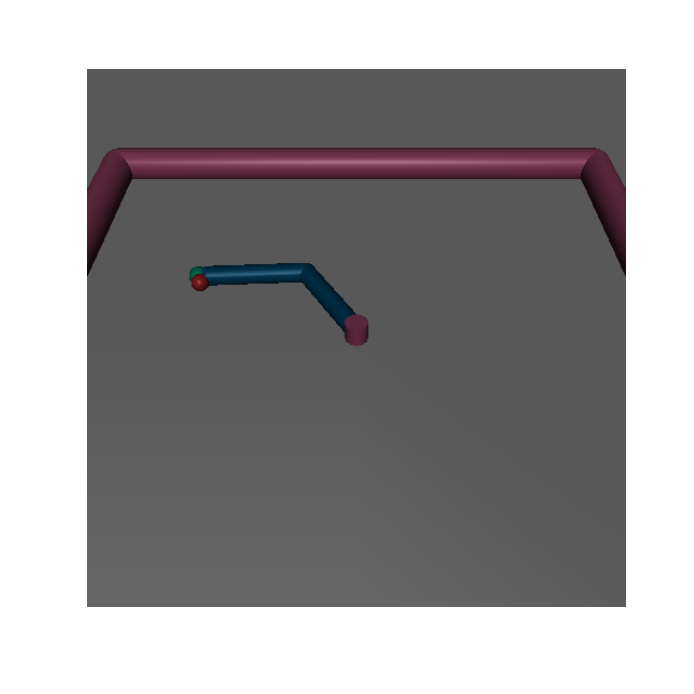
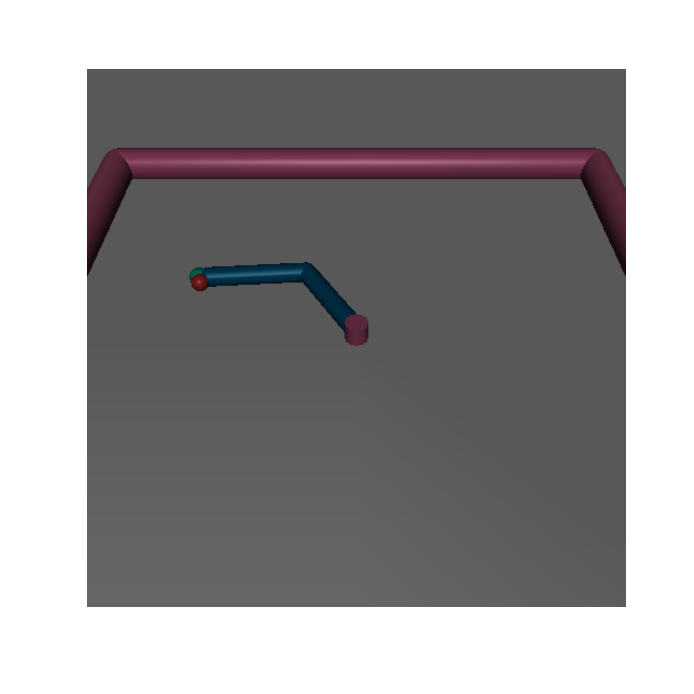
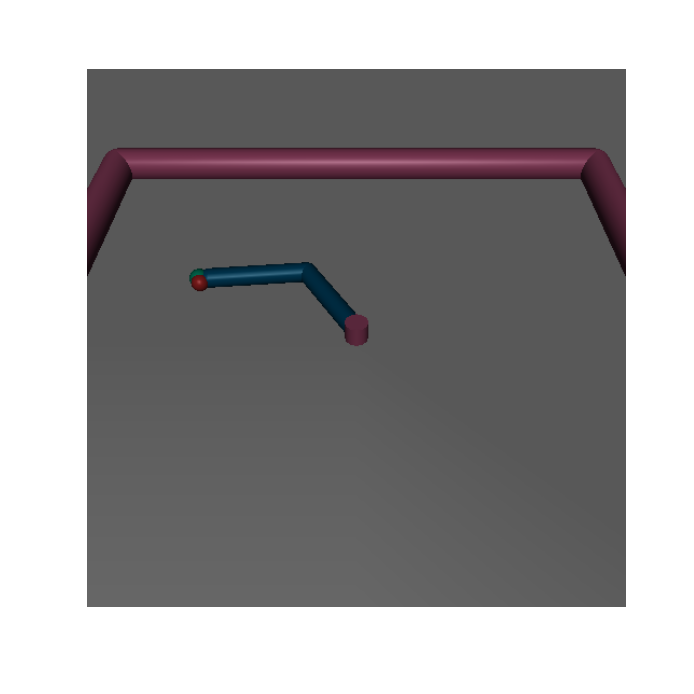
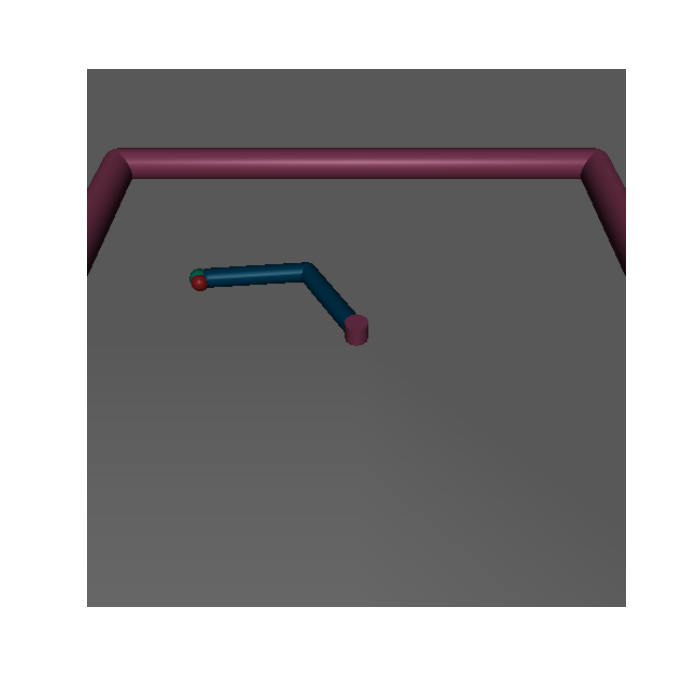
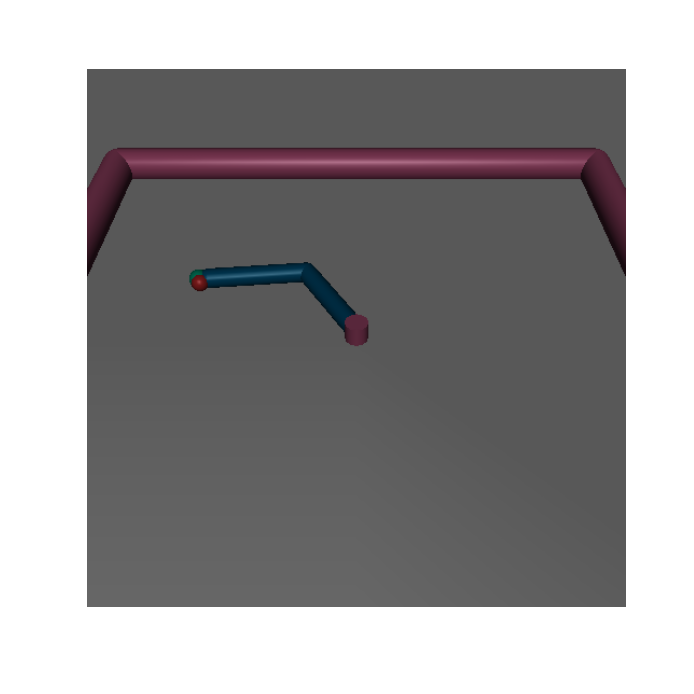
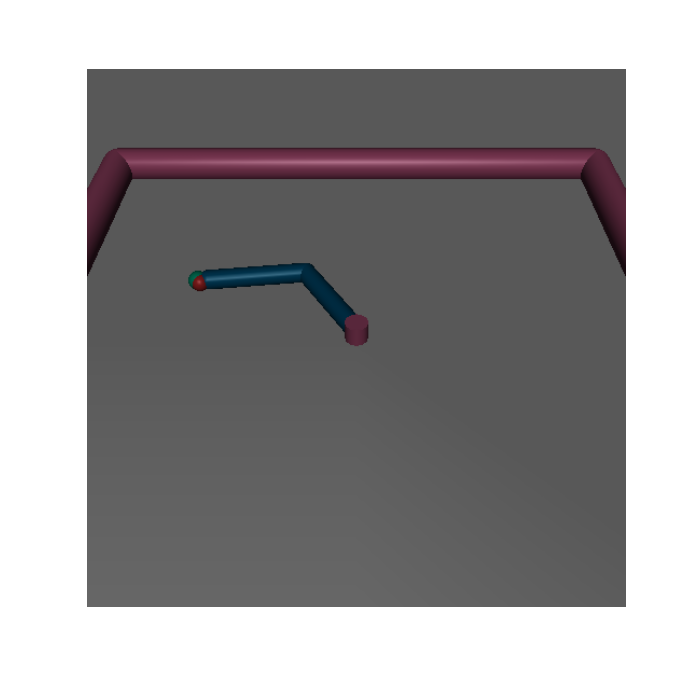
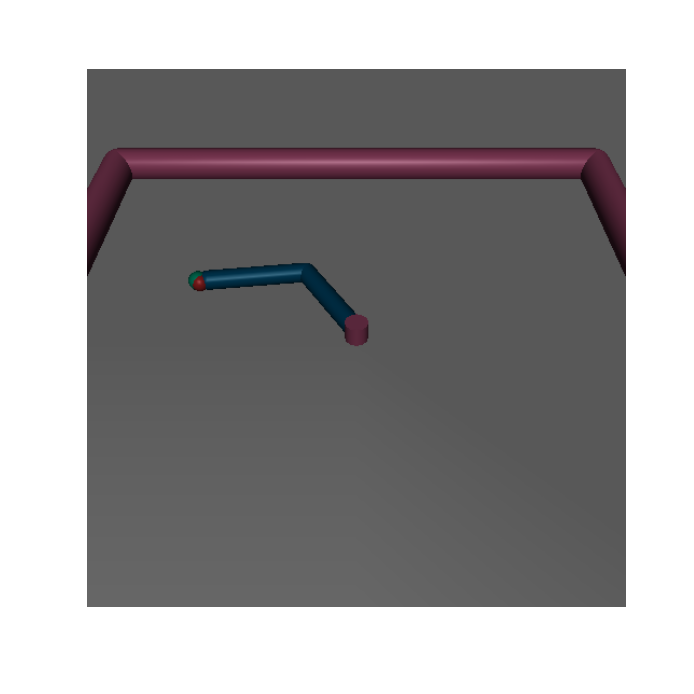
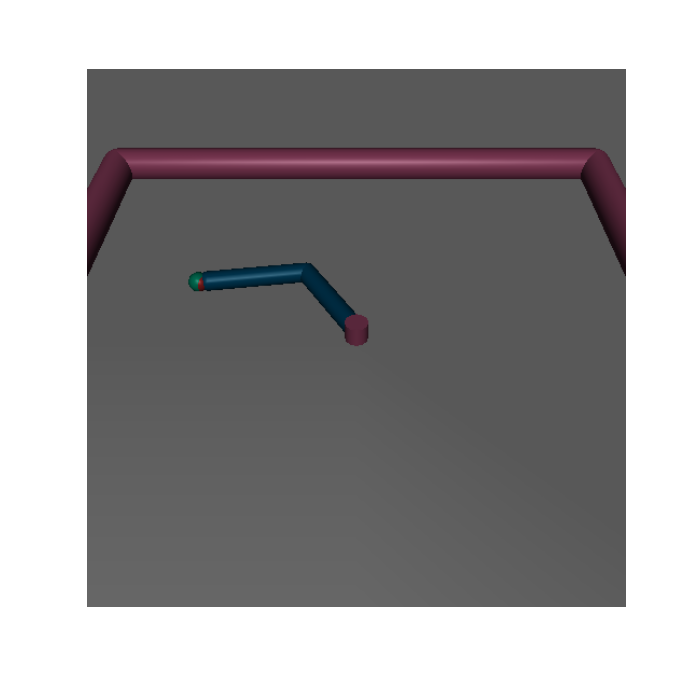
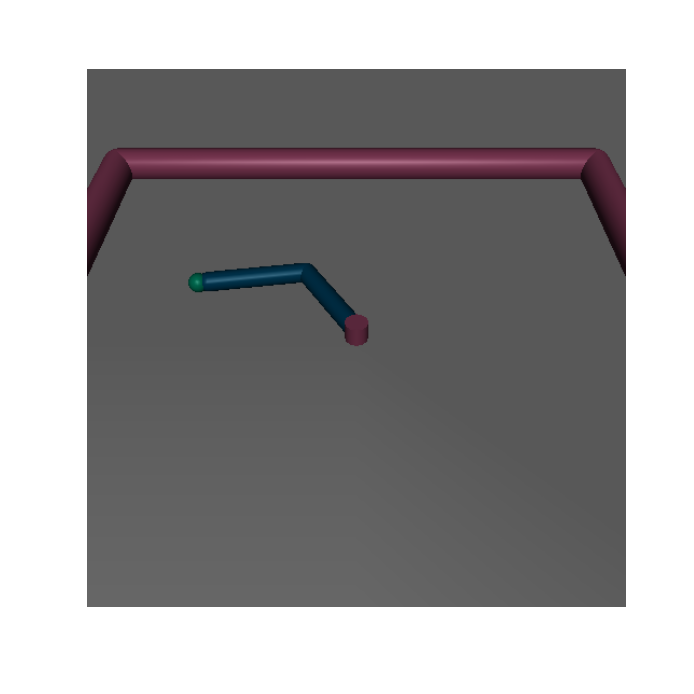
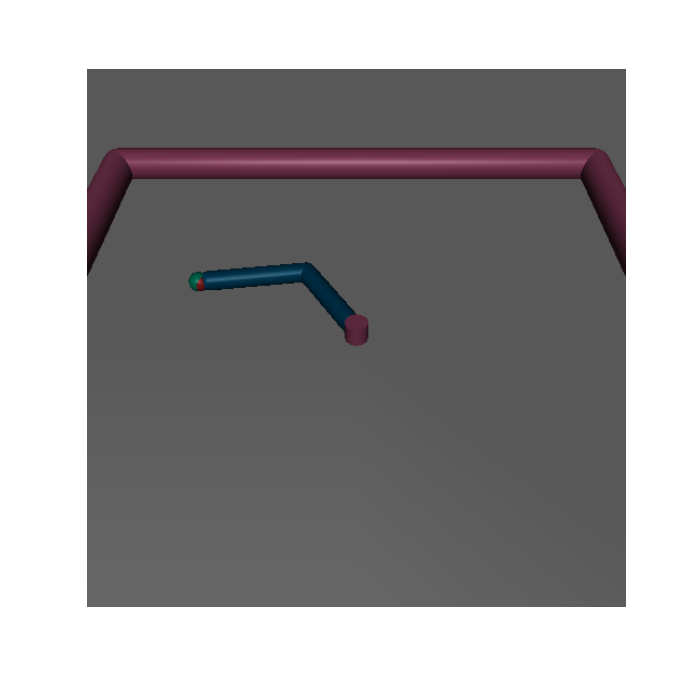
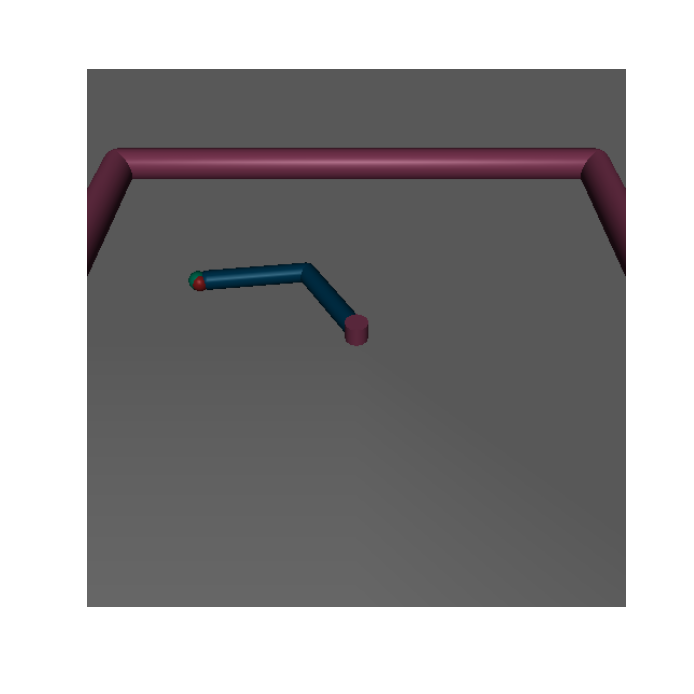
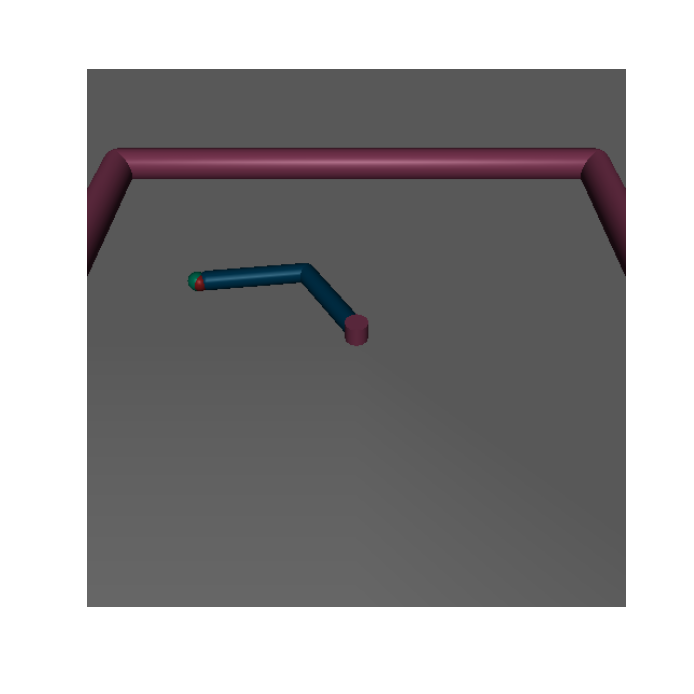
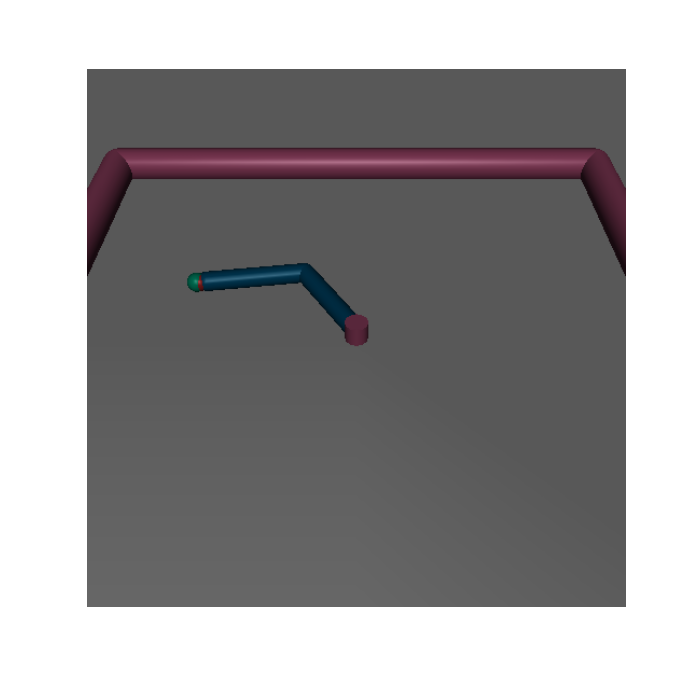
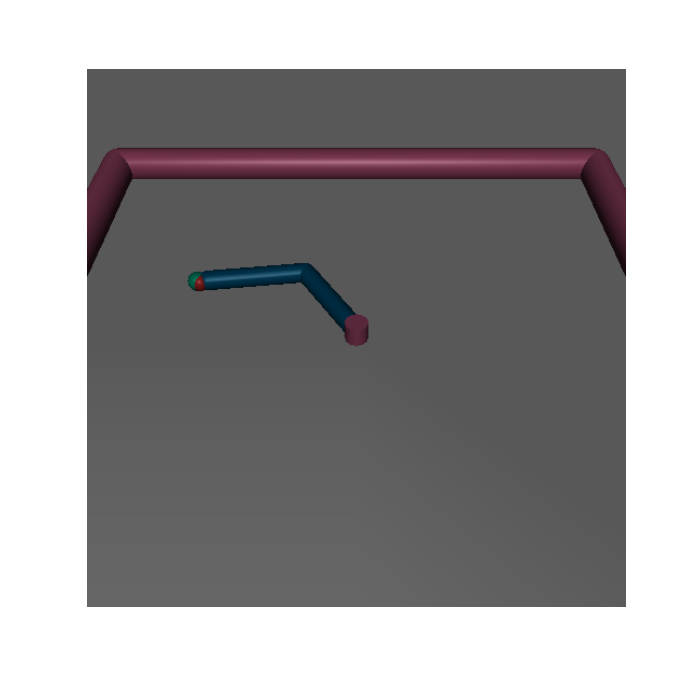
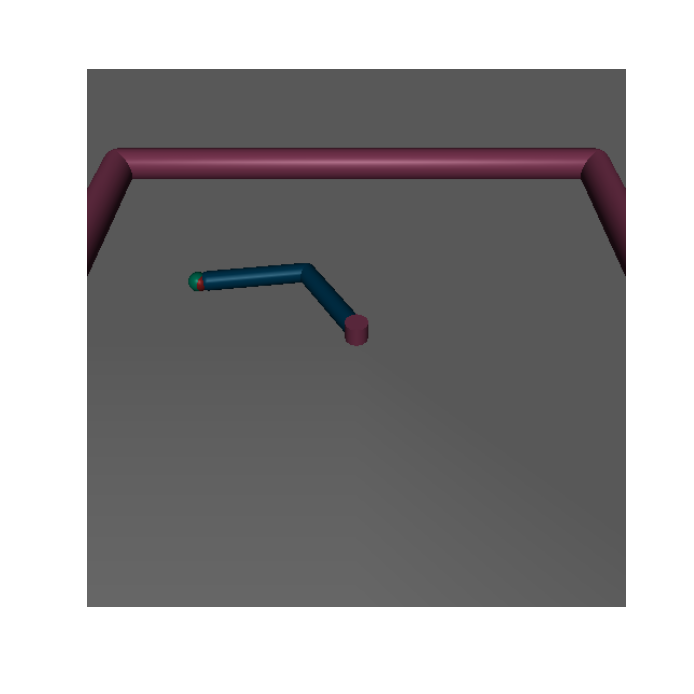
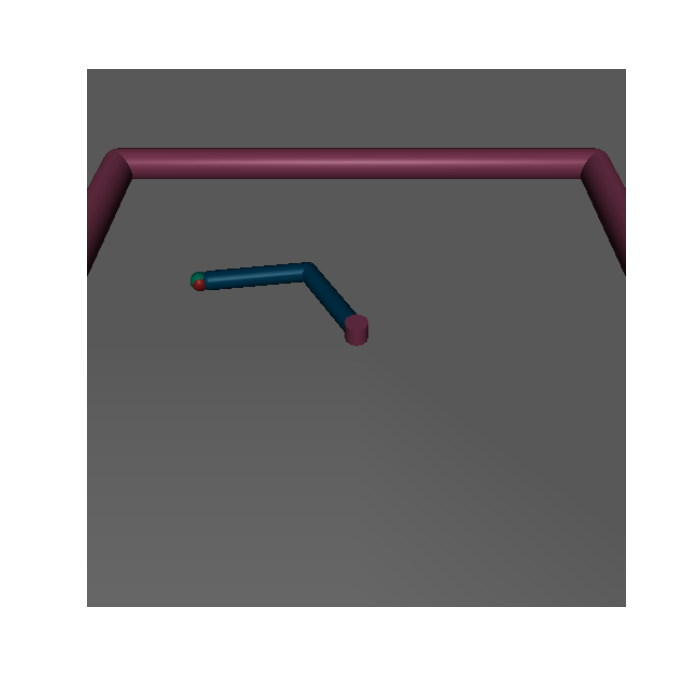
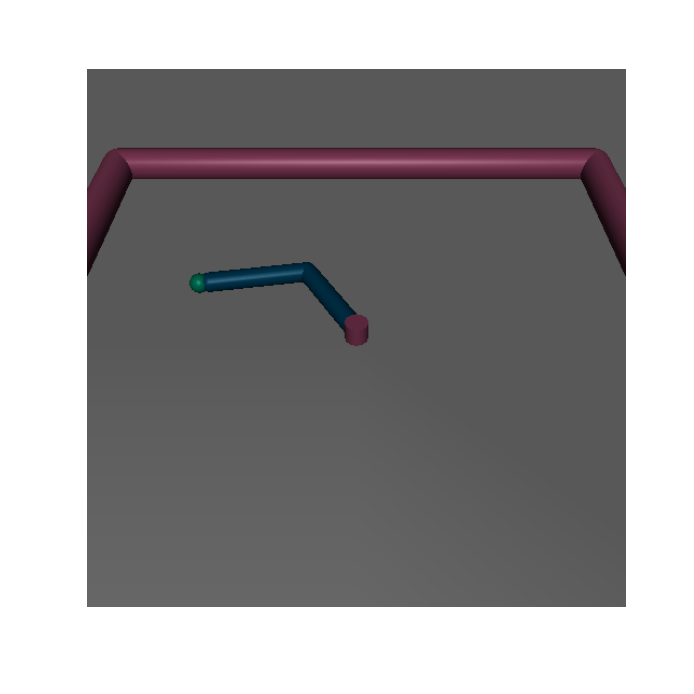
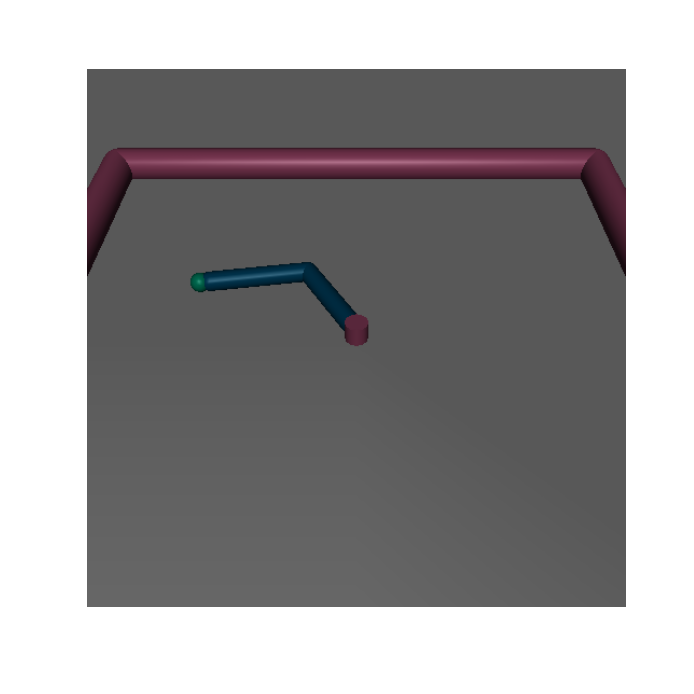
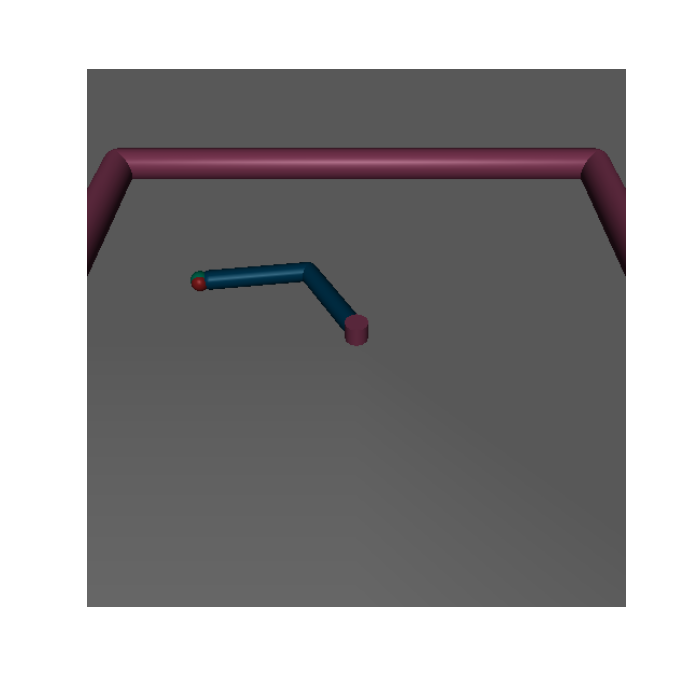
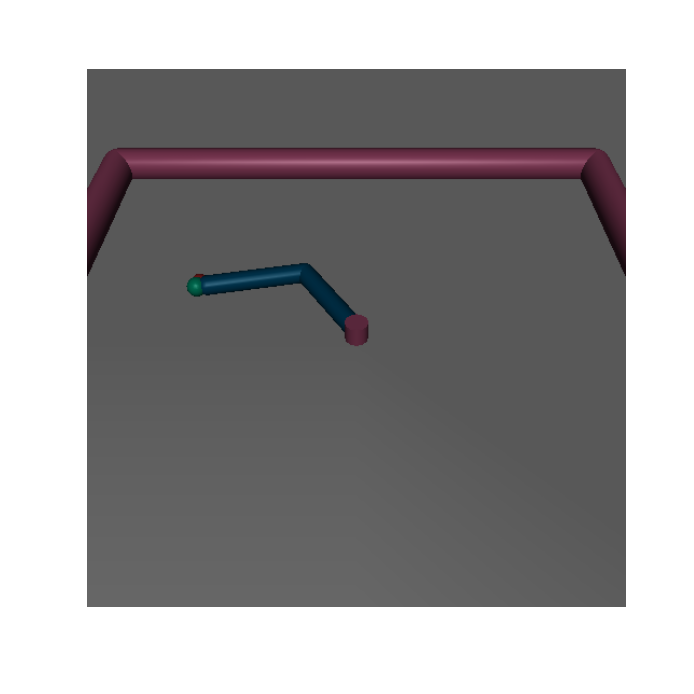
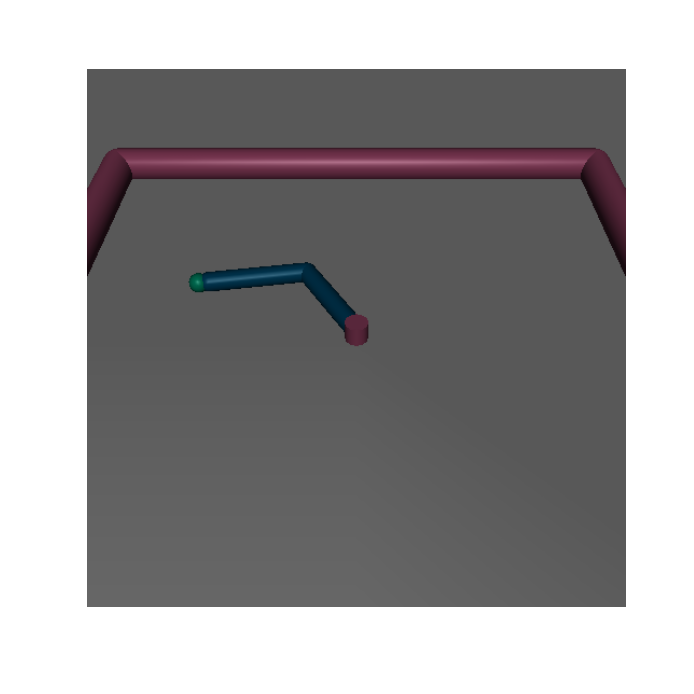
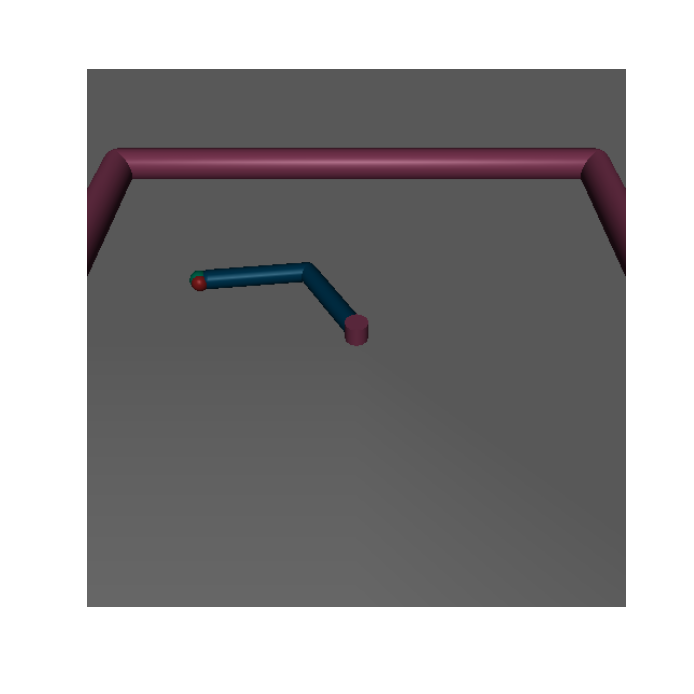
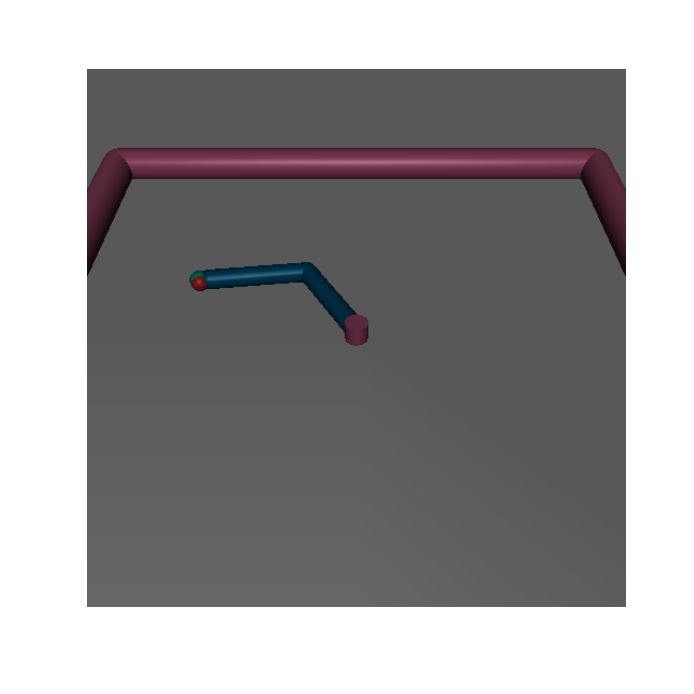
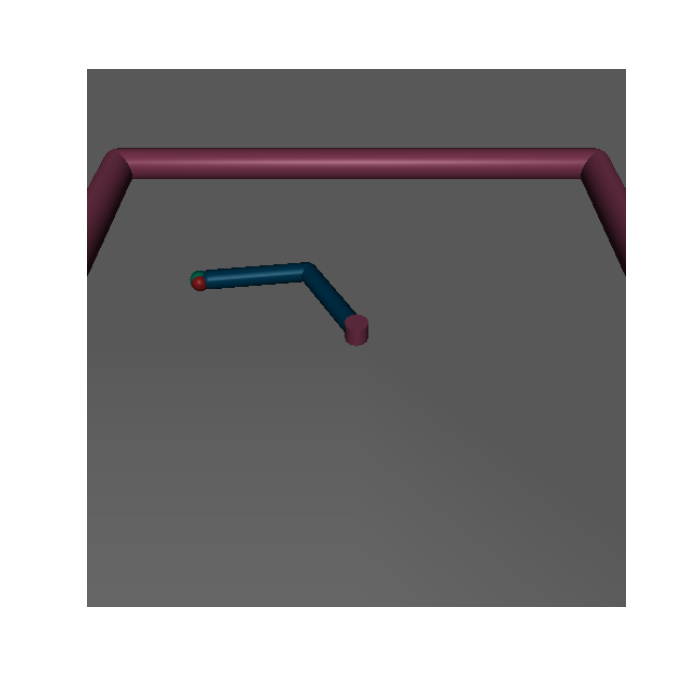
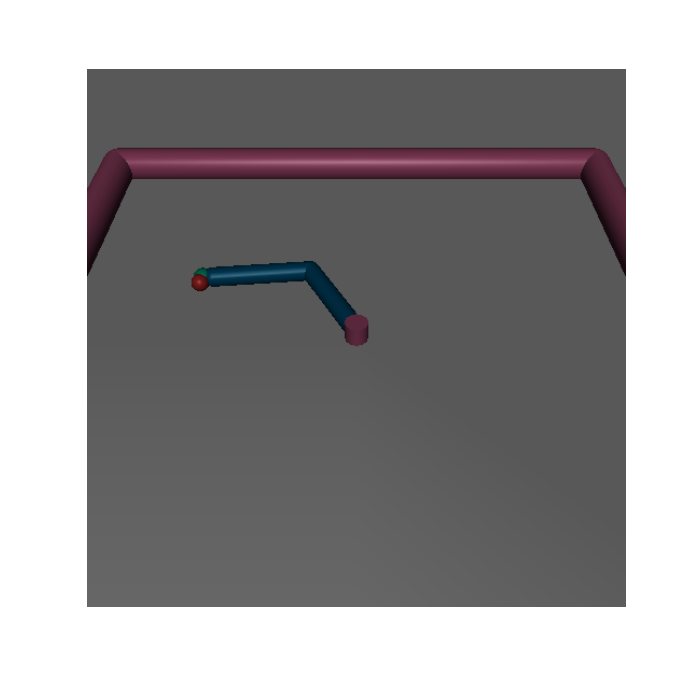
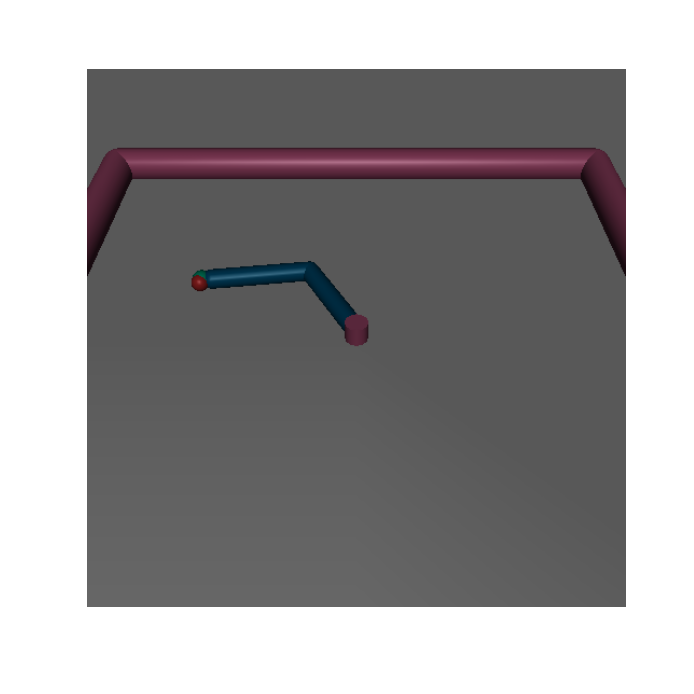
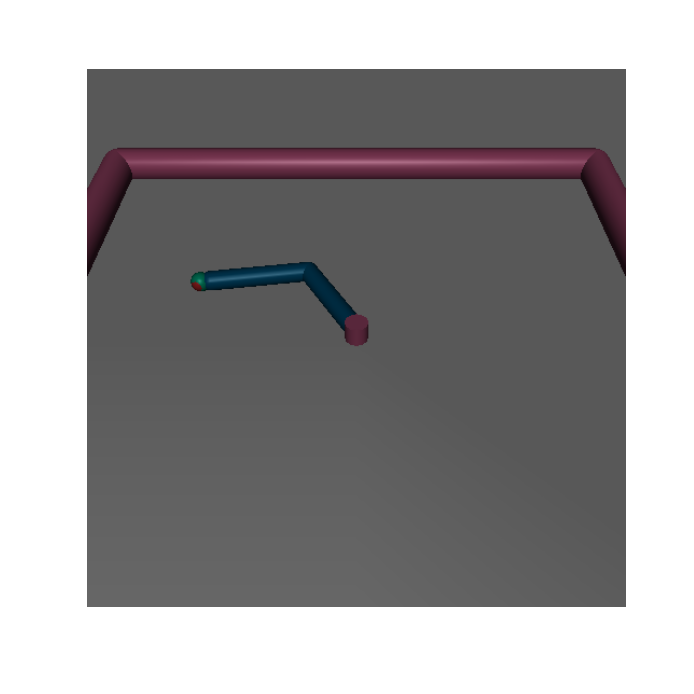
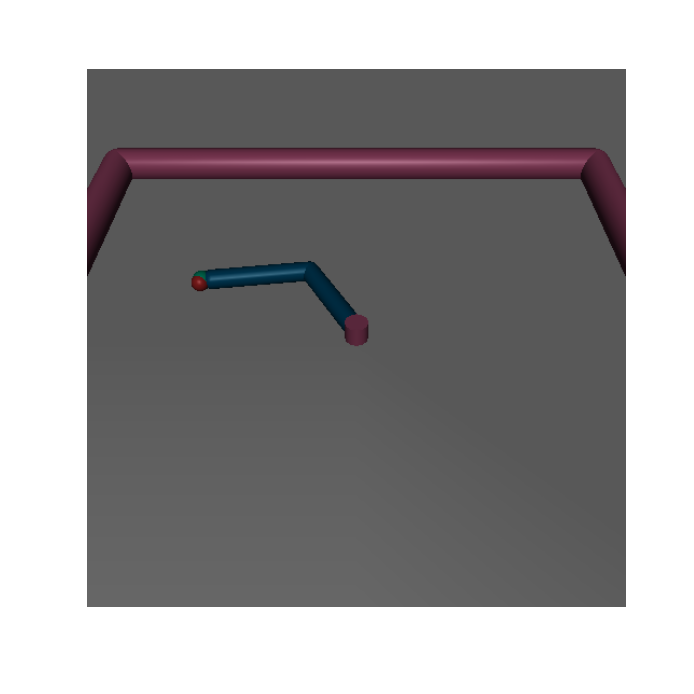
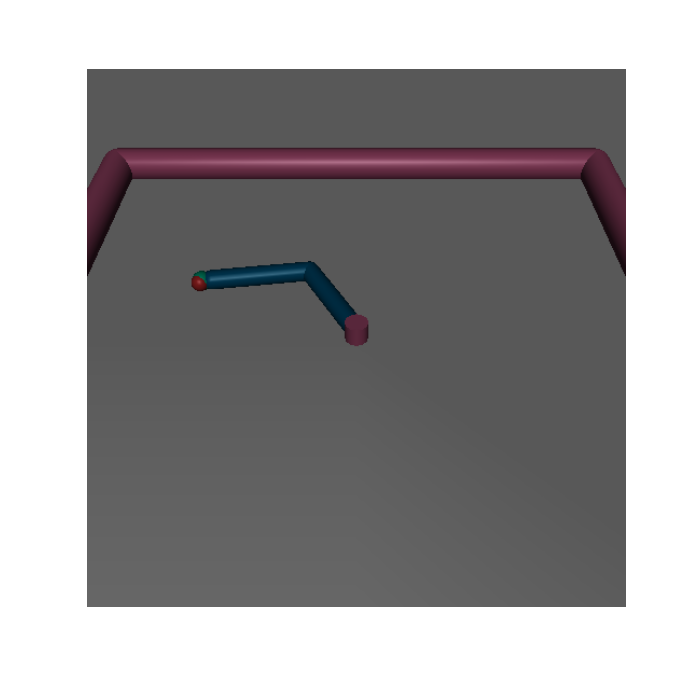
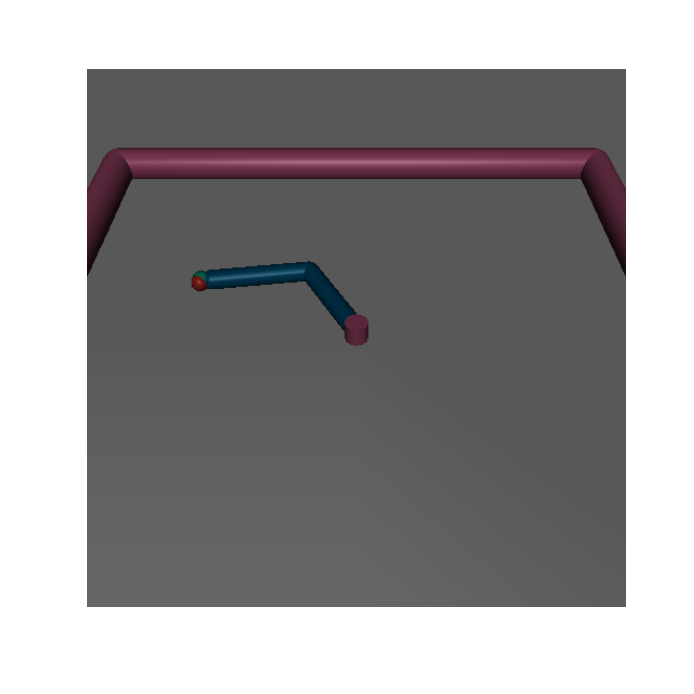
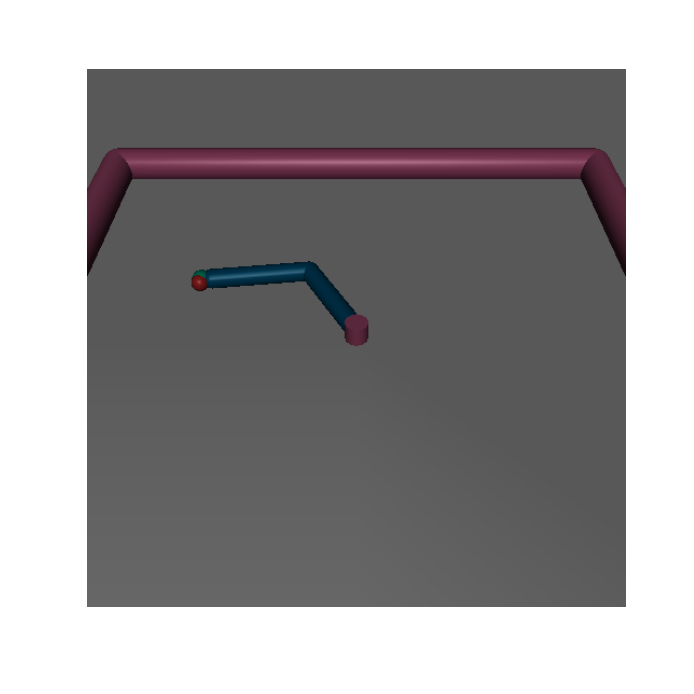
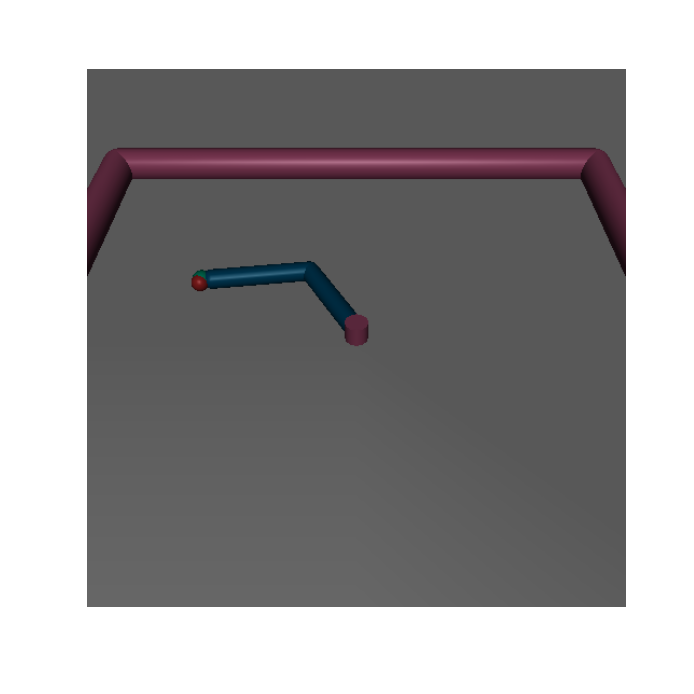
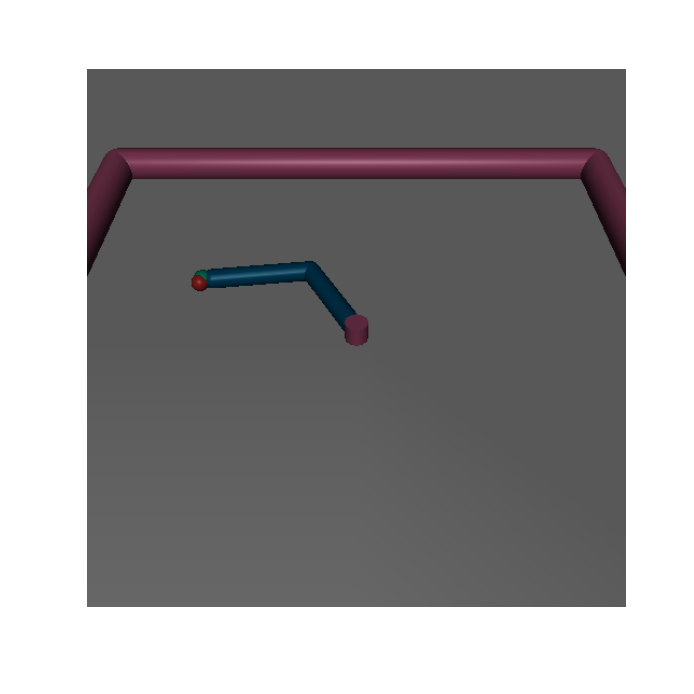
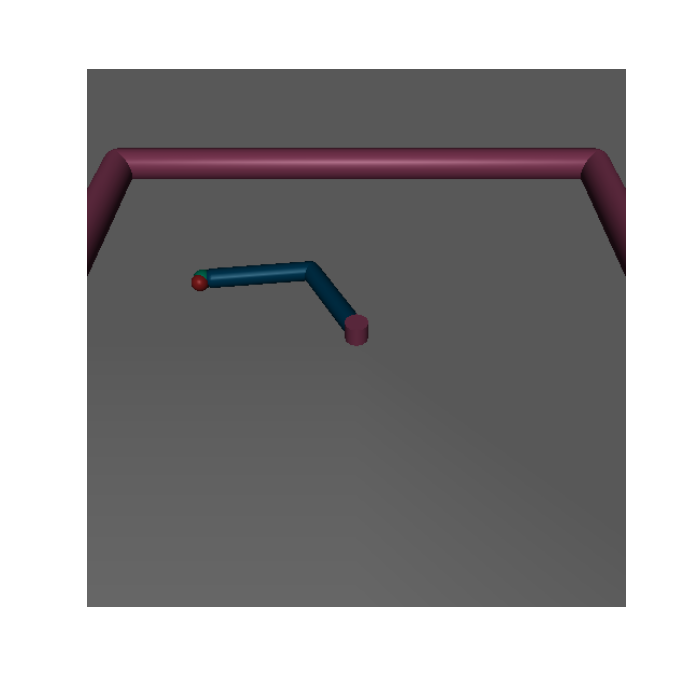
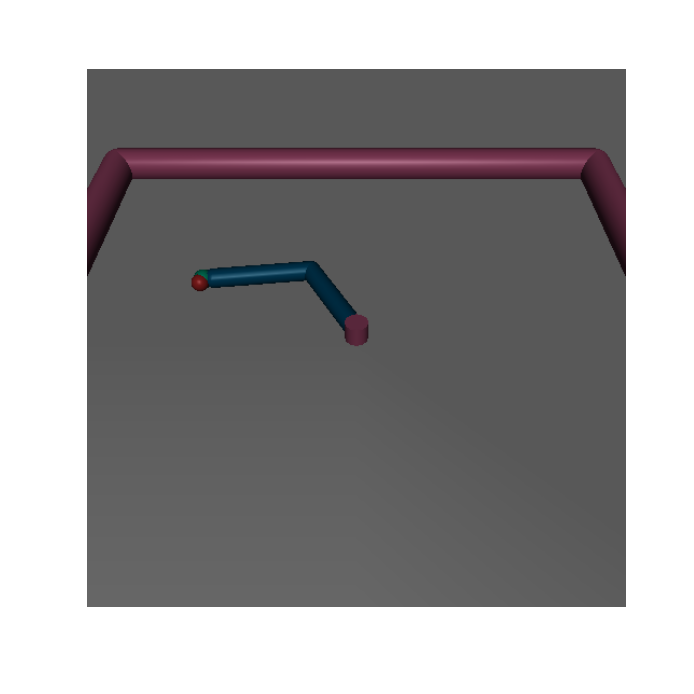
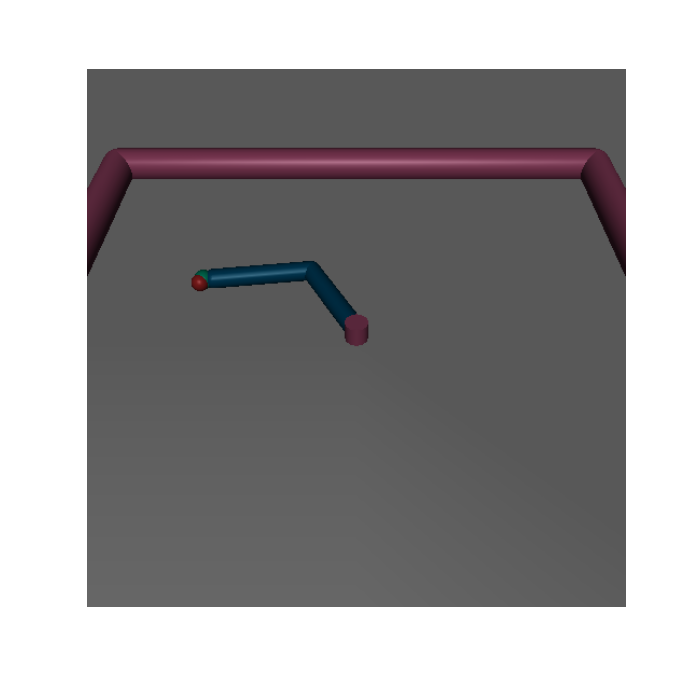
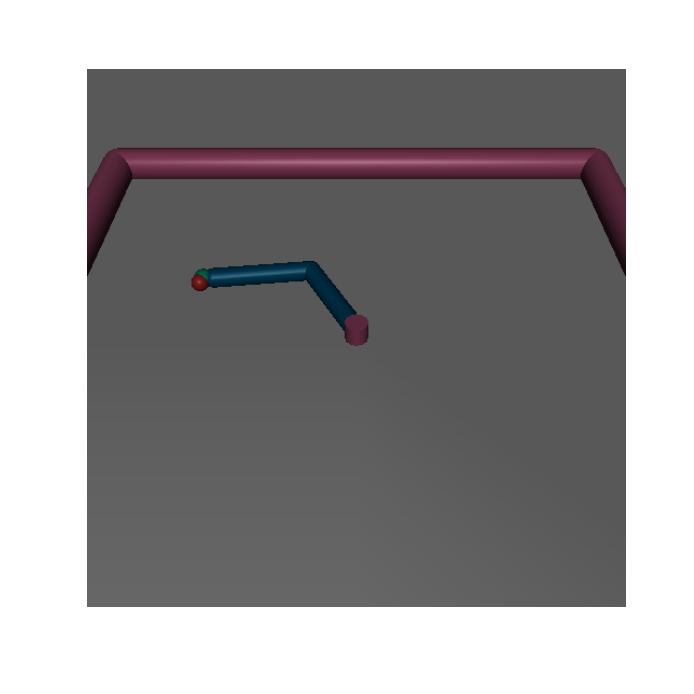
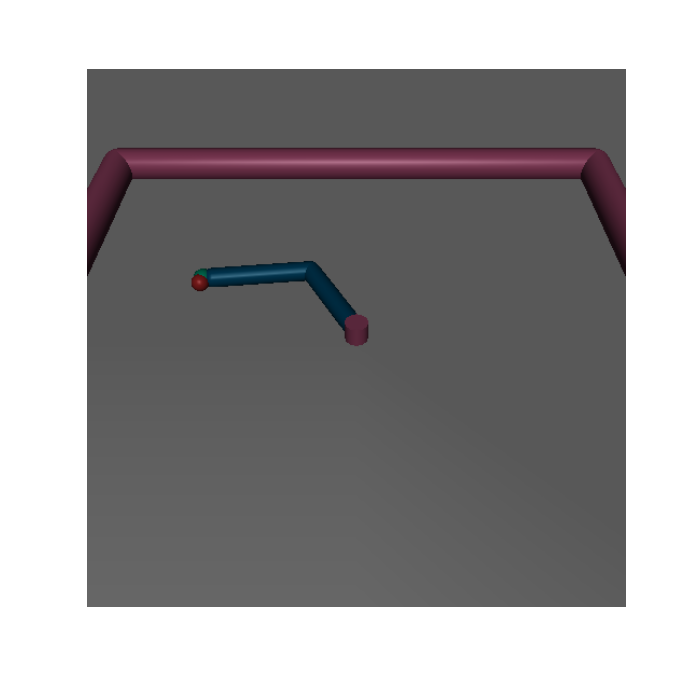
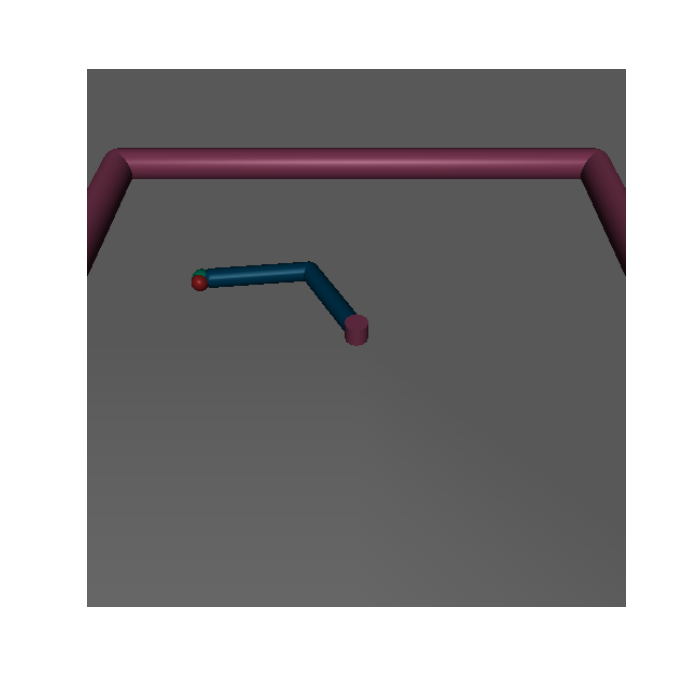
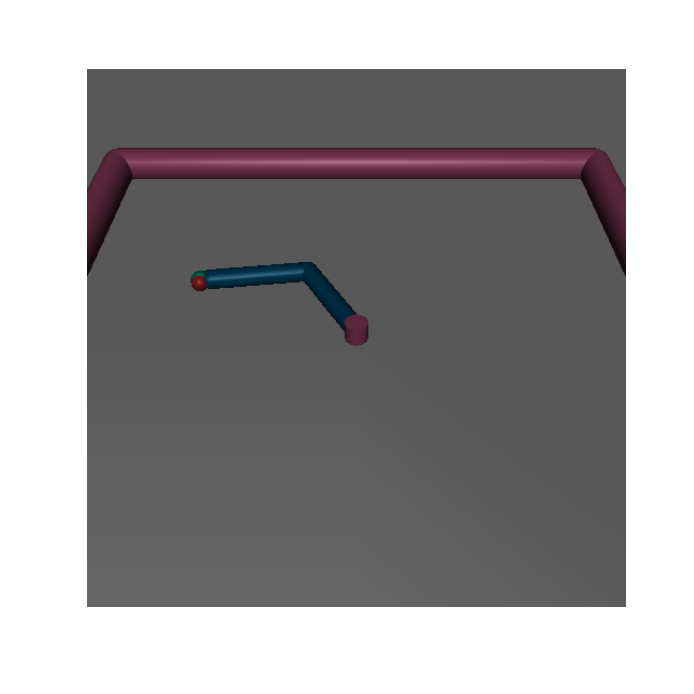
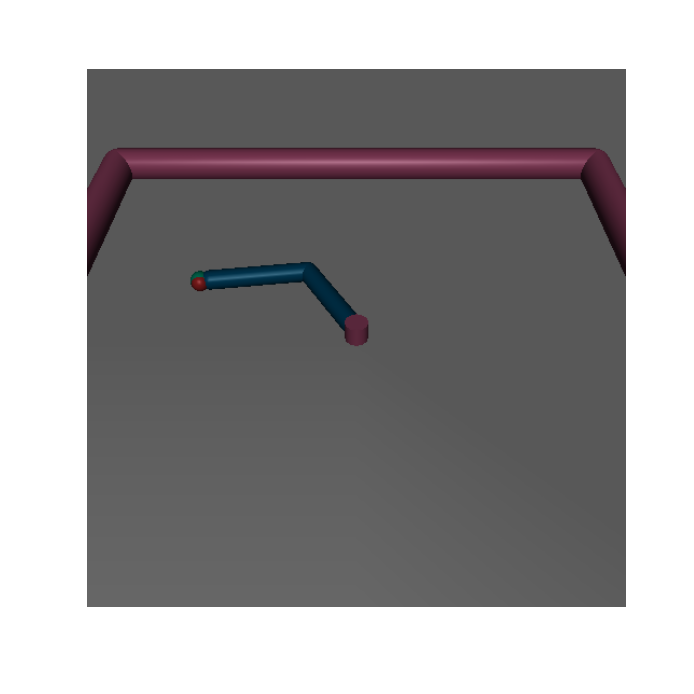
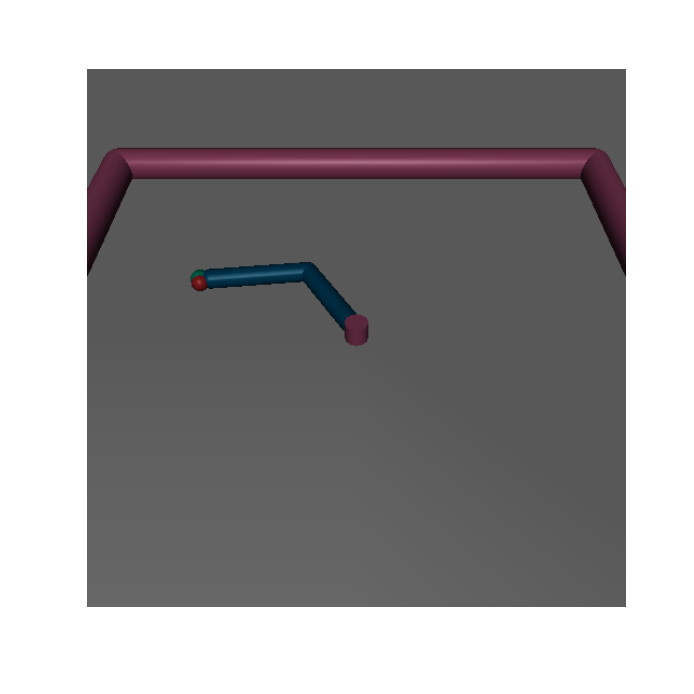
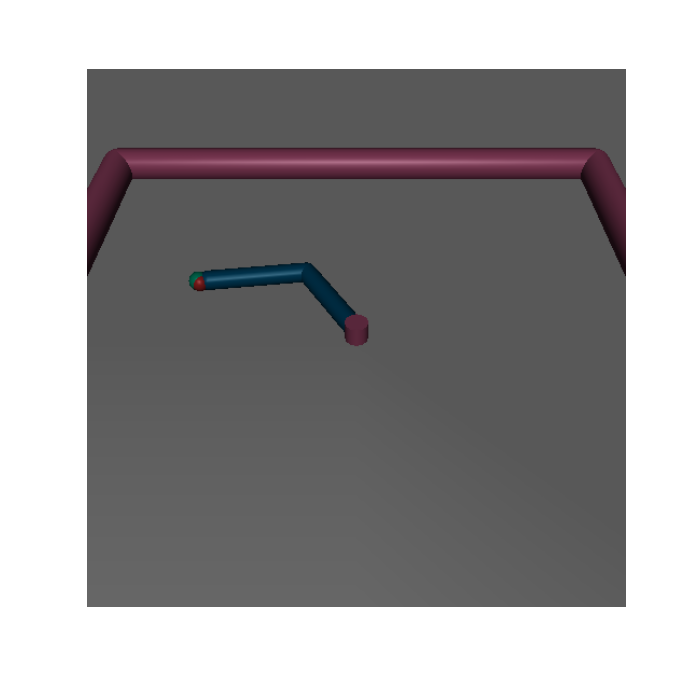
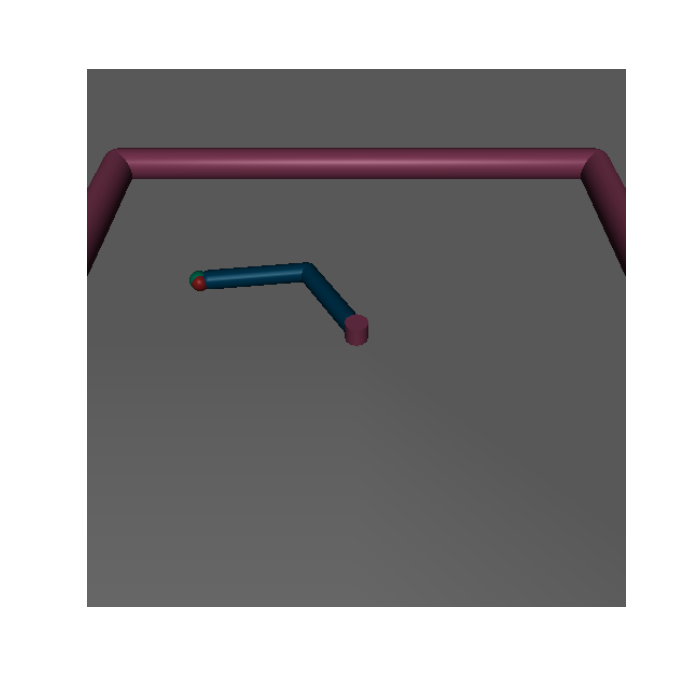
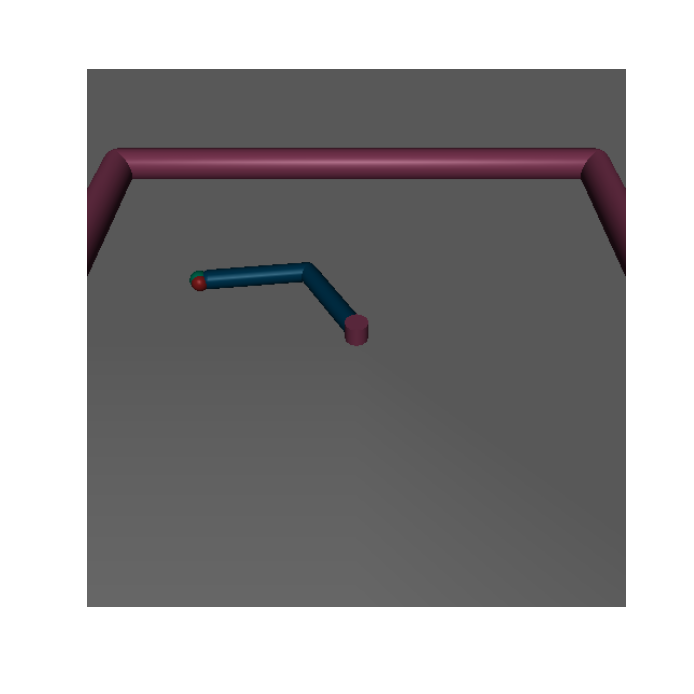
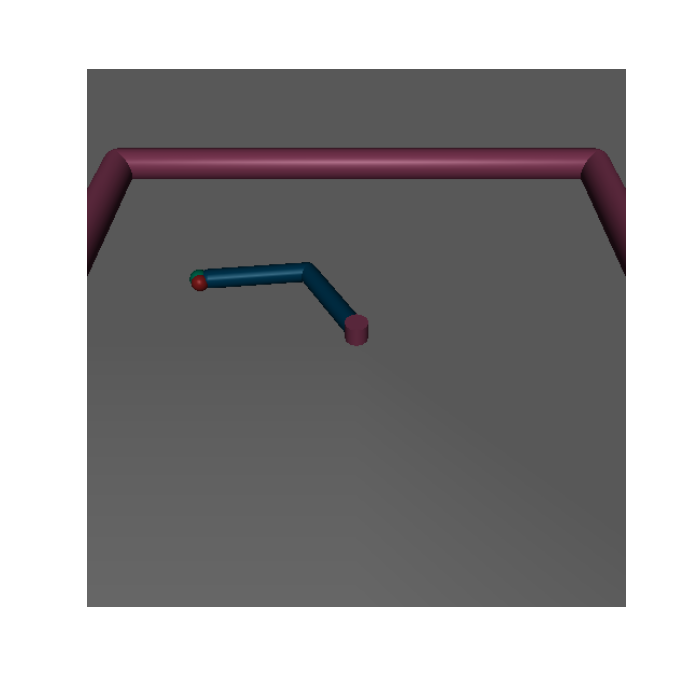
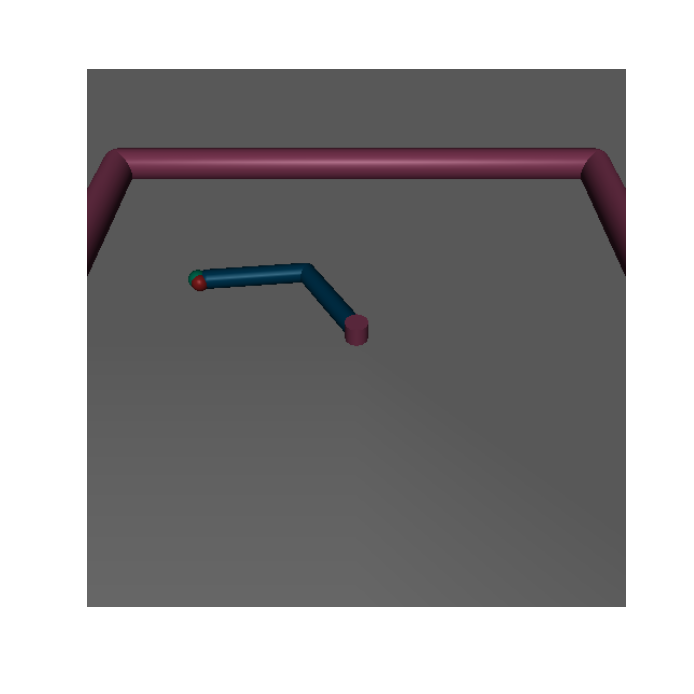
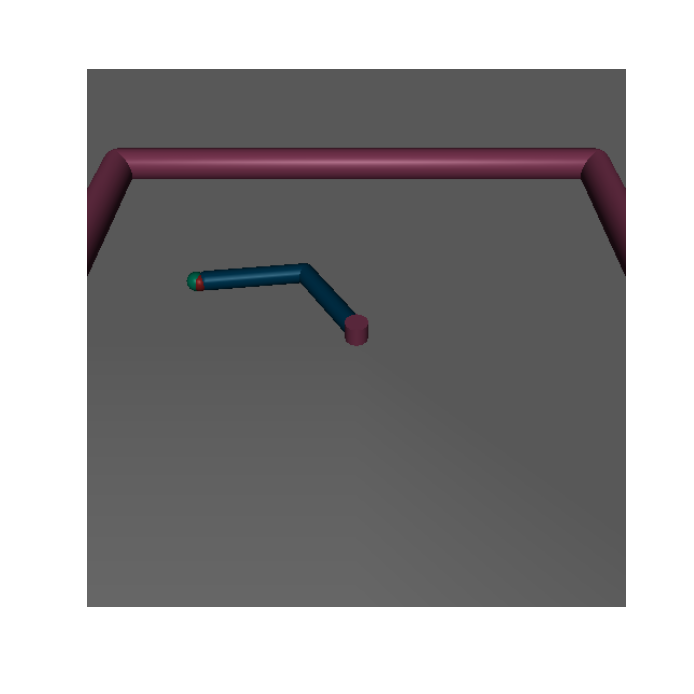
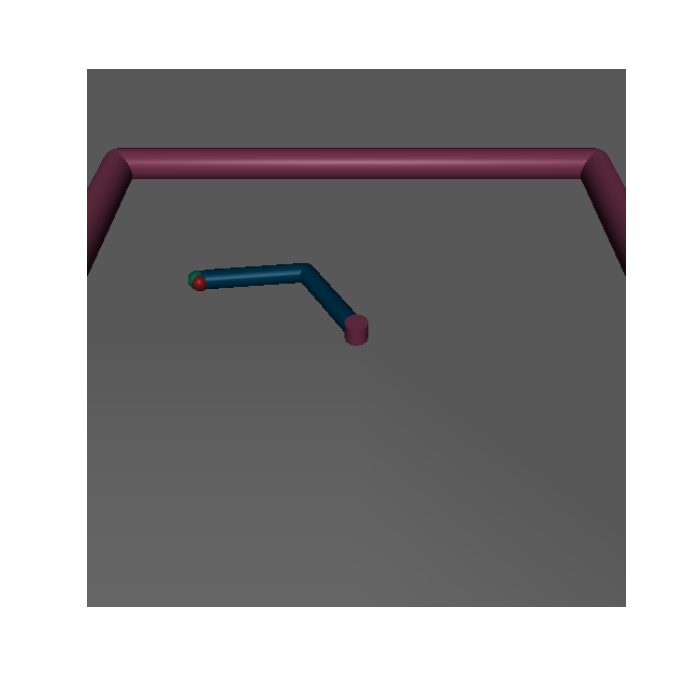
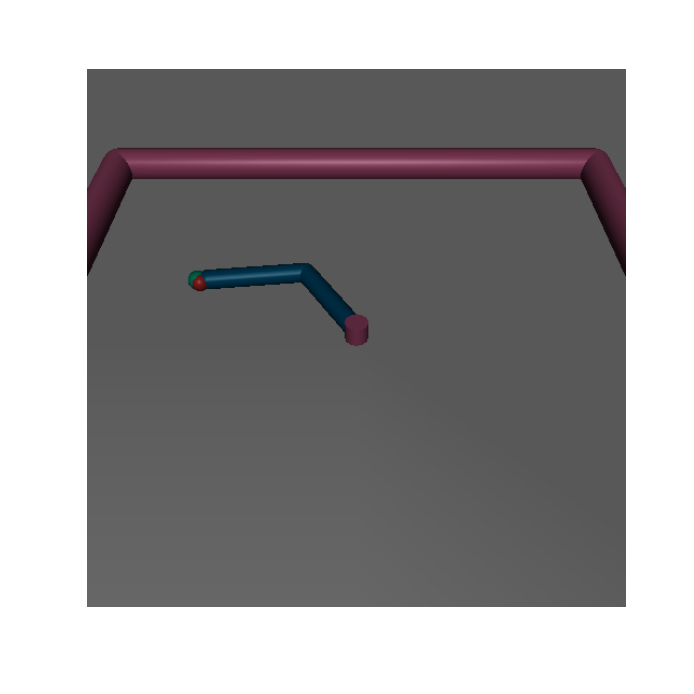
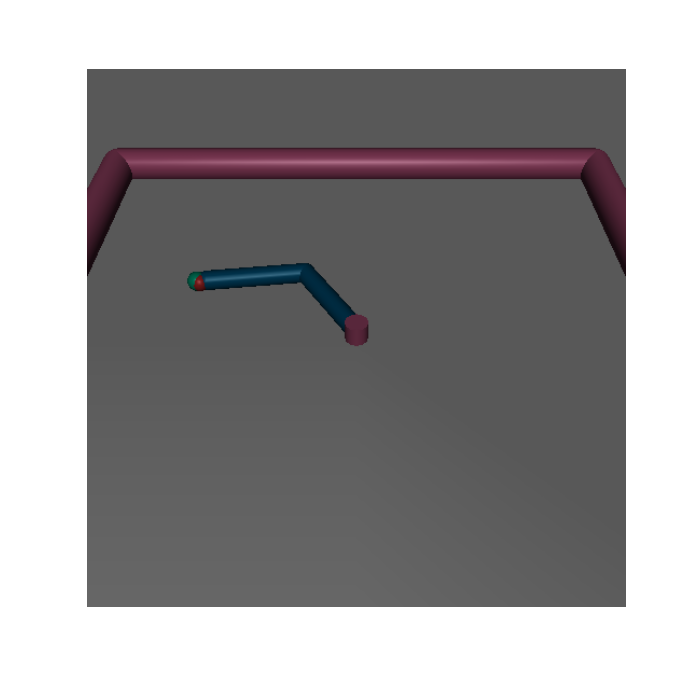
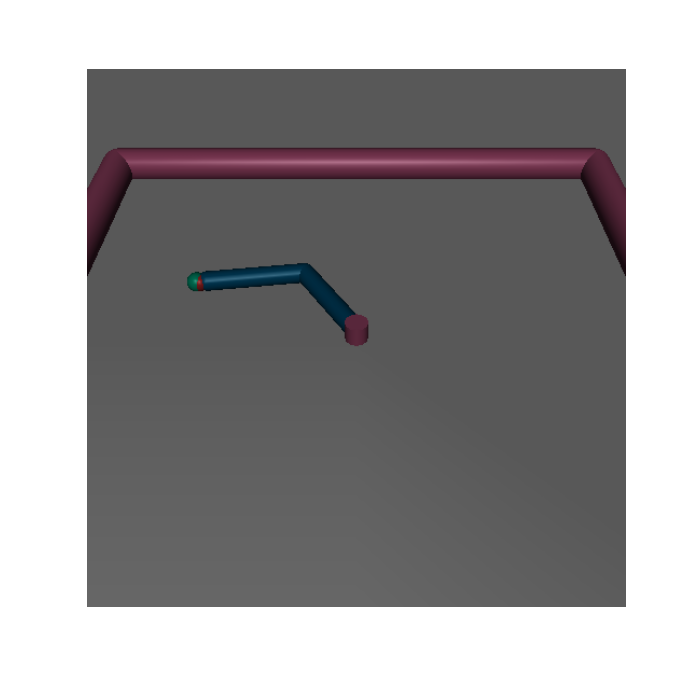
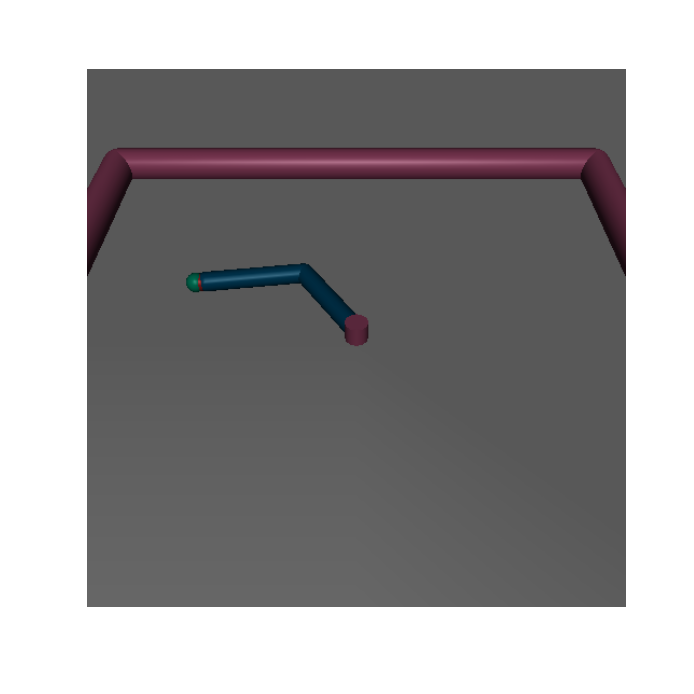
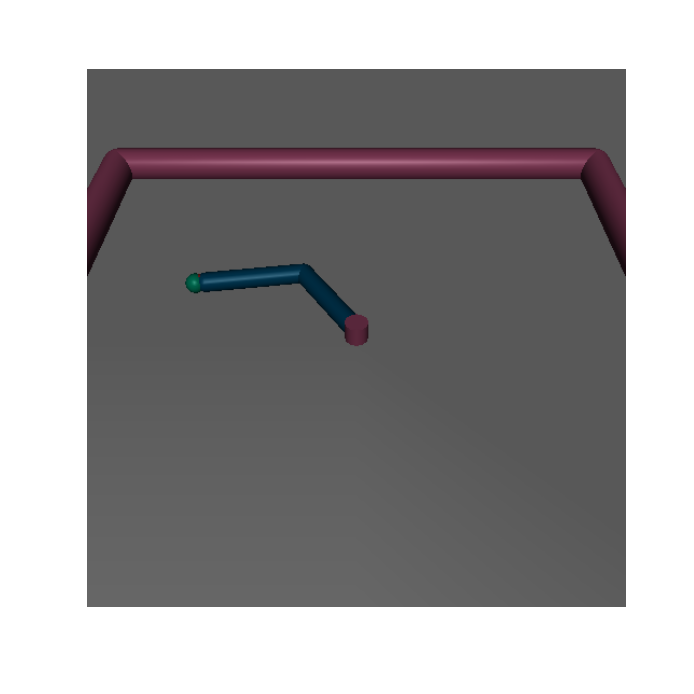
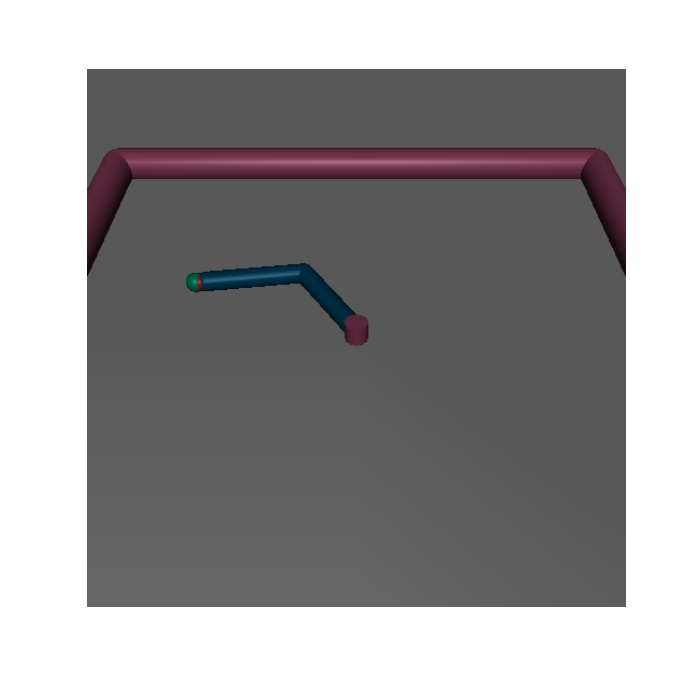
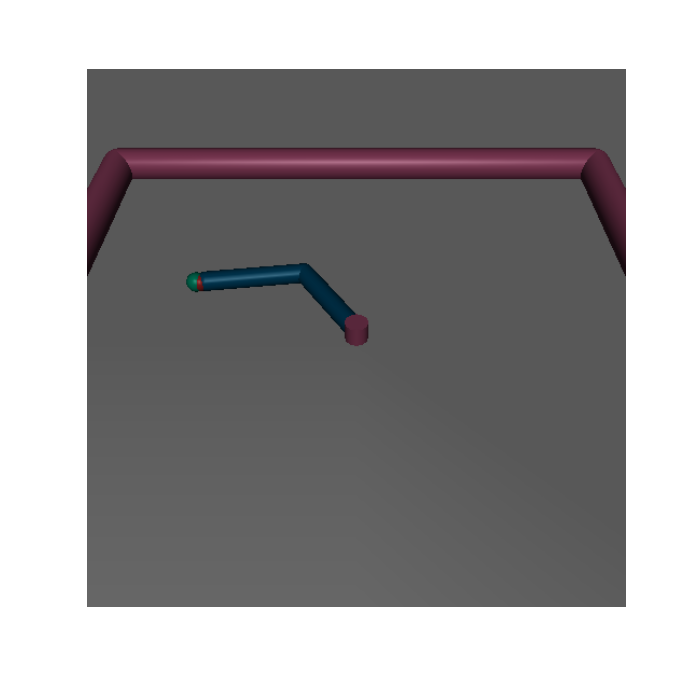
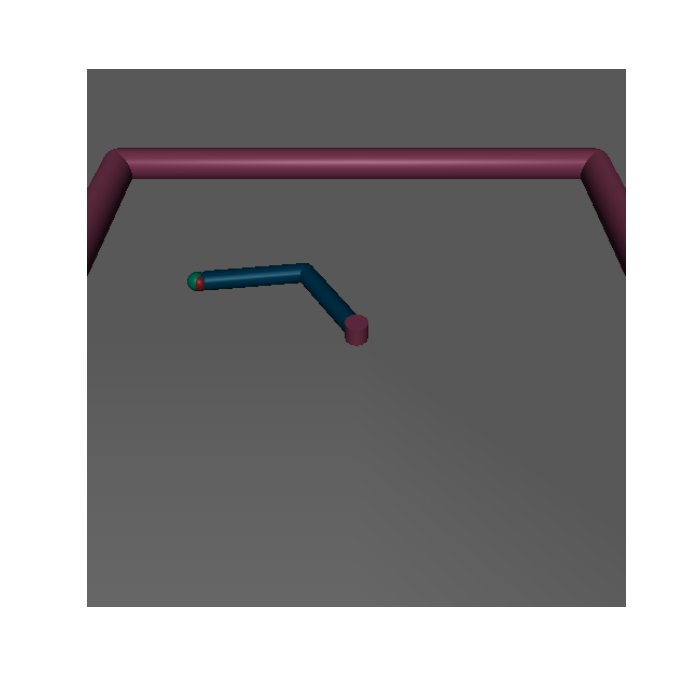
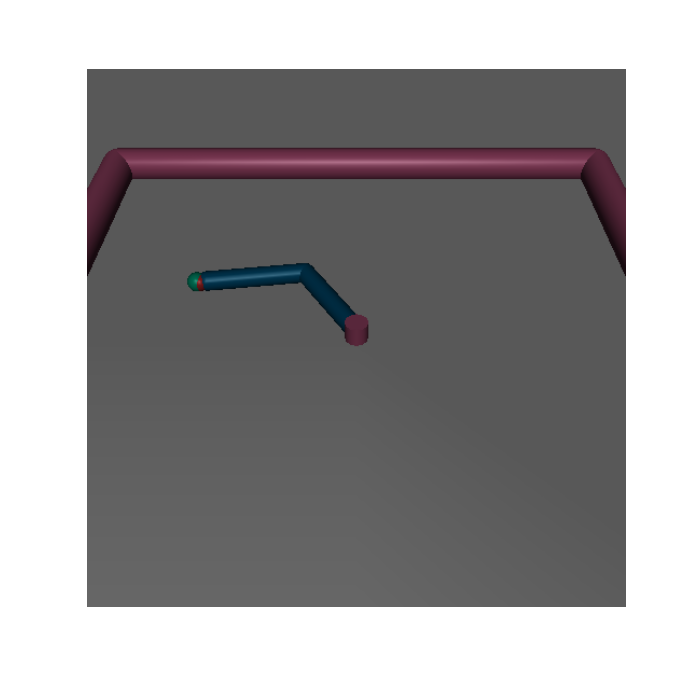
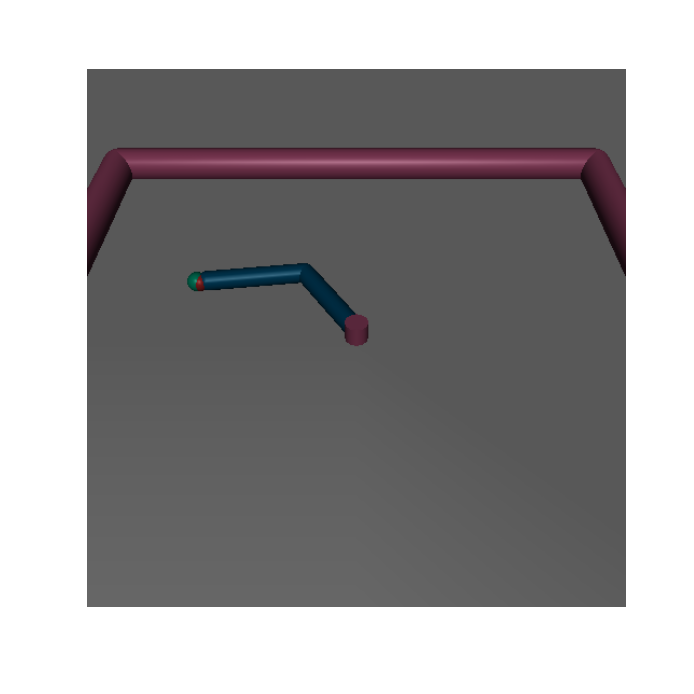
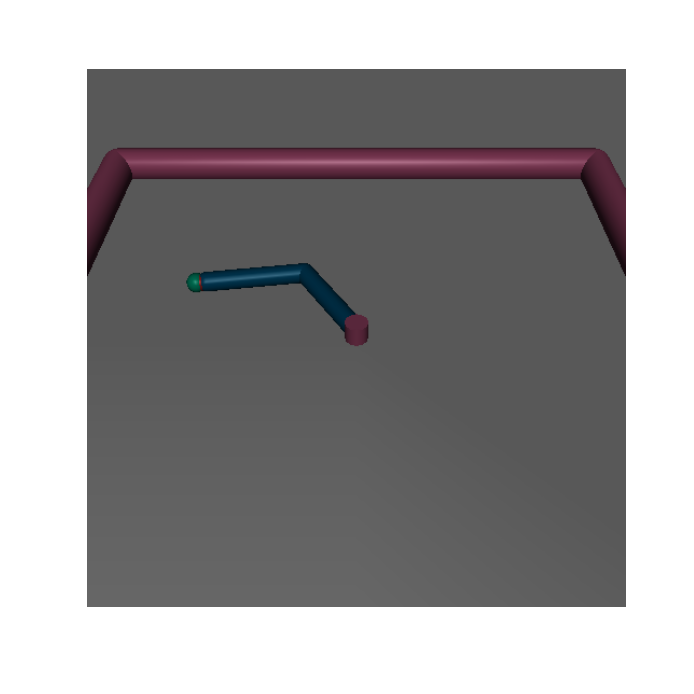
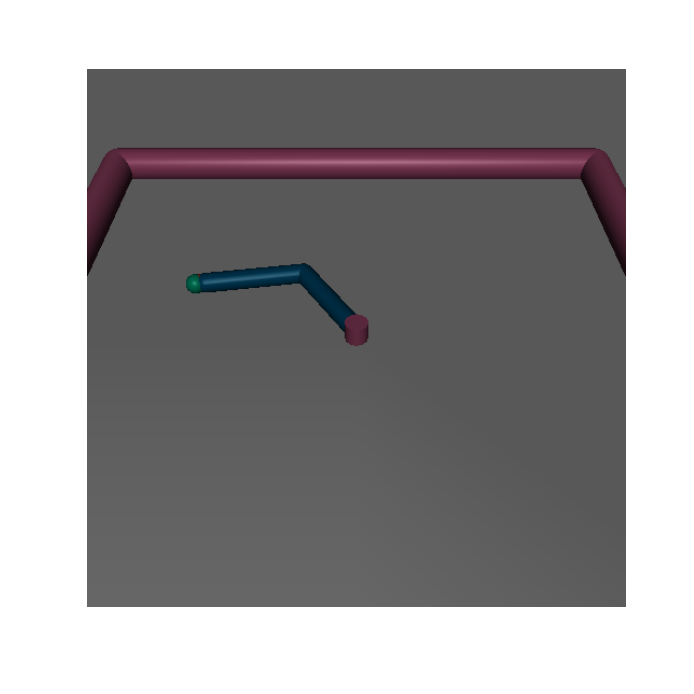
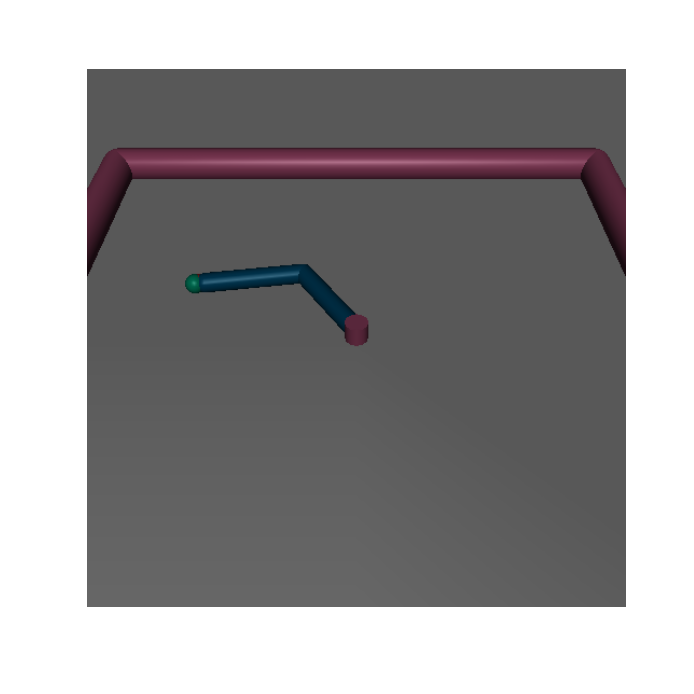
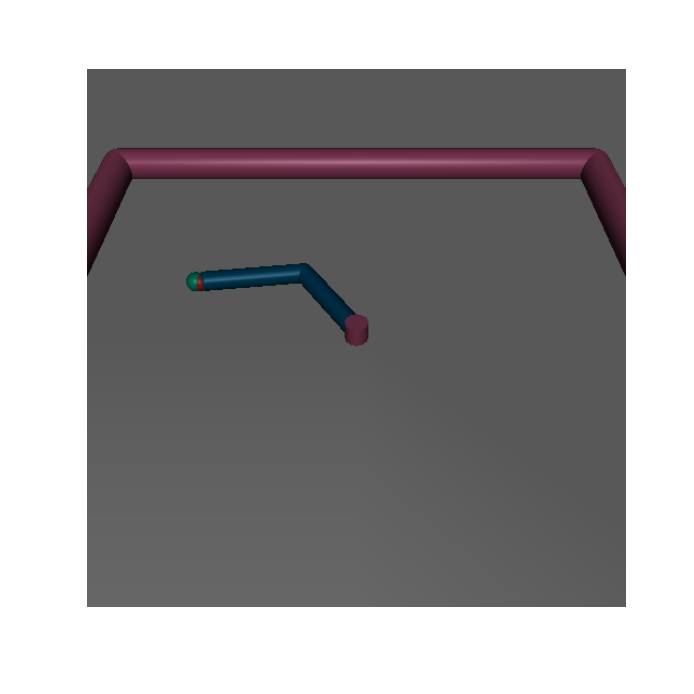
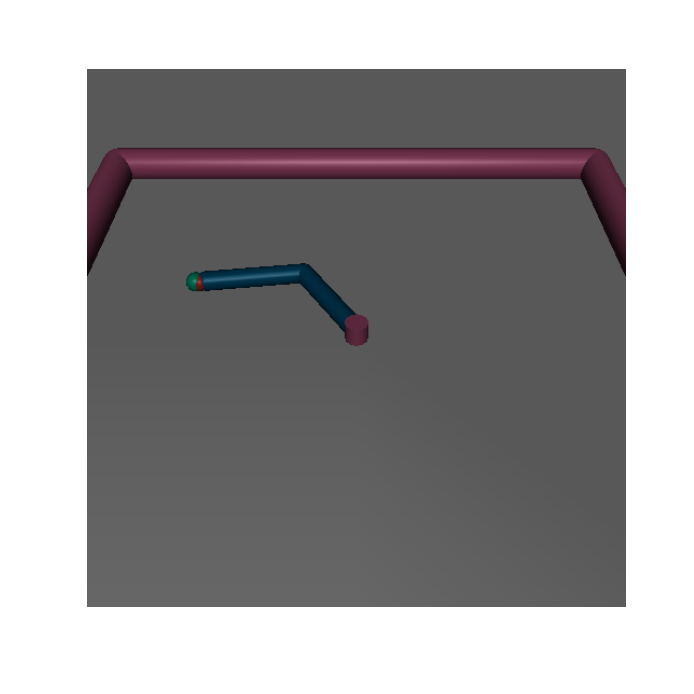
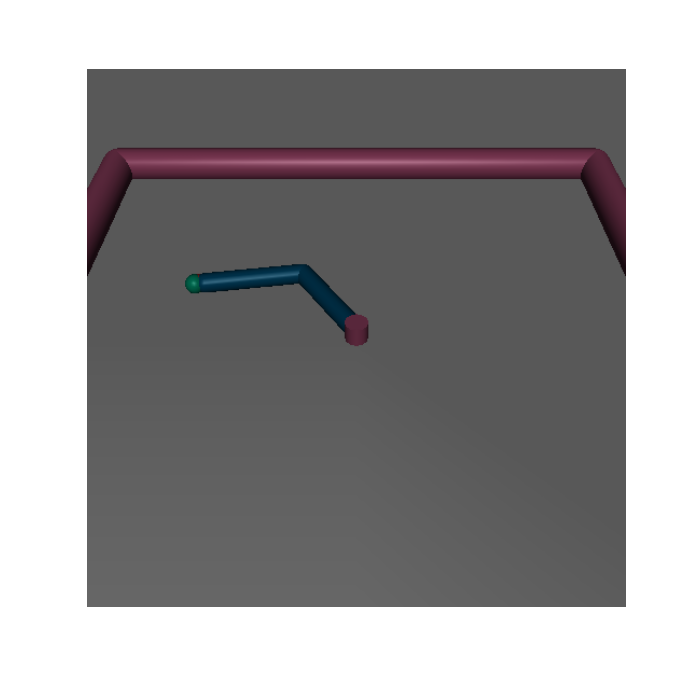
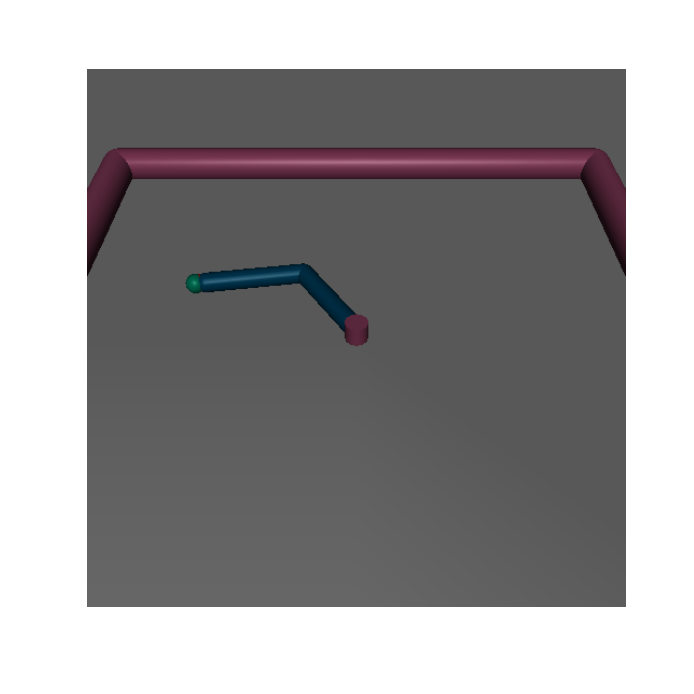
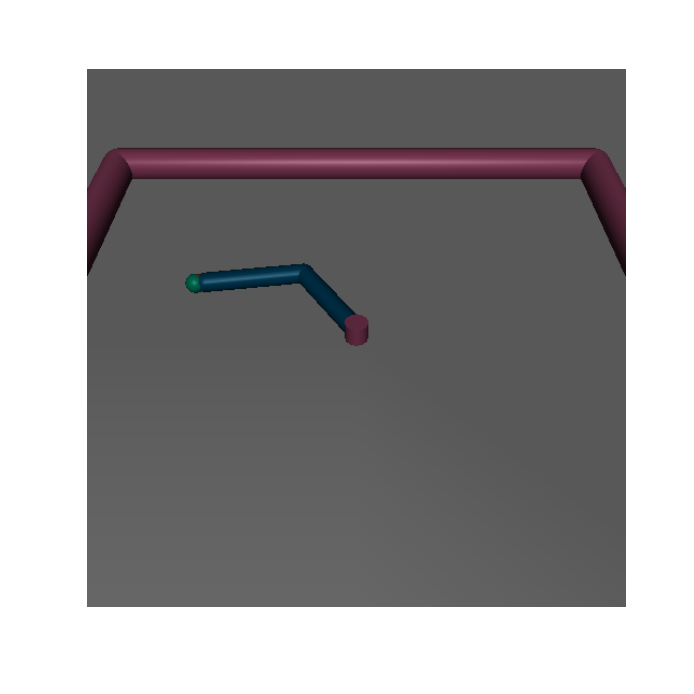
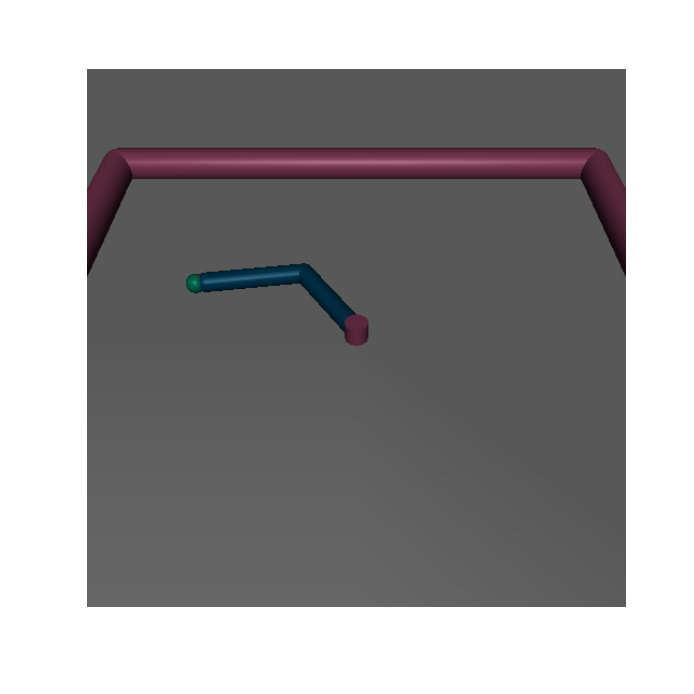
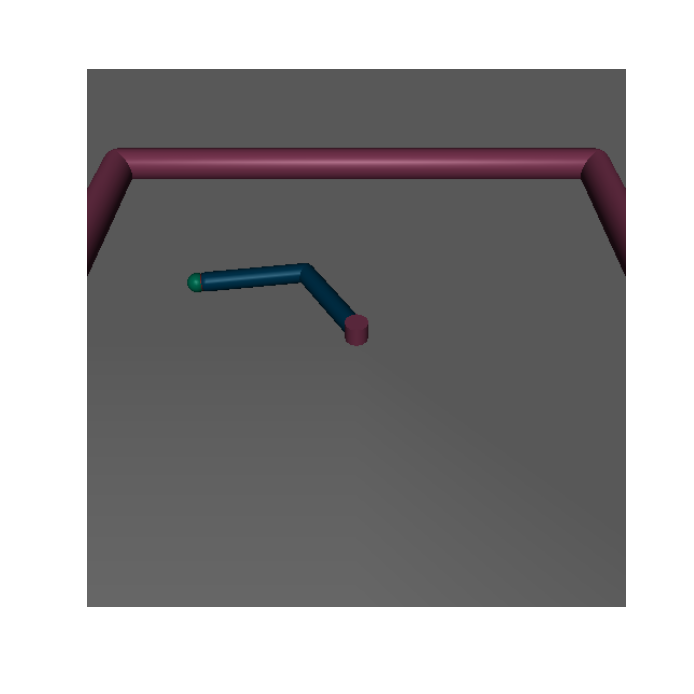
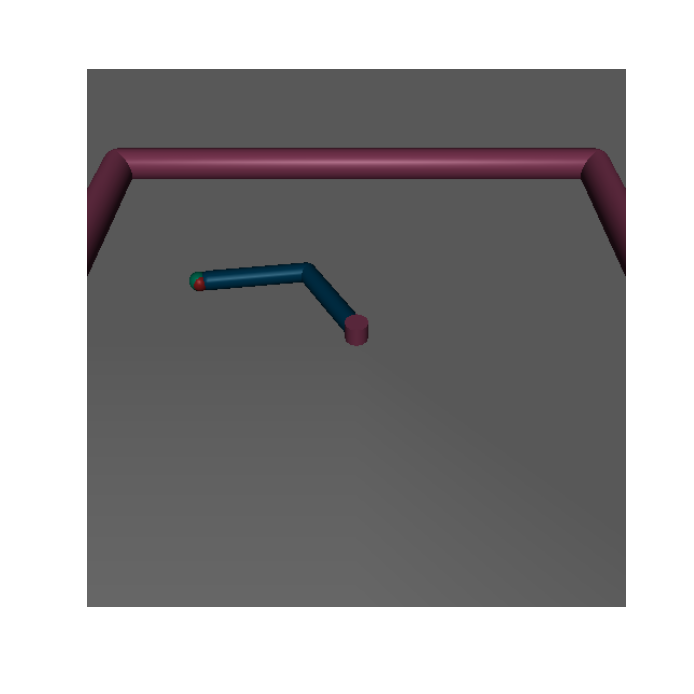
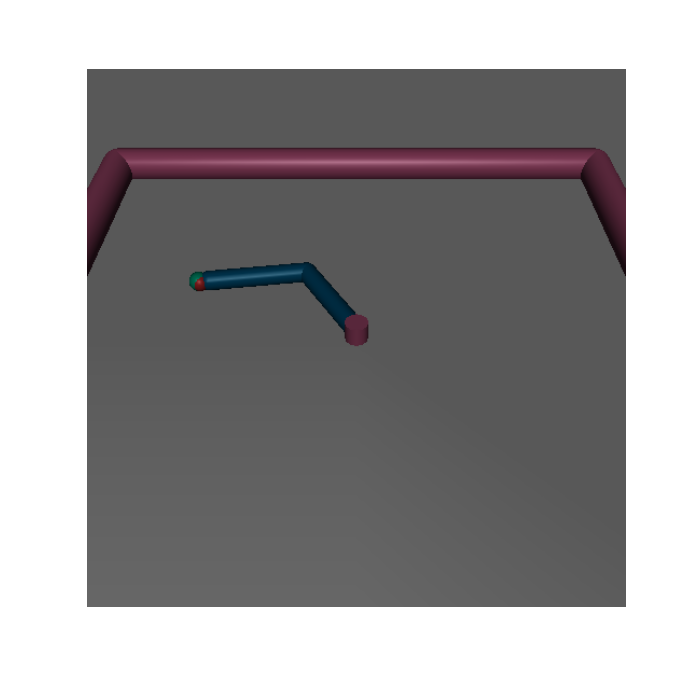
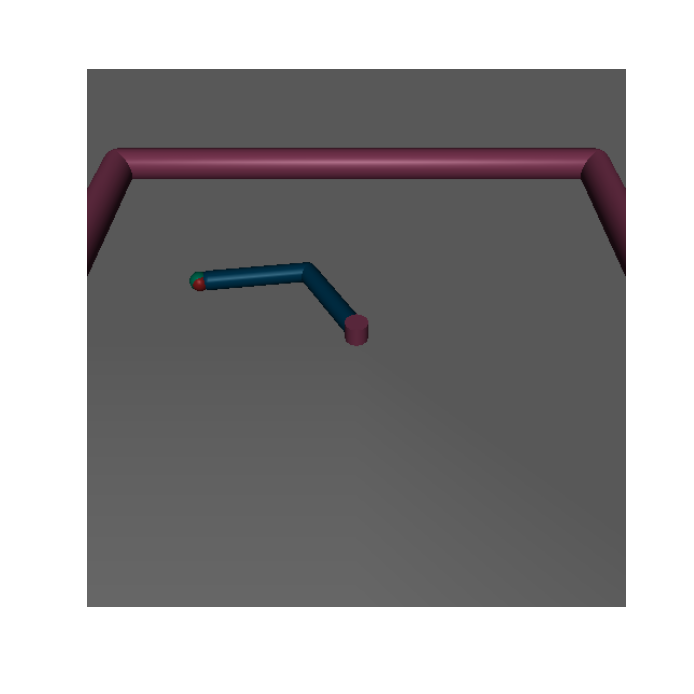
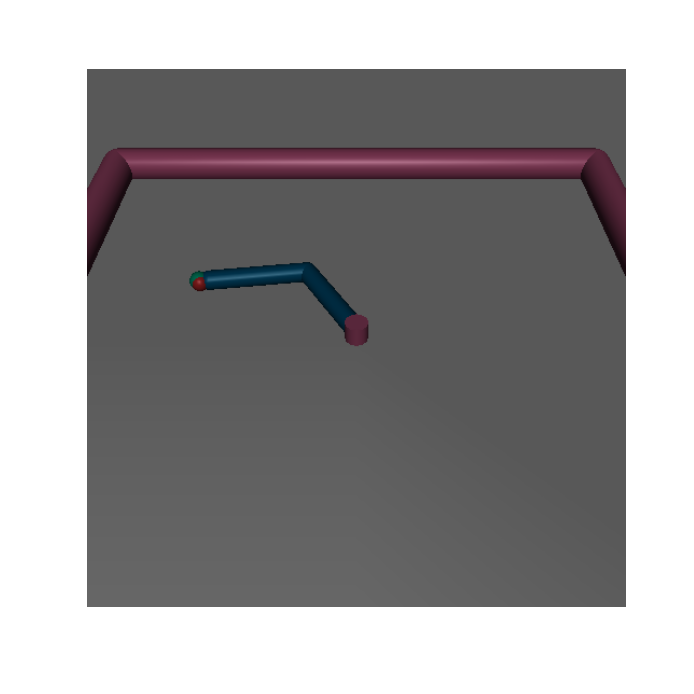
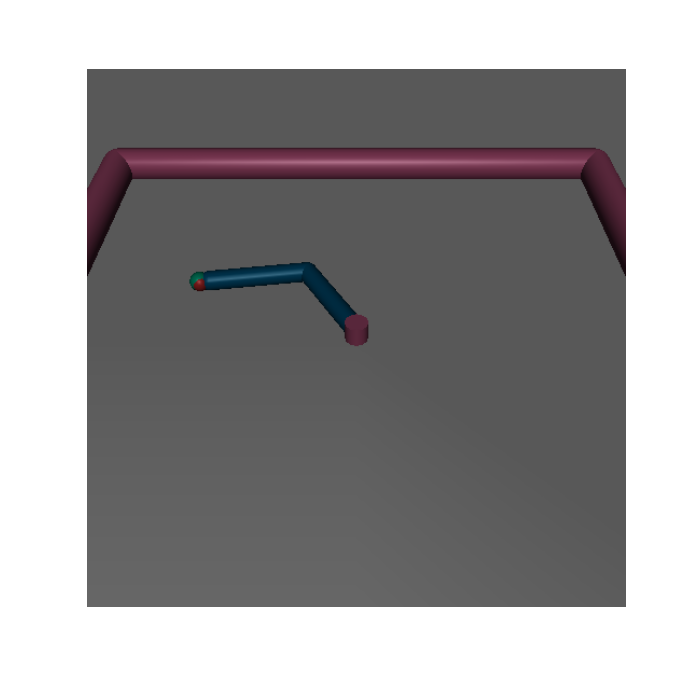
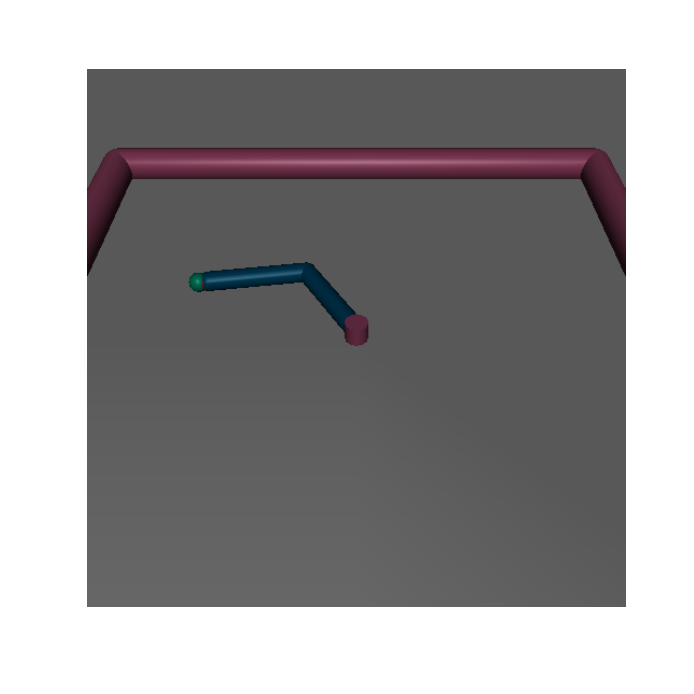
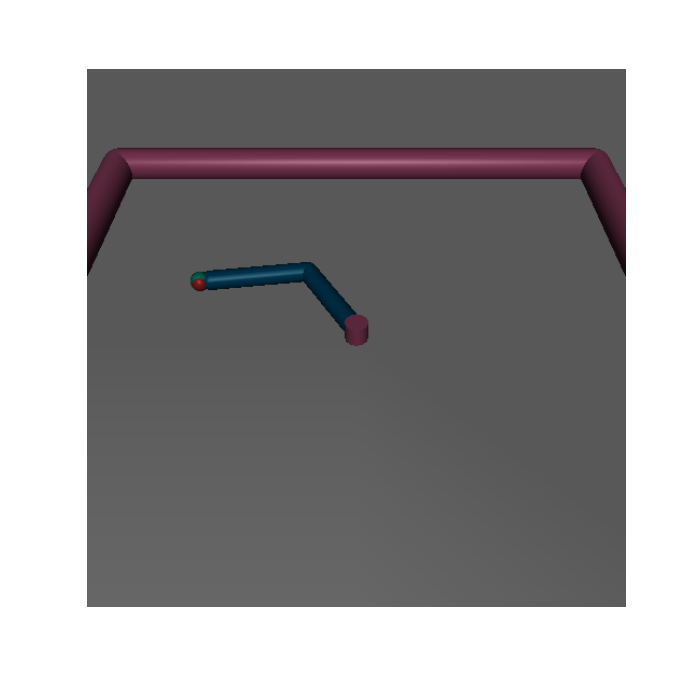
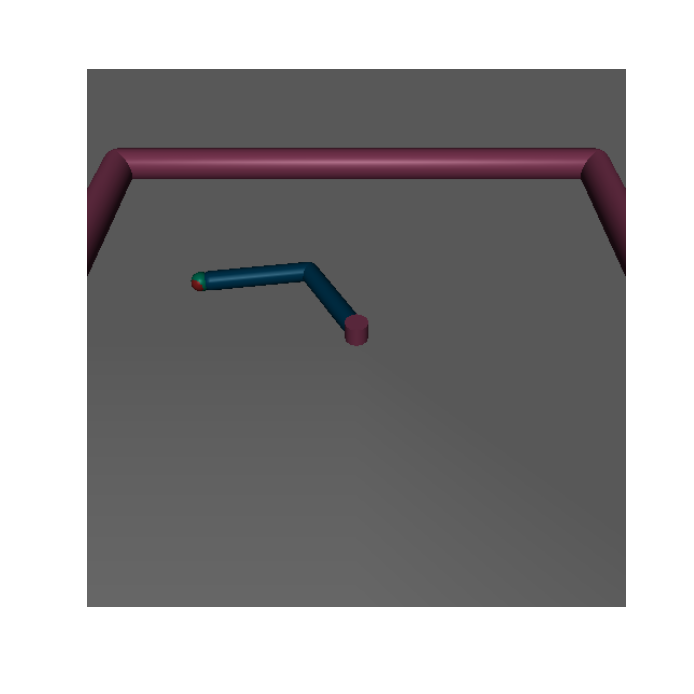
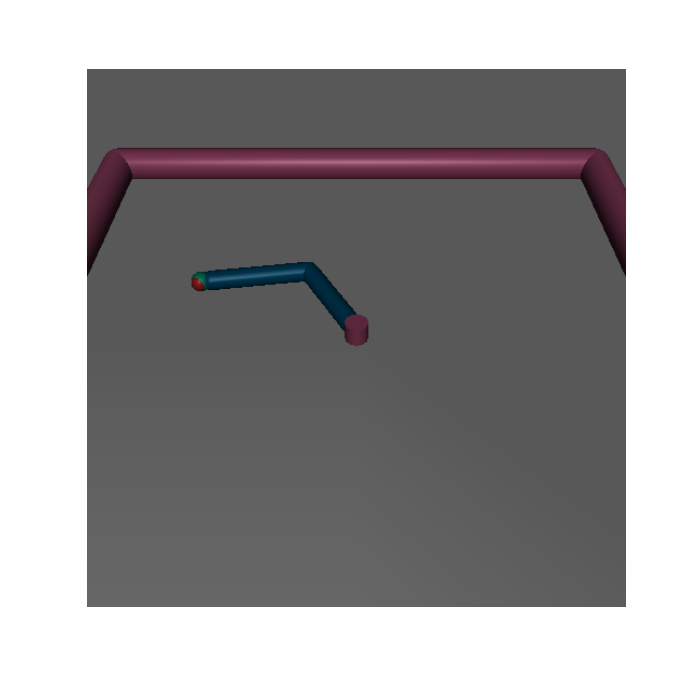
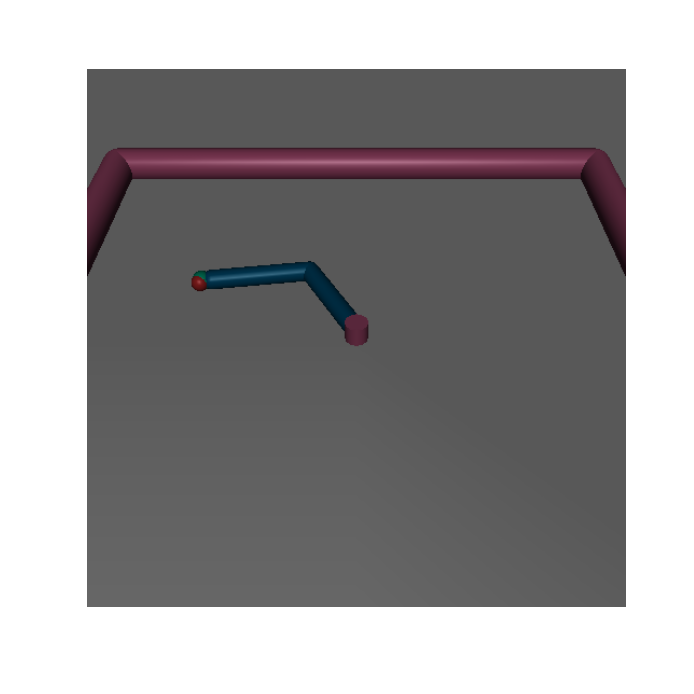
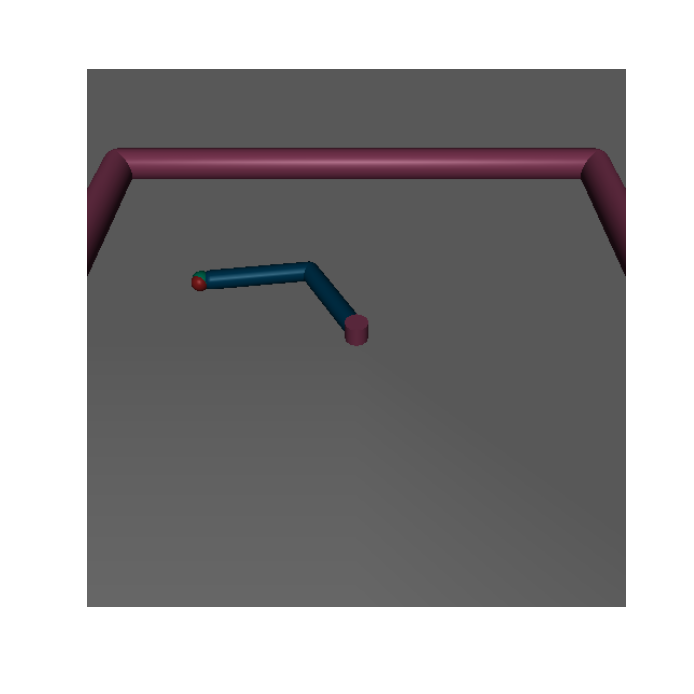
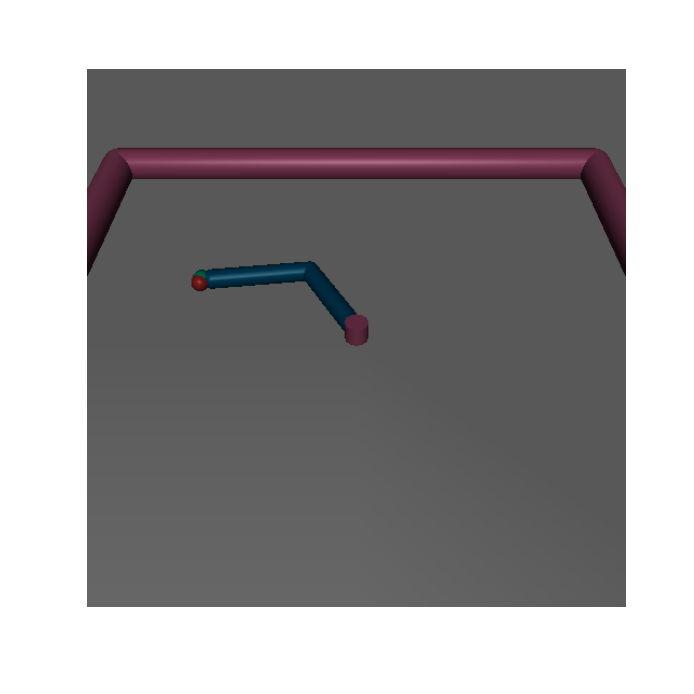
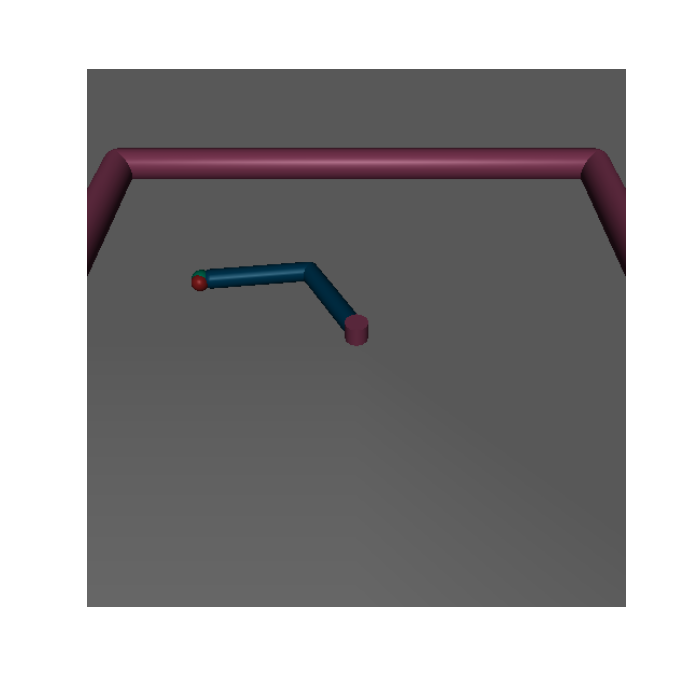
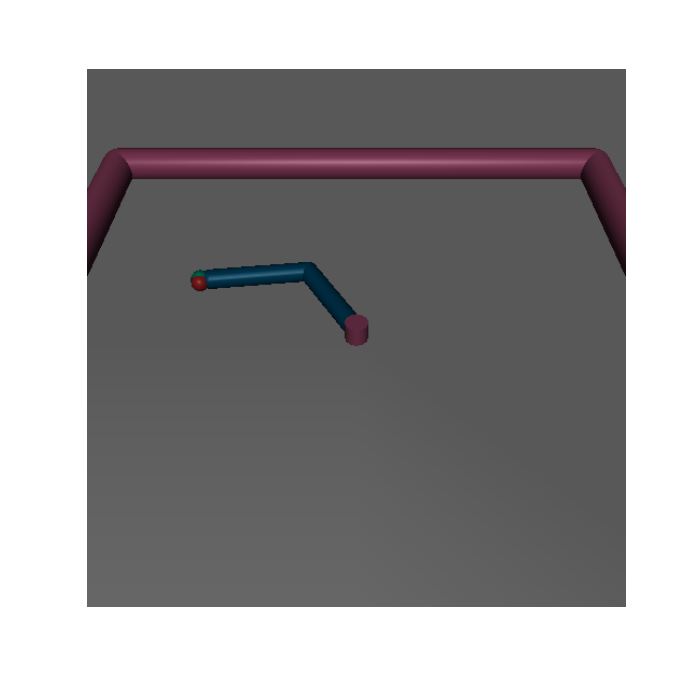
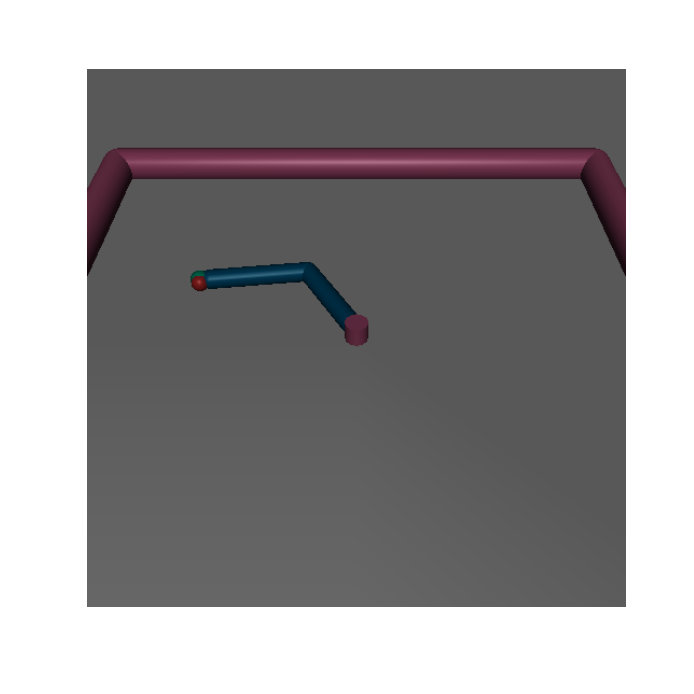
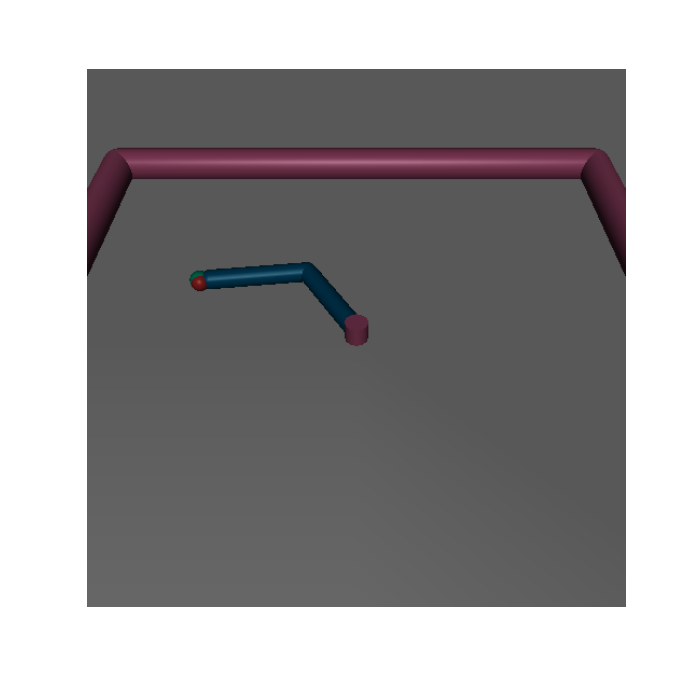
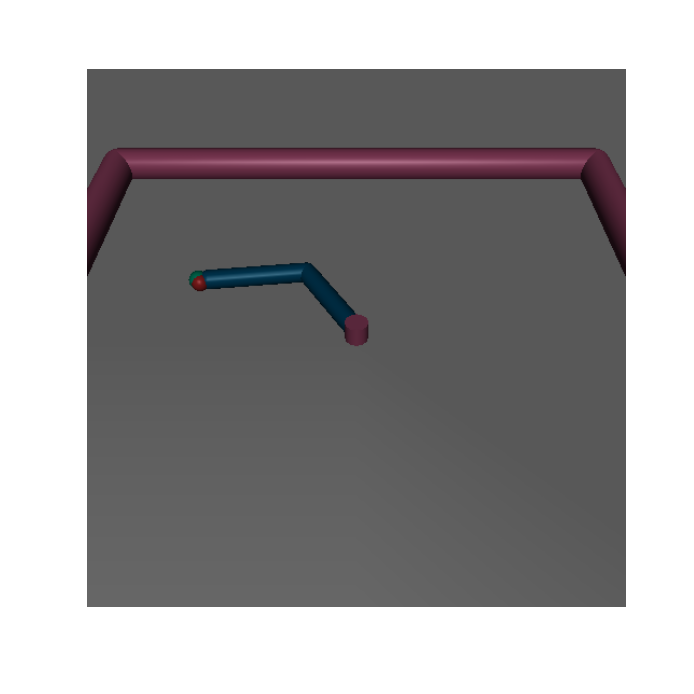
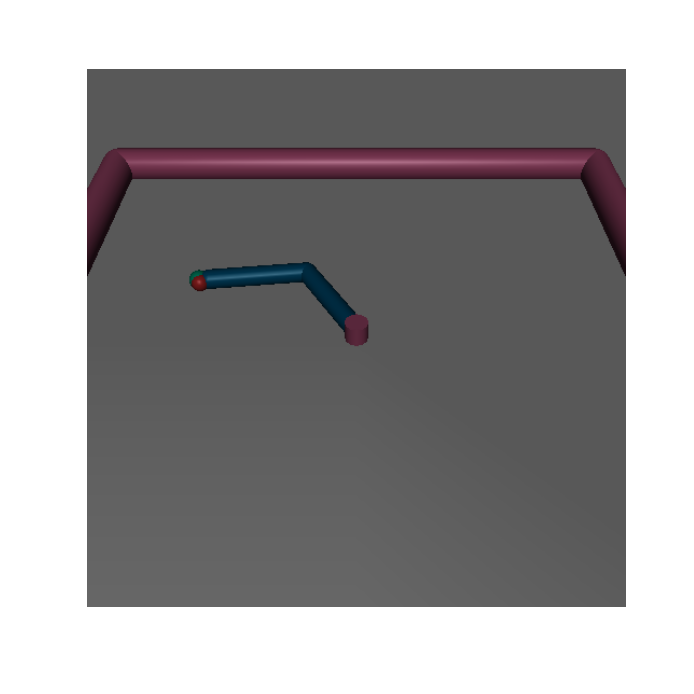
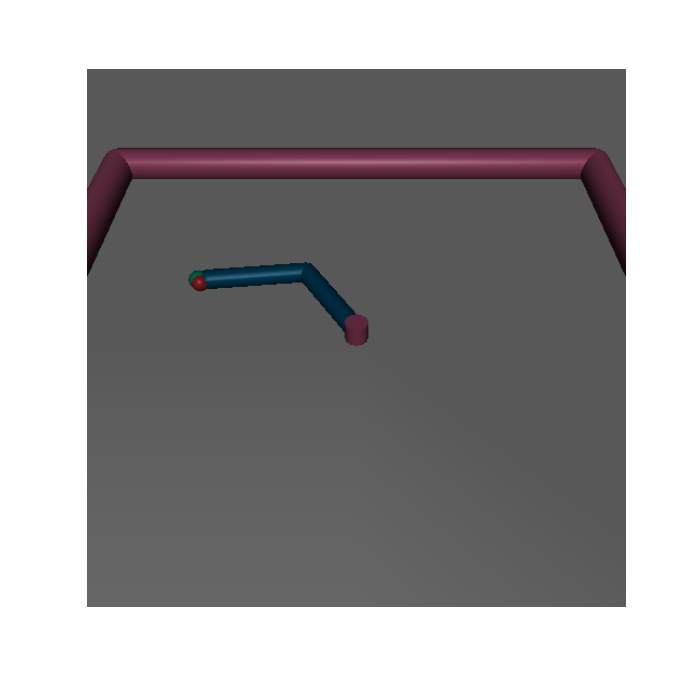
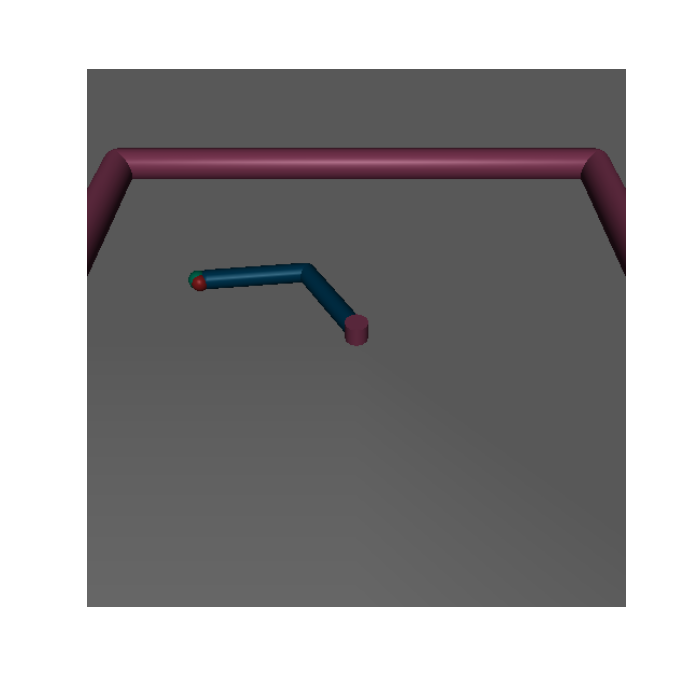
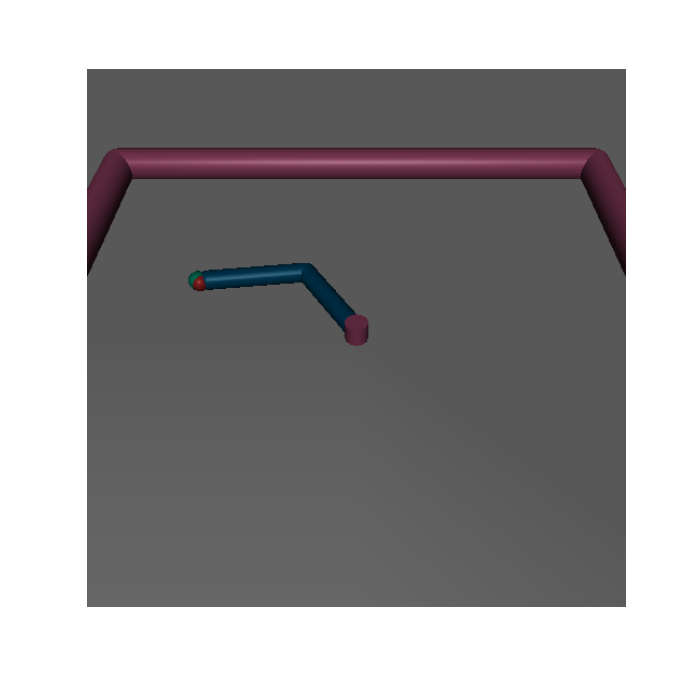
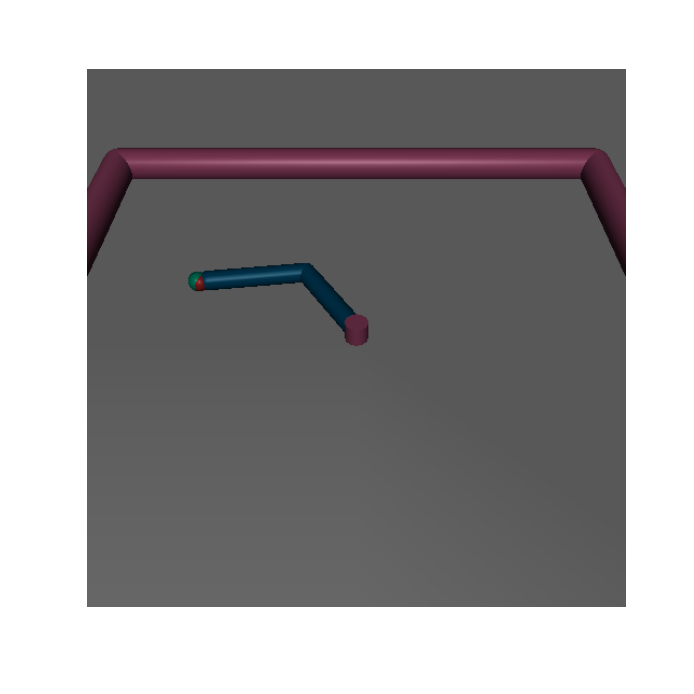
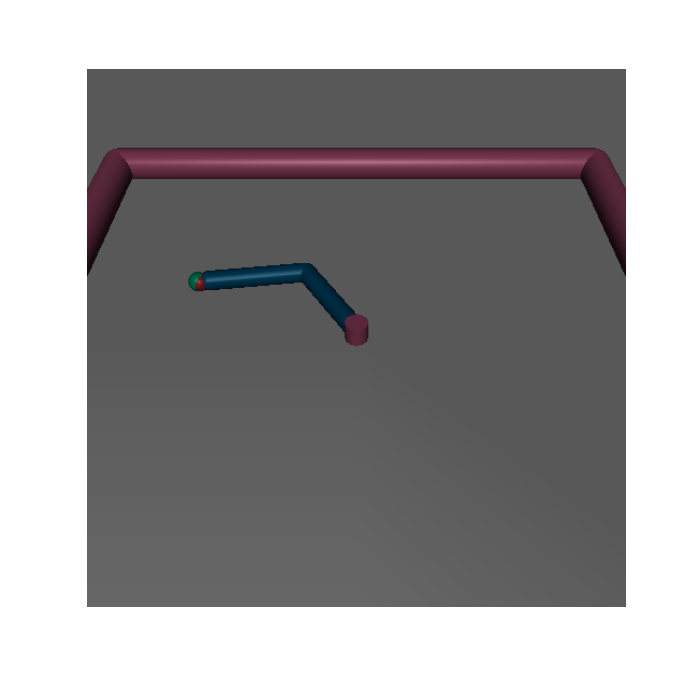
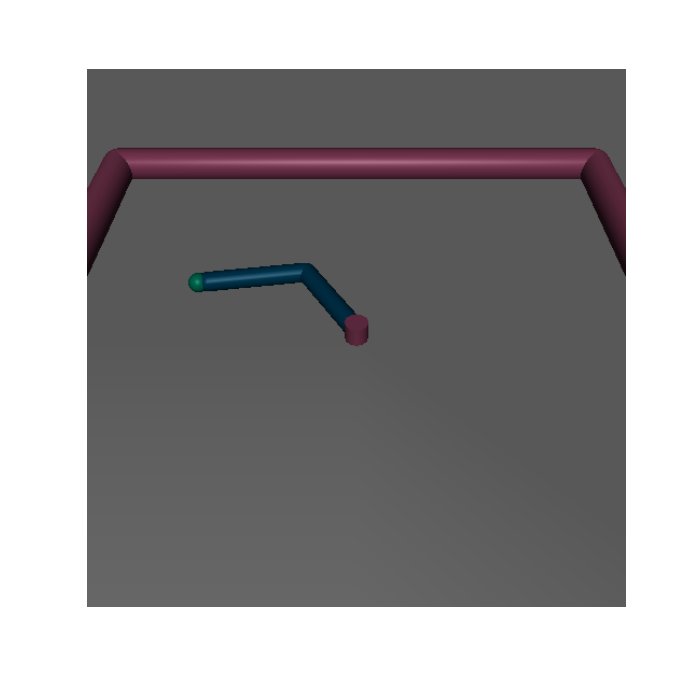
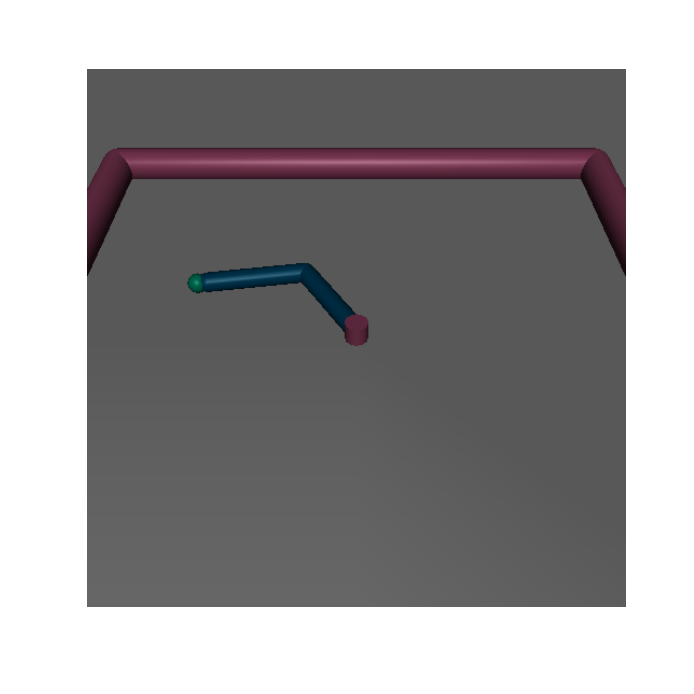
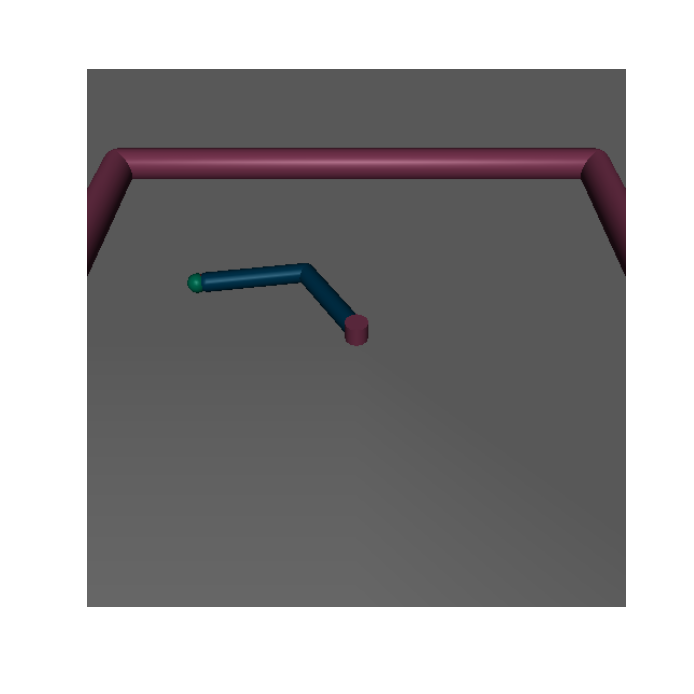
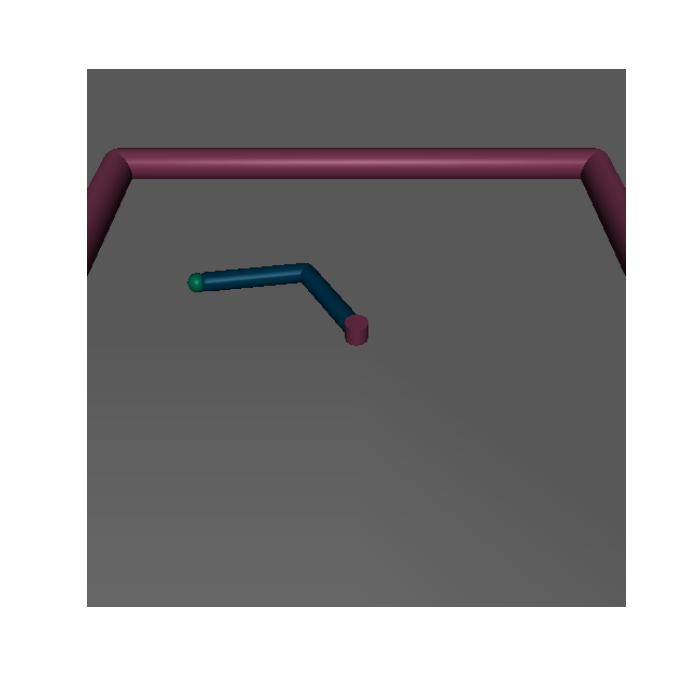
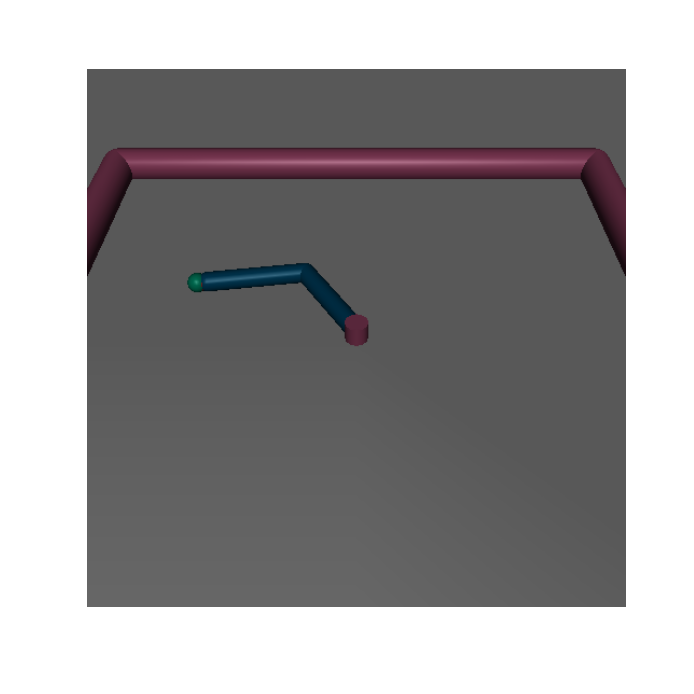
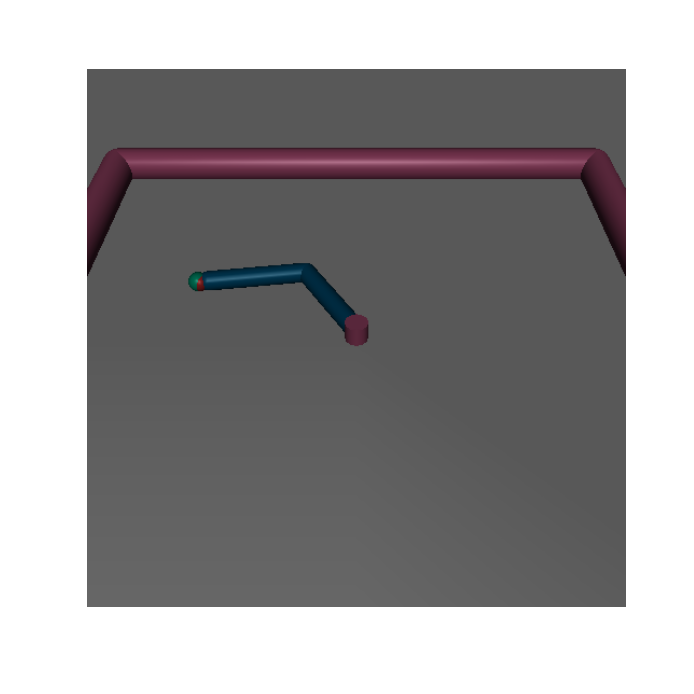
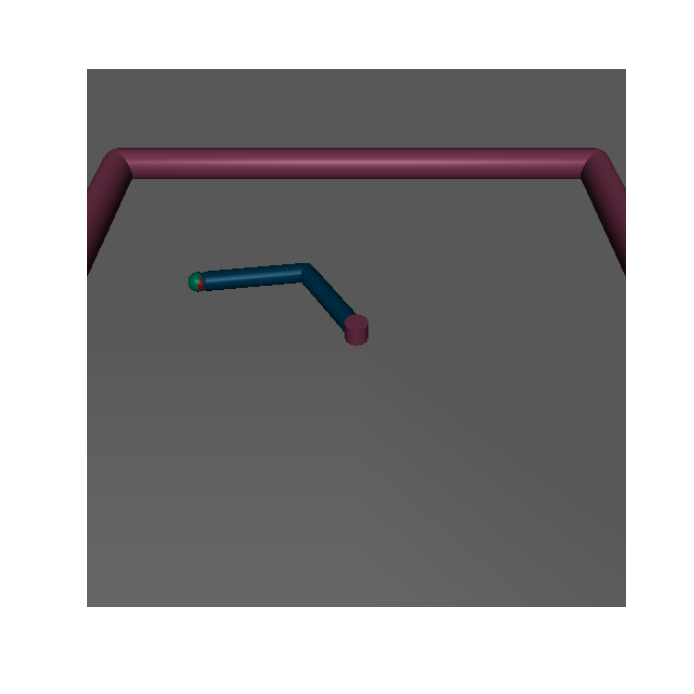
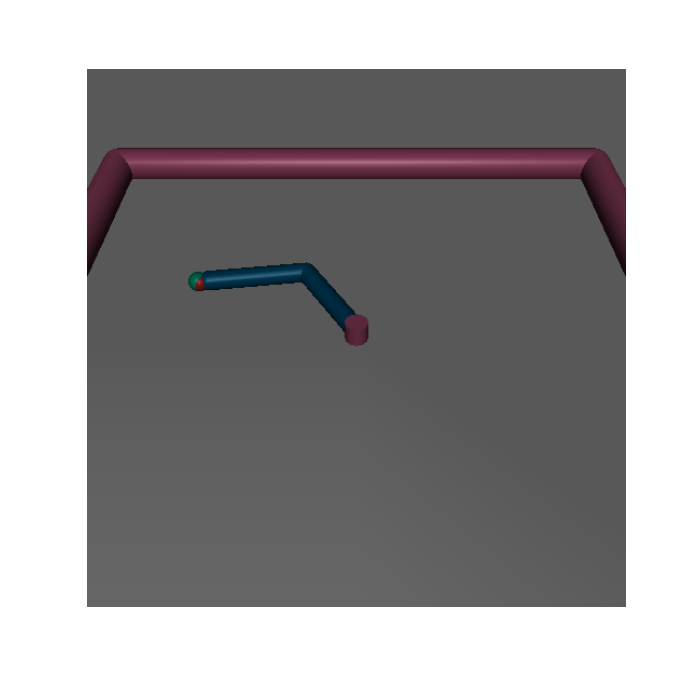
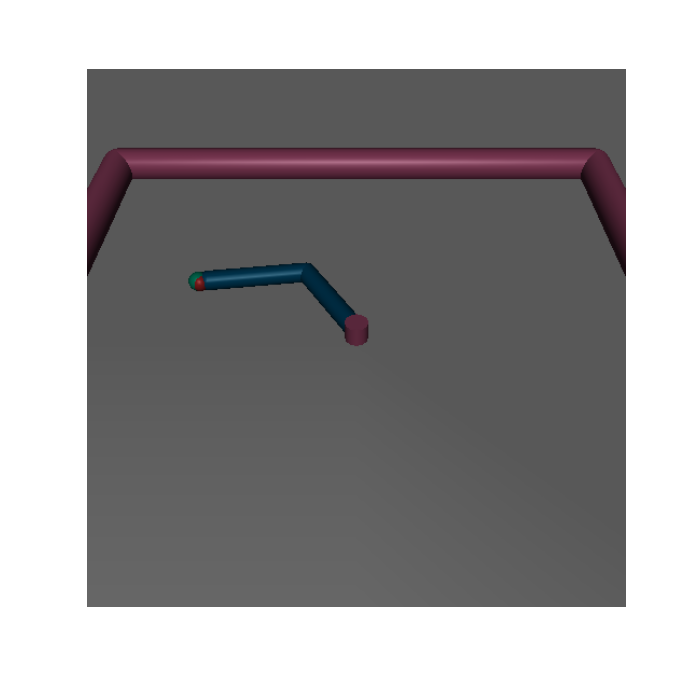
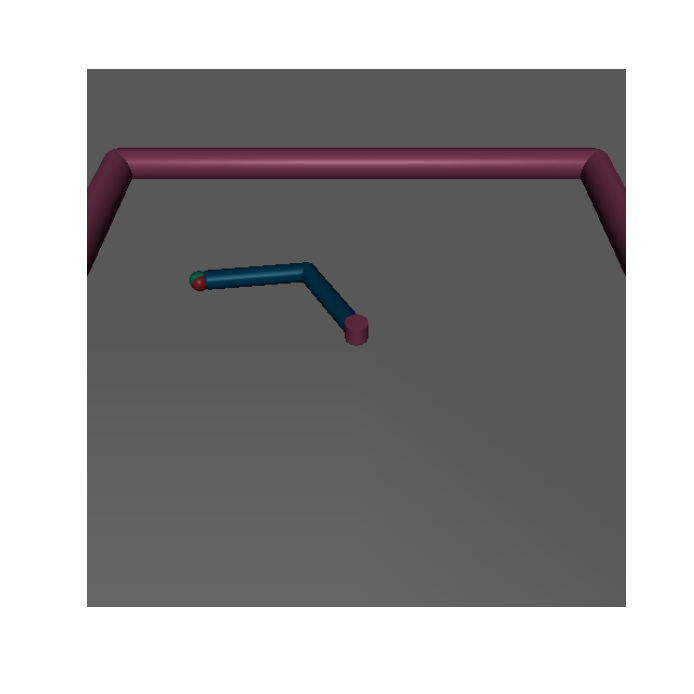
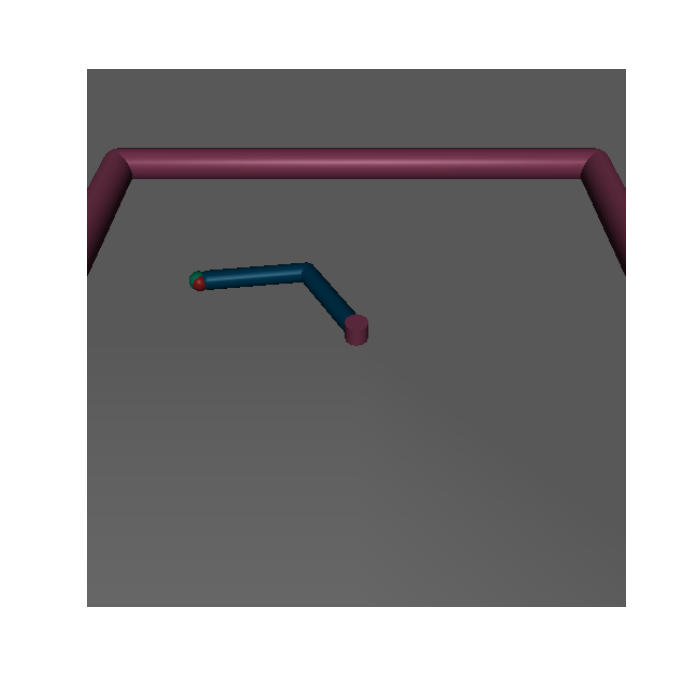
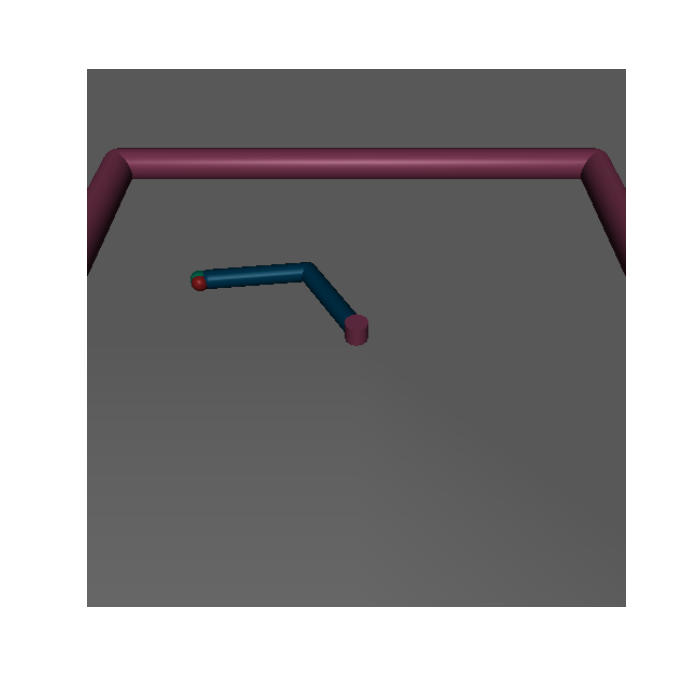
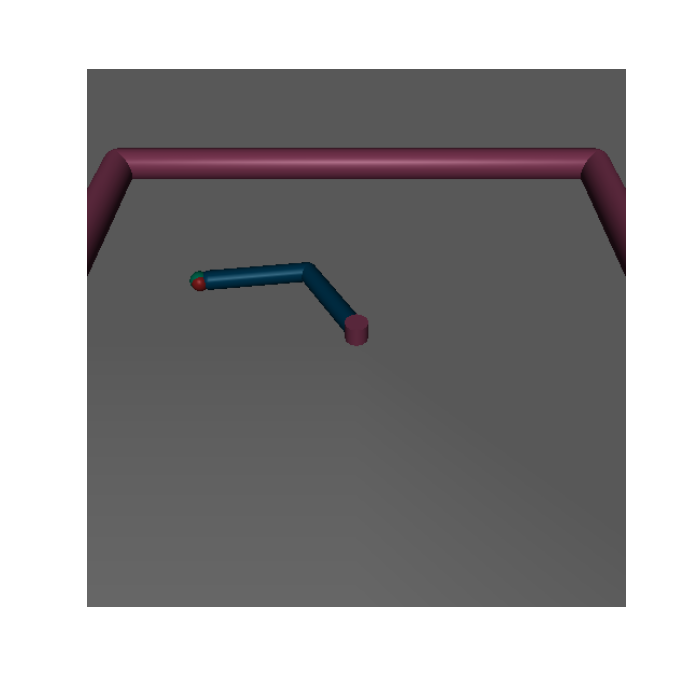
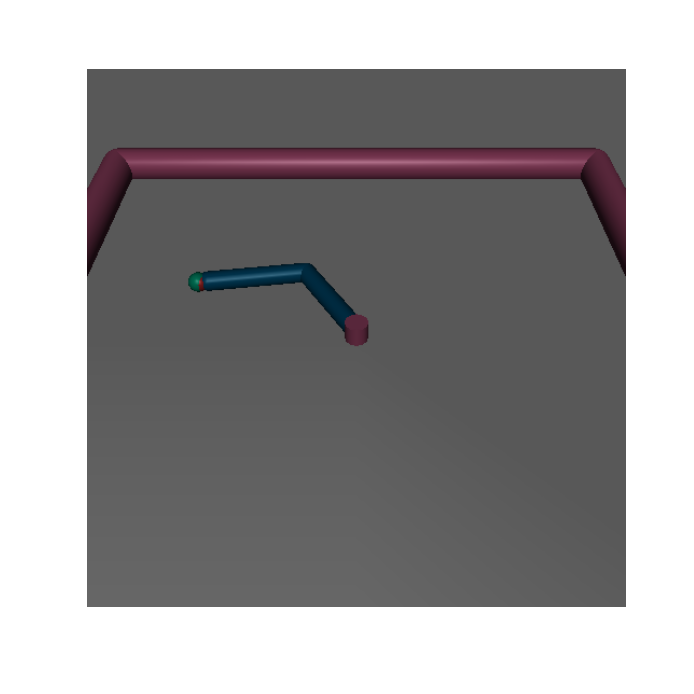
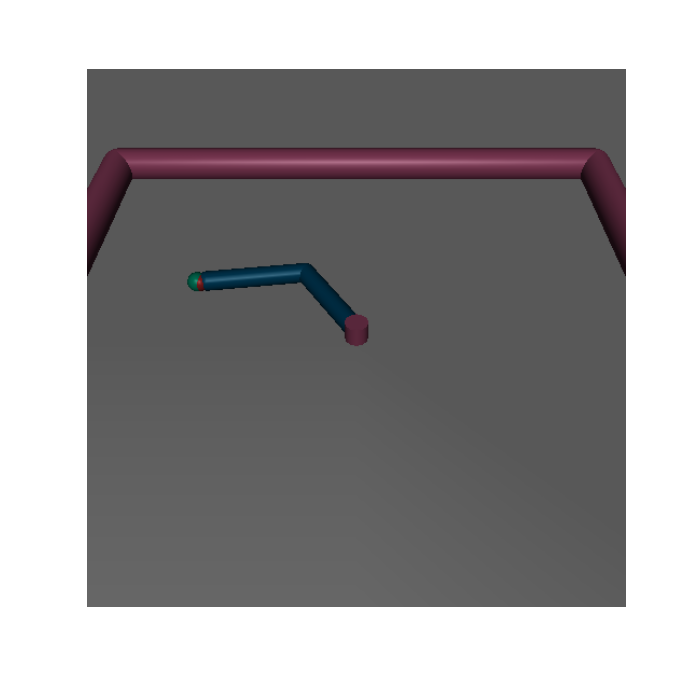
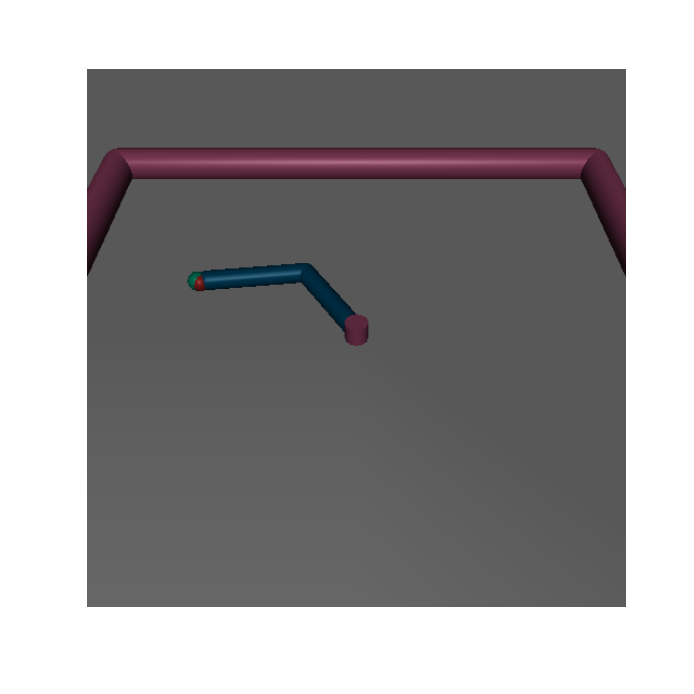
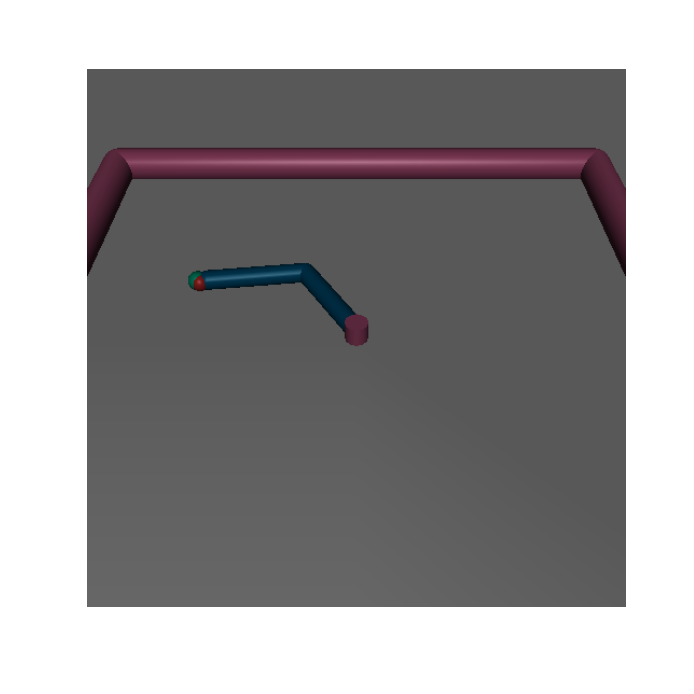
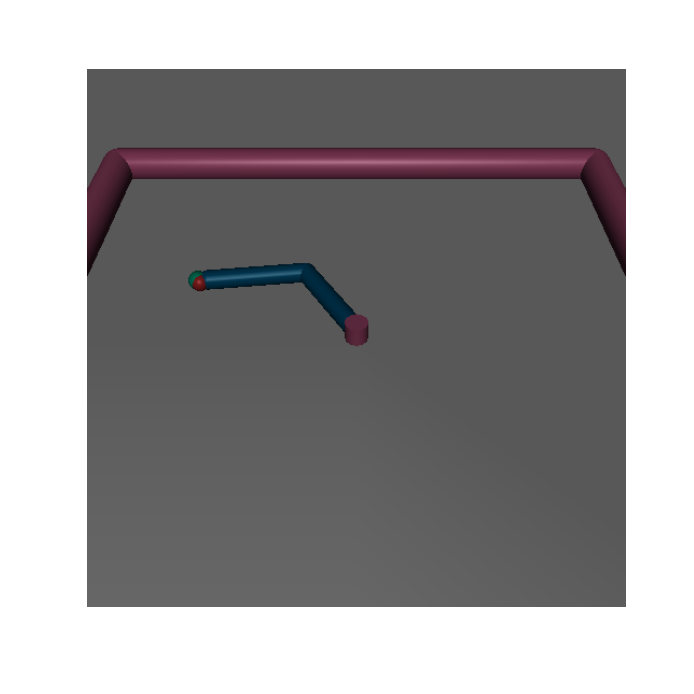
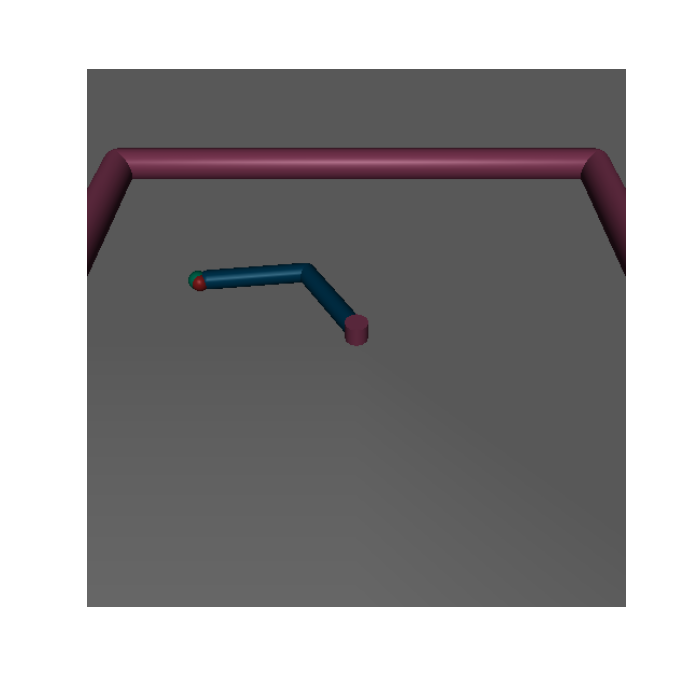
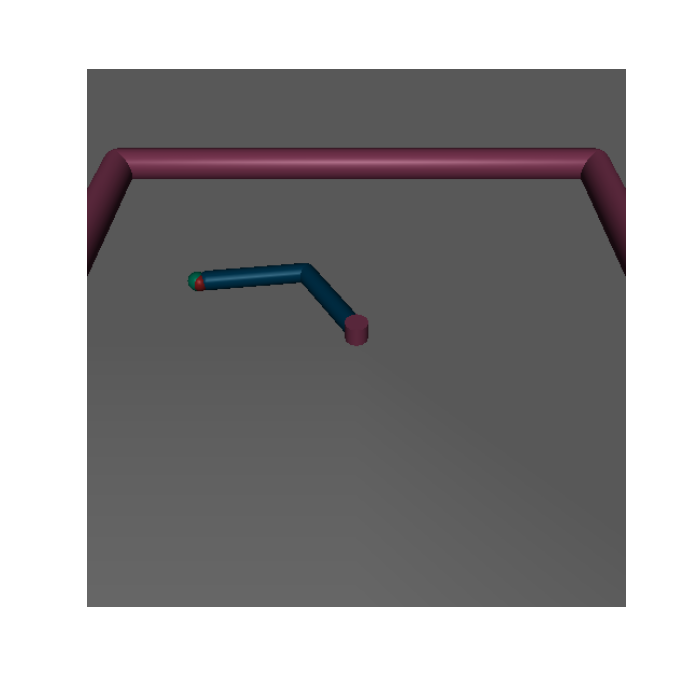
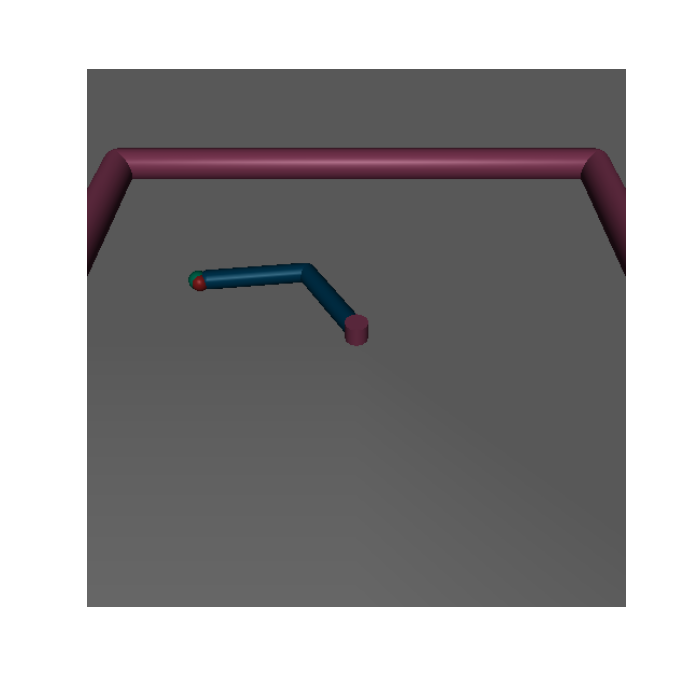
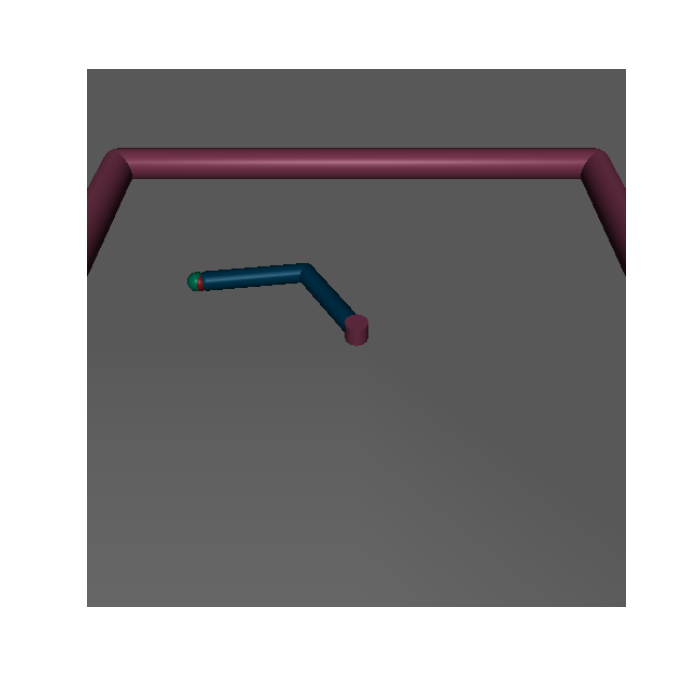
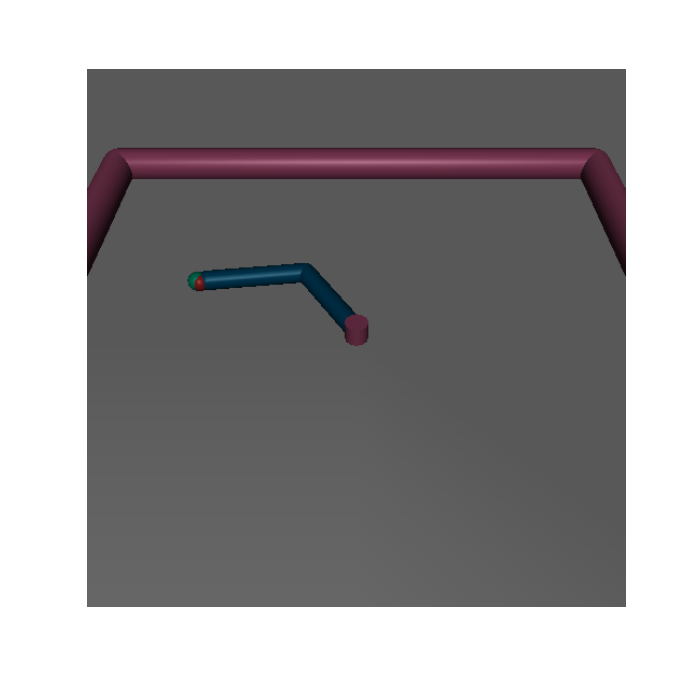
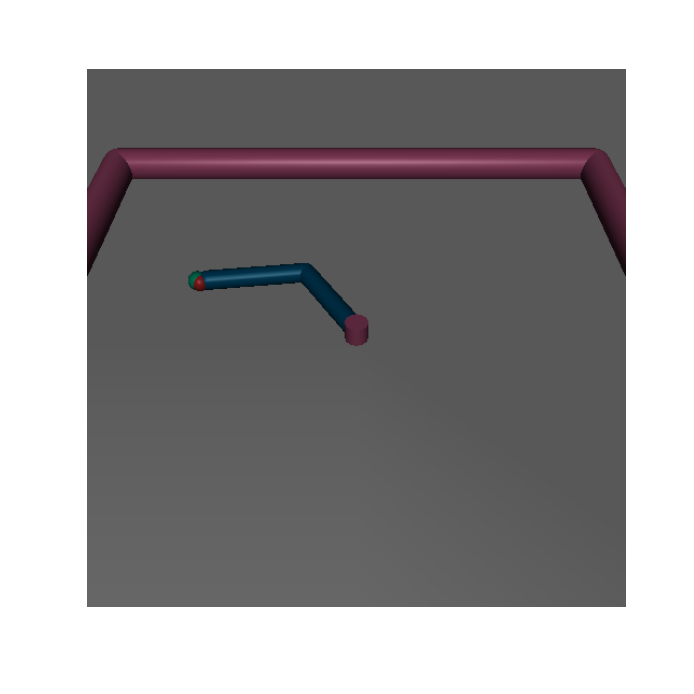
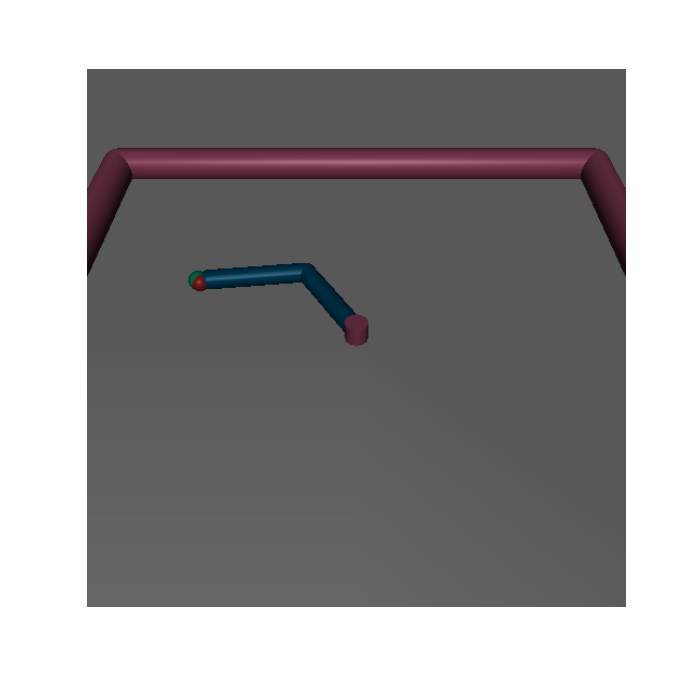
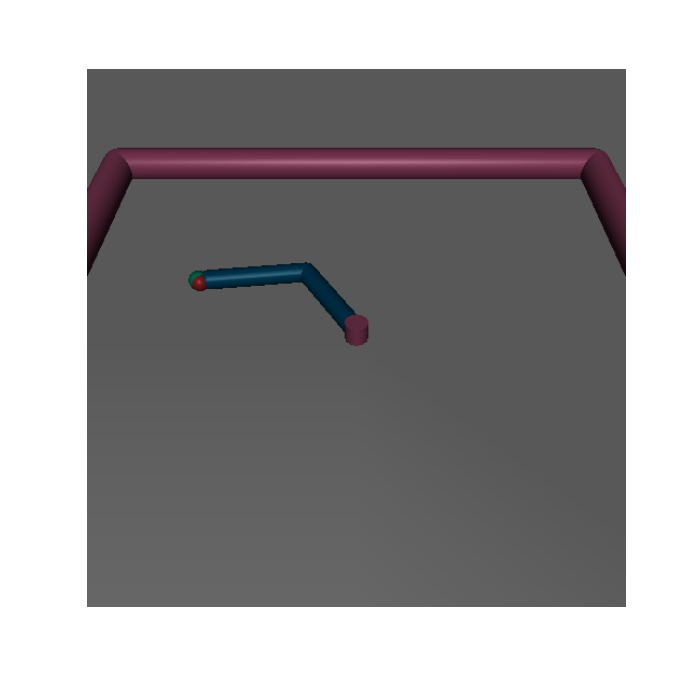
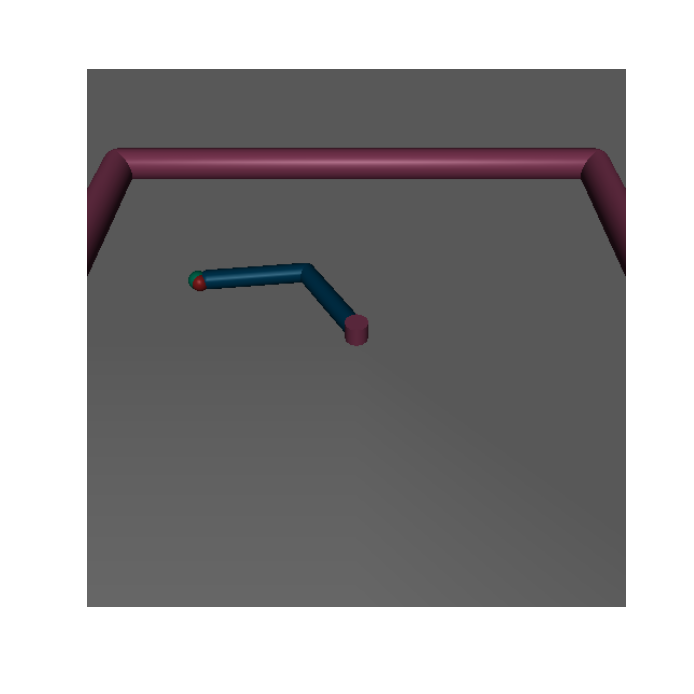
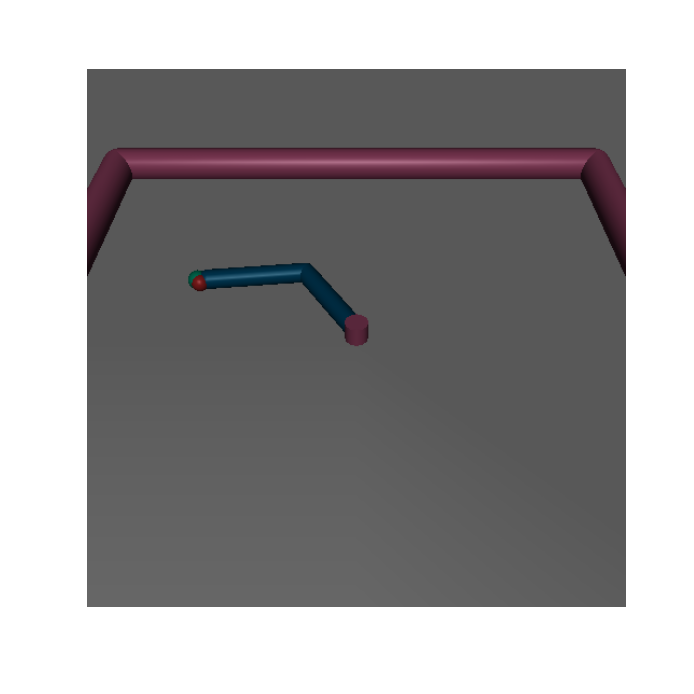
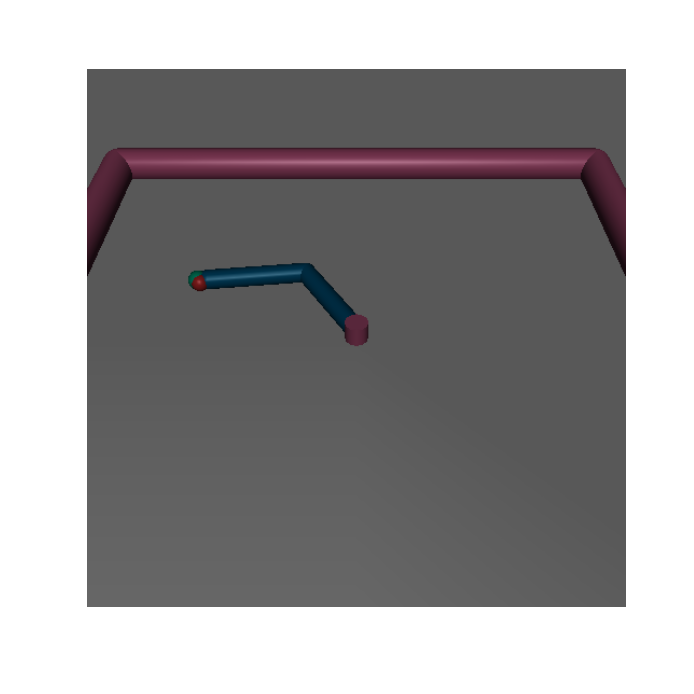
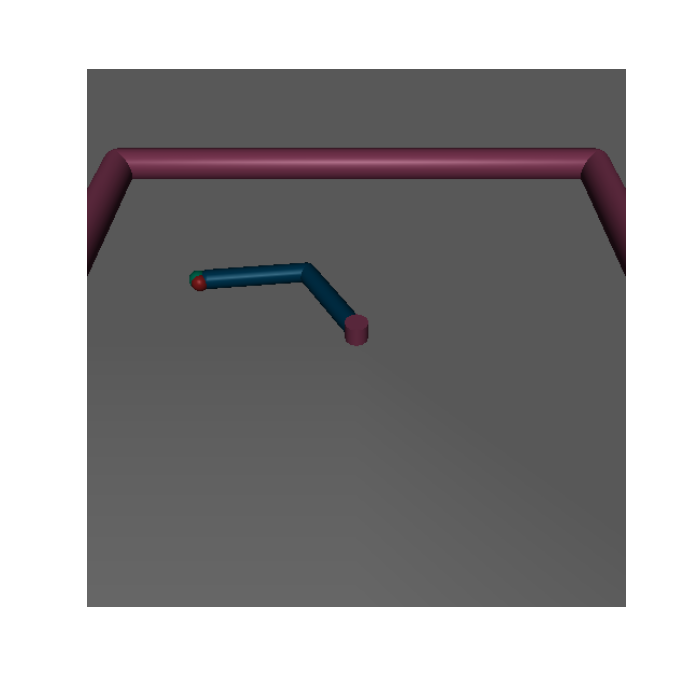
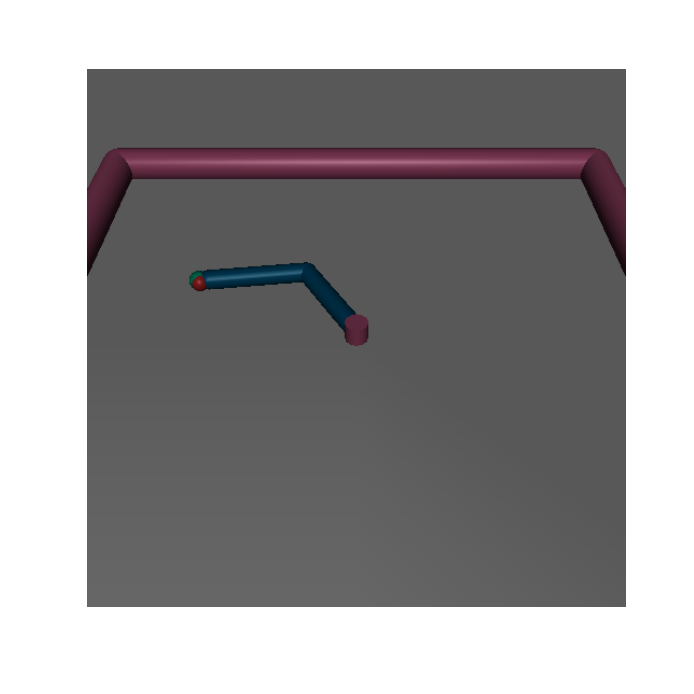
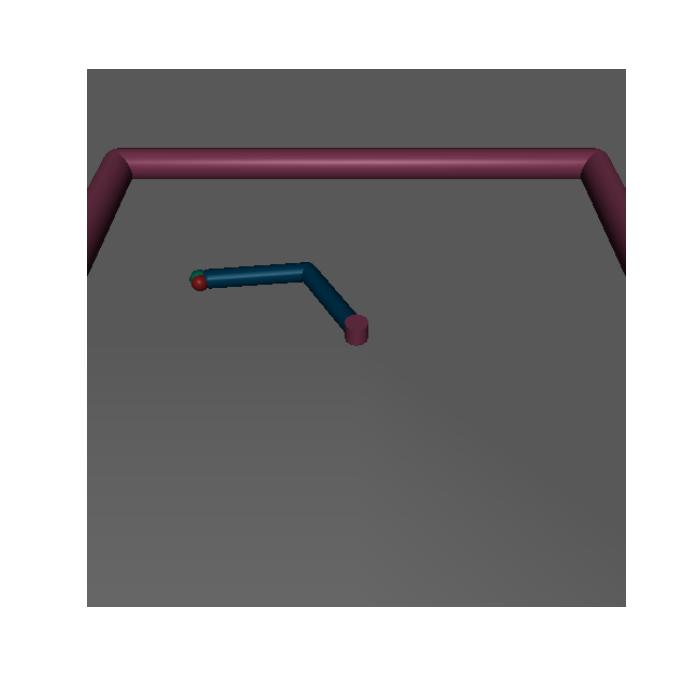
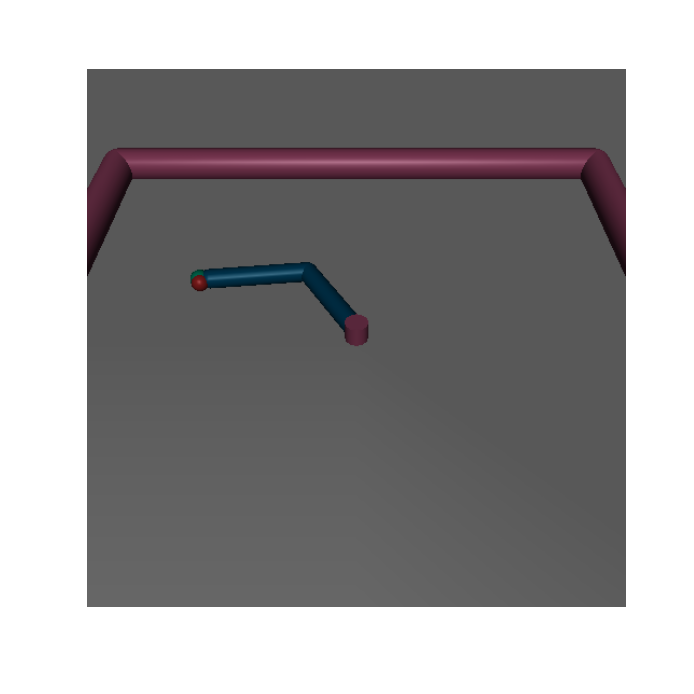
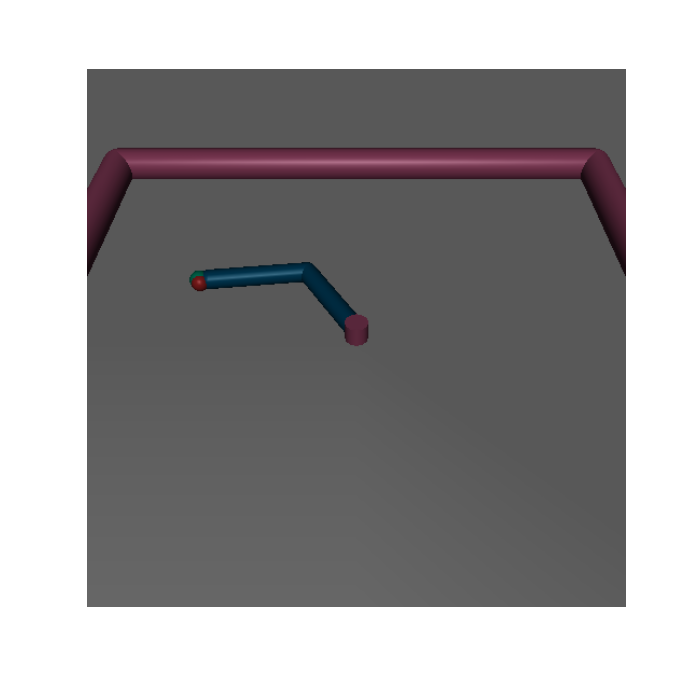

In [23]:
if settings["render_environment"]:
    exp.display_frames_as_gif()

In [24]:
#session.close() 

In [25]:
exp.print_all_tf_variables()

(u'Actor_hidden_0_256_W:0', array([[ 0.02184531,  0.6584869 , -0.35250694, ...,  0.02292078,
        -0.14805187,  0.33367008],
       [-0.45958108, -0.58810782,  0.8525458 , ..., -0.40822548,
        -0.66705292,  0.19058971],
       [-0.23675433, -0.80031902,  0.55785418, ...,  0.11207366,
         0.11094981,  0.11024426],
       ..., 
       [-0.19149378,  0.35838678, -0.18620855, ...,  0.42209318,
        -0.25108942, -0.07744219],
       [ 0.30462518,  0.03072642, -0.31604305, ..., -0.02419103,
         0.07561729, -0.93943244],
       [-0.30388325, -0.09148772, -0.19608556, ...,  0.06734596,
         0.27259329, -0.03550243]], dtype=float32))
(u'Actor_hidden_0_256_b:0', array([ 0.05225403, -1.96510601, -0.39344555,  0.39989161, -0.60444248,
       -0.21370804,  0.33721957,  1.86844873,  0.85644197, -0.08228492,
        0.77838361,  0.85716838,  0.04178184, -0.82109809, -0.40532449,
       -0.11042746, -0.04064947, -0.37955201, -0.56409848,  1.3267051 ,
        0.39185208, -0.263